# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 9.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [1]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

sns.set(style="darkgrid")
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 15, 9
plt.rcParams['font.size'] = 16
# plt.rcParams['savefig.format'] = 'pdf'
sns.set_style('darkgrid')

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [3]:
df = pd.read_csv('train.csv')

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [4]:
df = df.drop('dropoff_datetime', axis=1)

In [5]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)

In [6]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

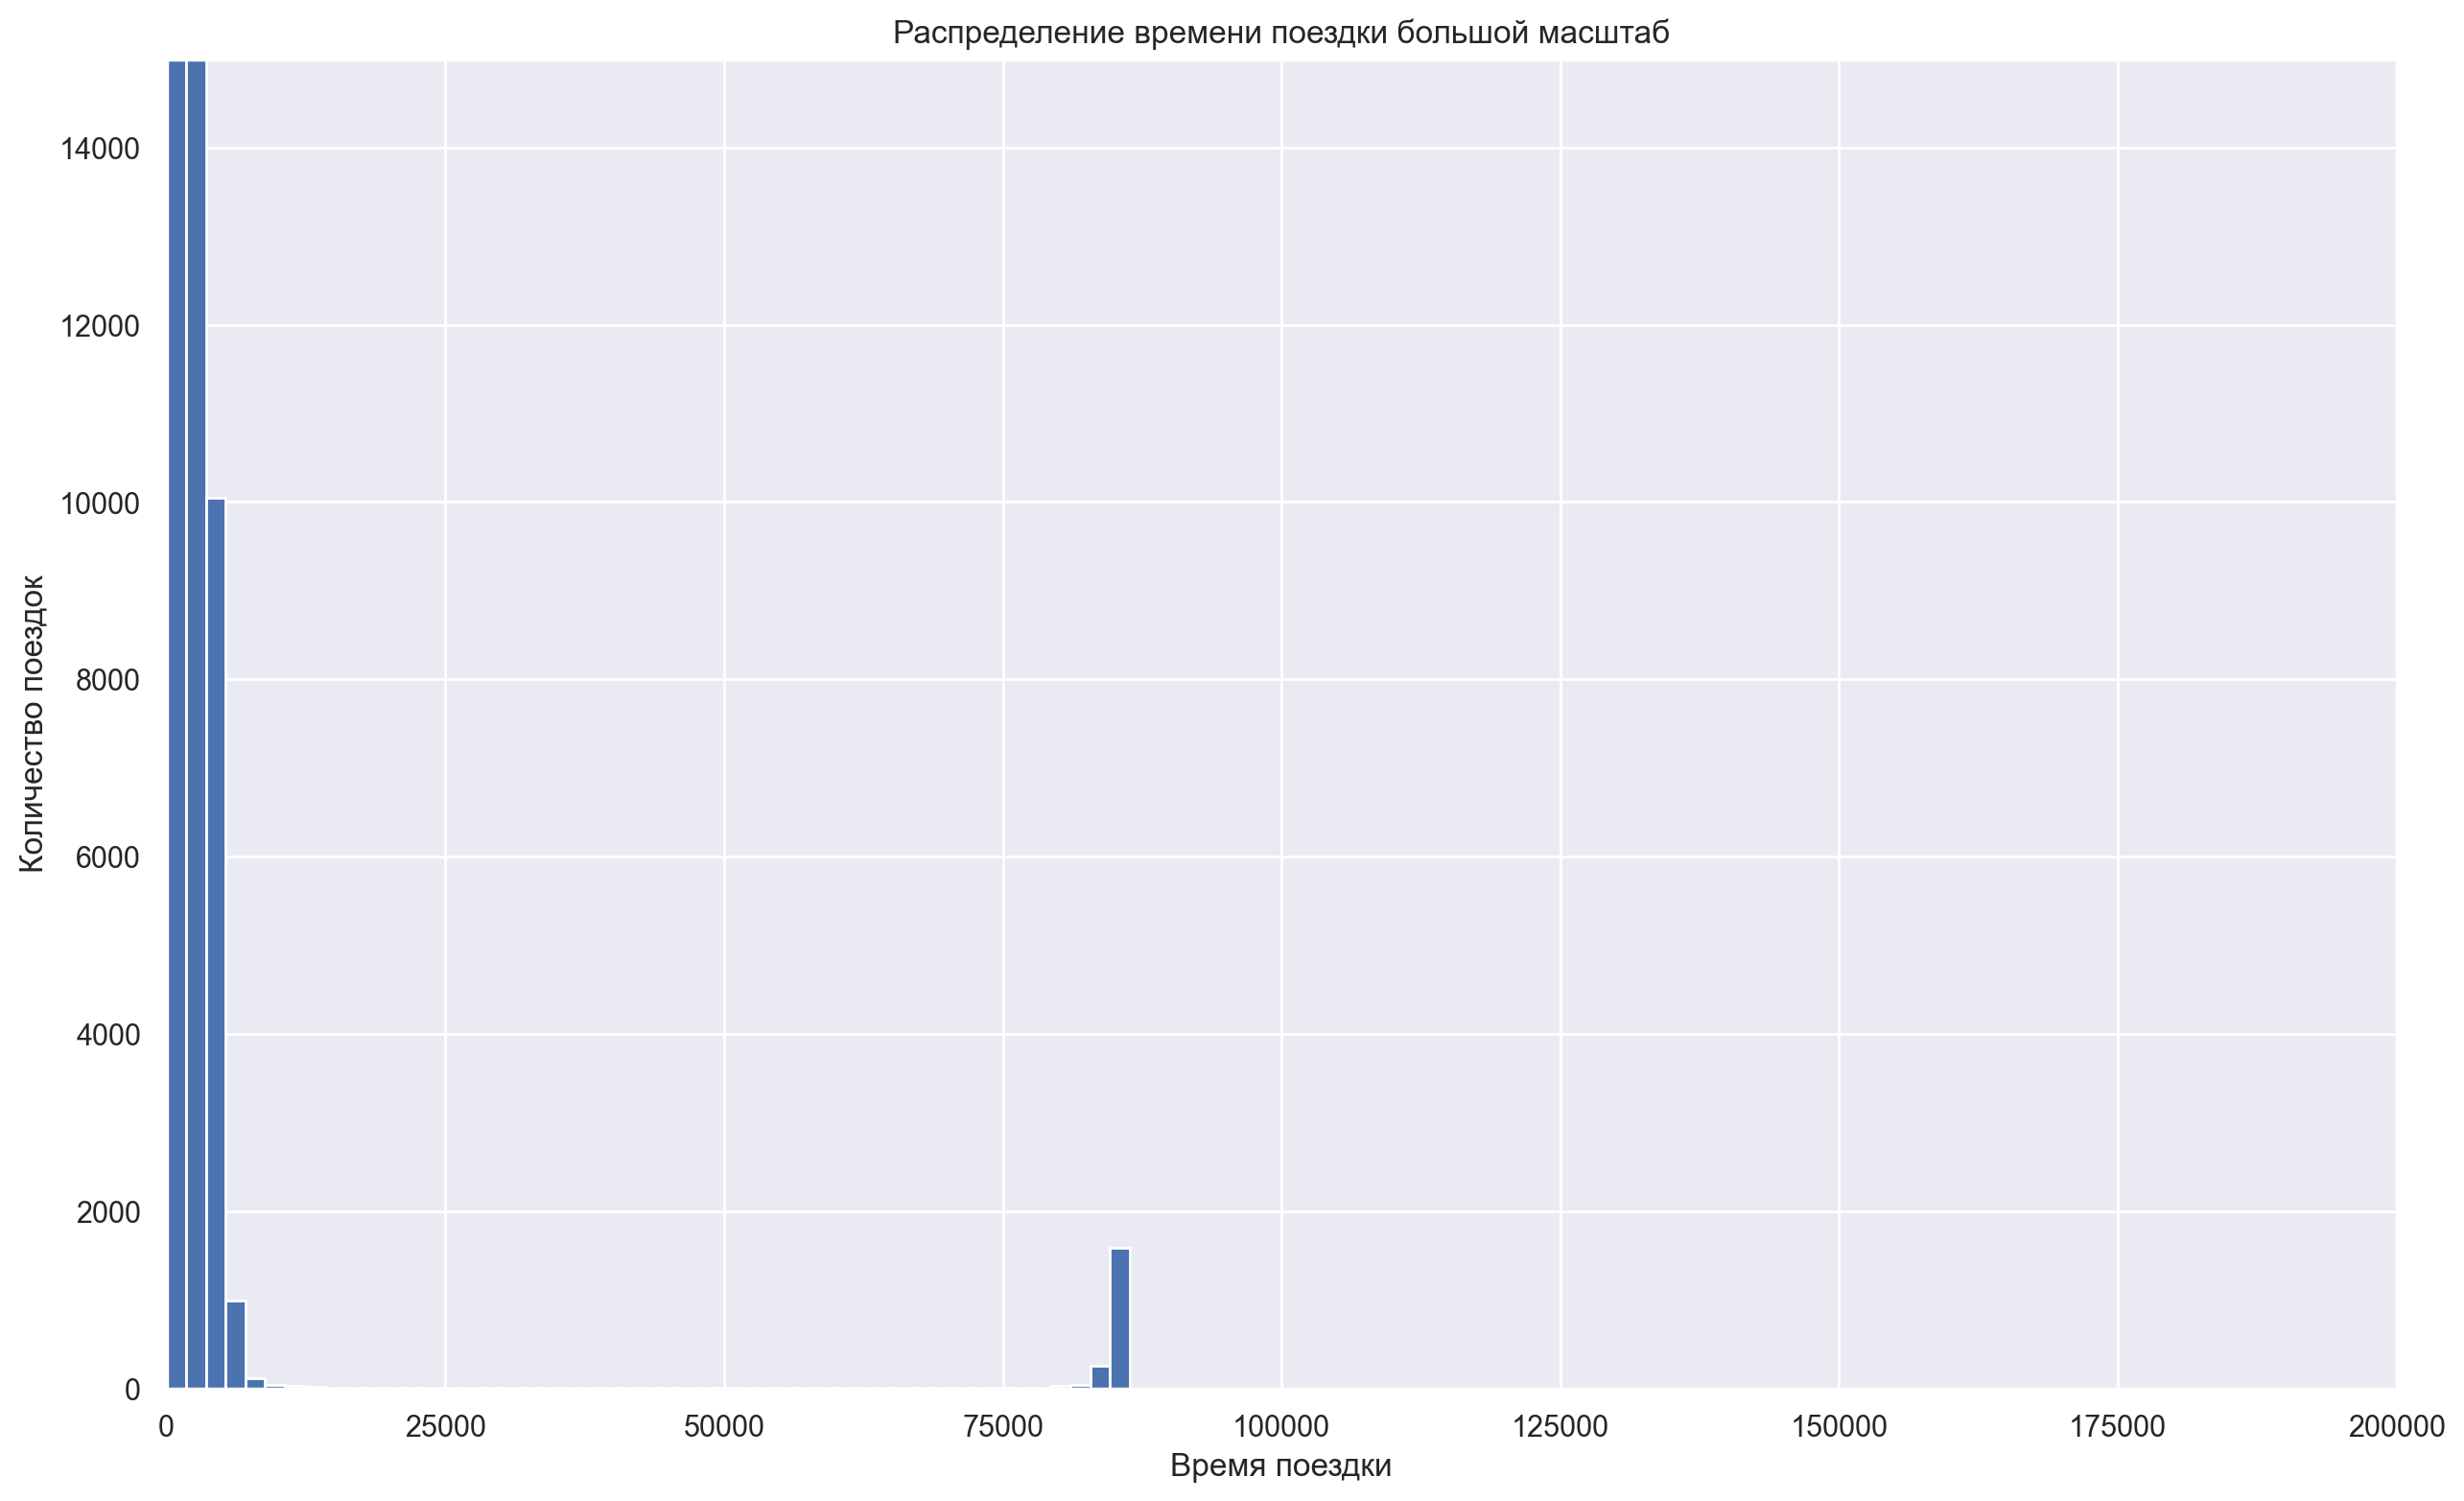

In [7]:
# plt.figure(figsize = (15,9))
plt.hist(df['trip_duration'], bins = 2000)

plt.title('Распределение времени поездки большой масштаб')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')

plt.xlim(0,2e5)
plt.ylim(0, 15000)
plt.show()

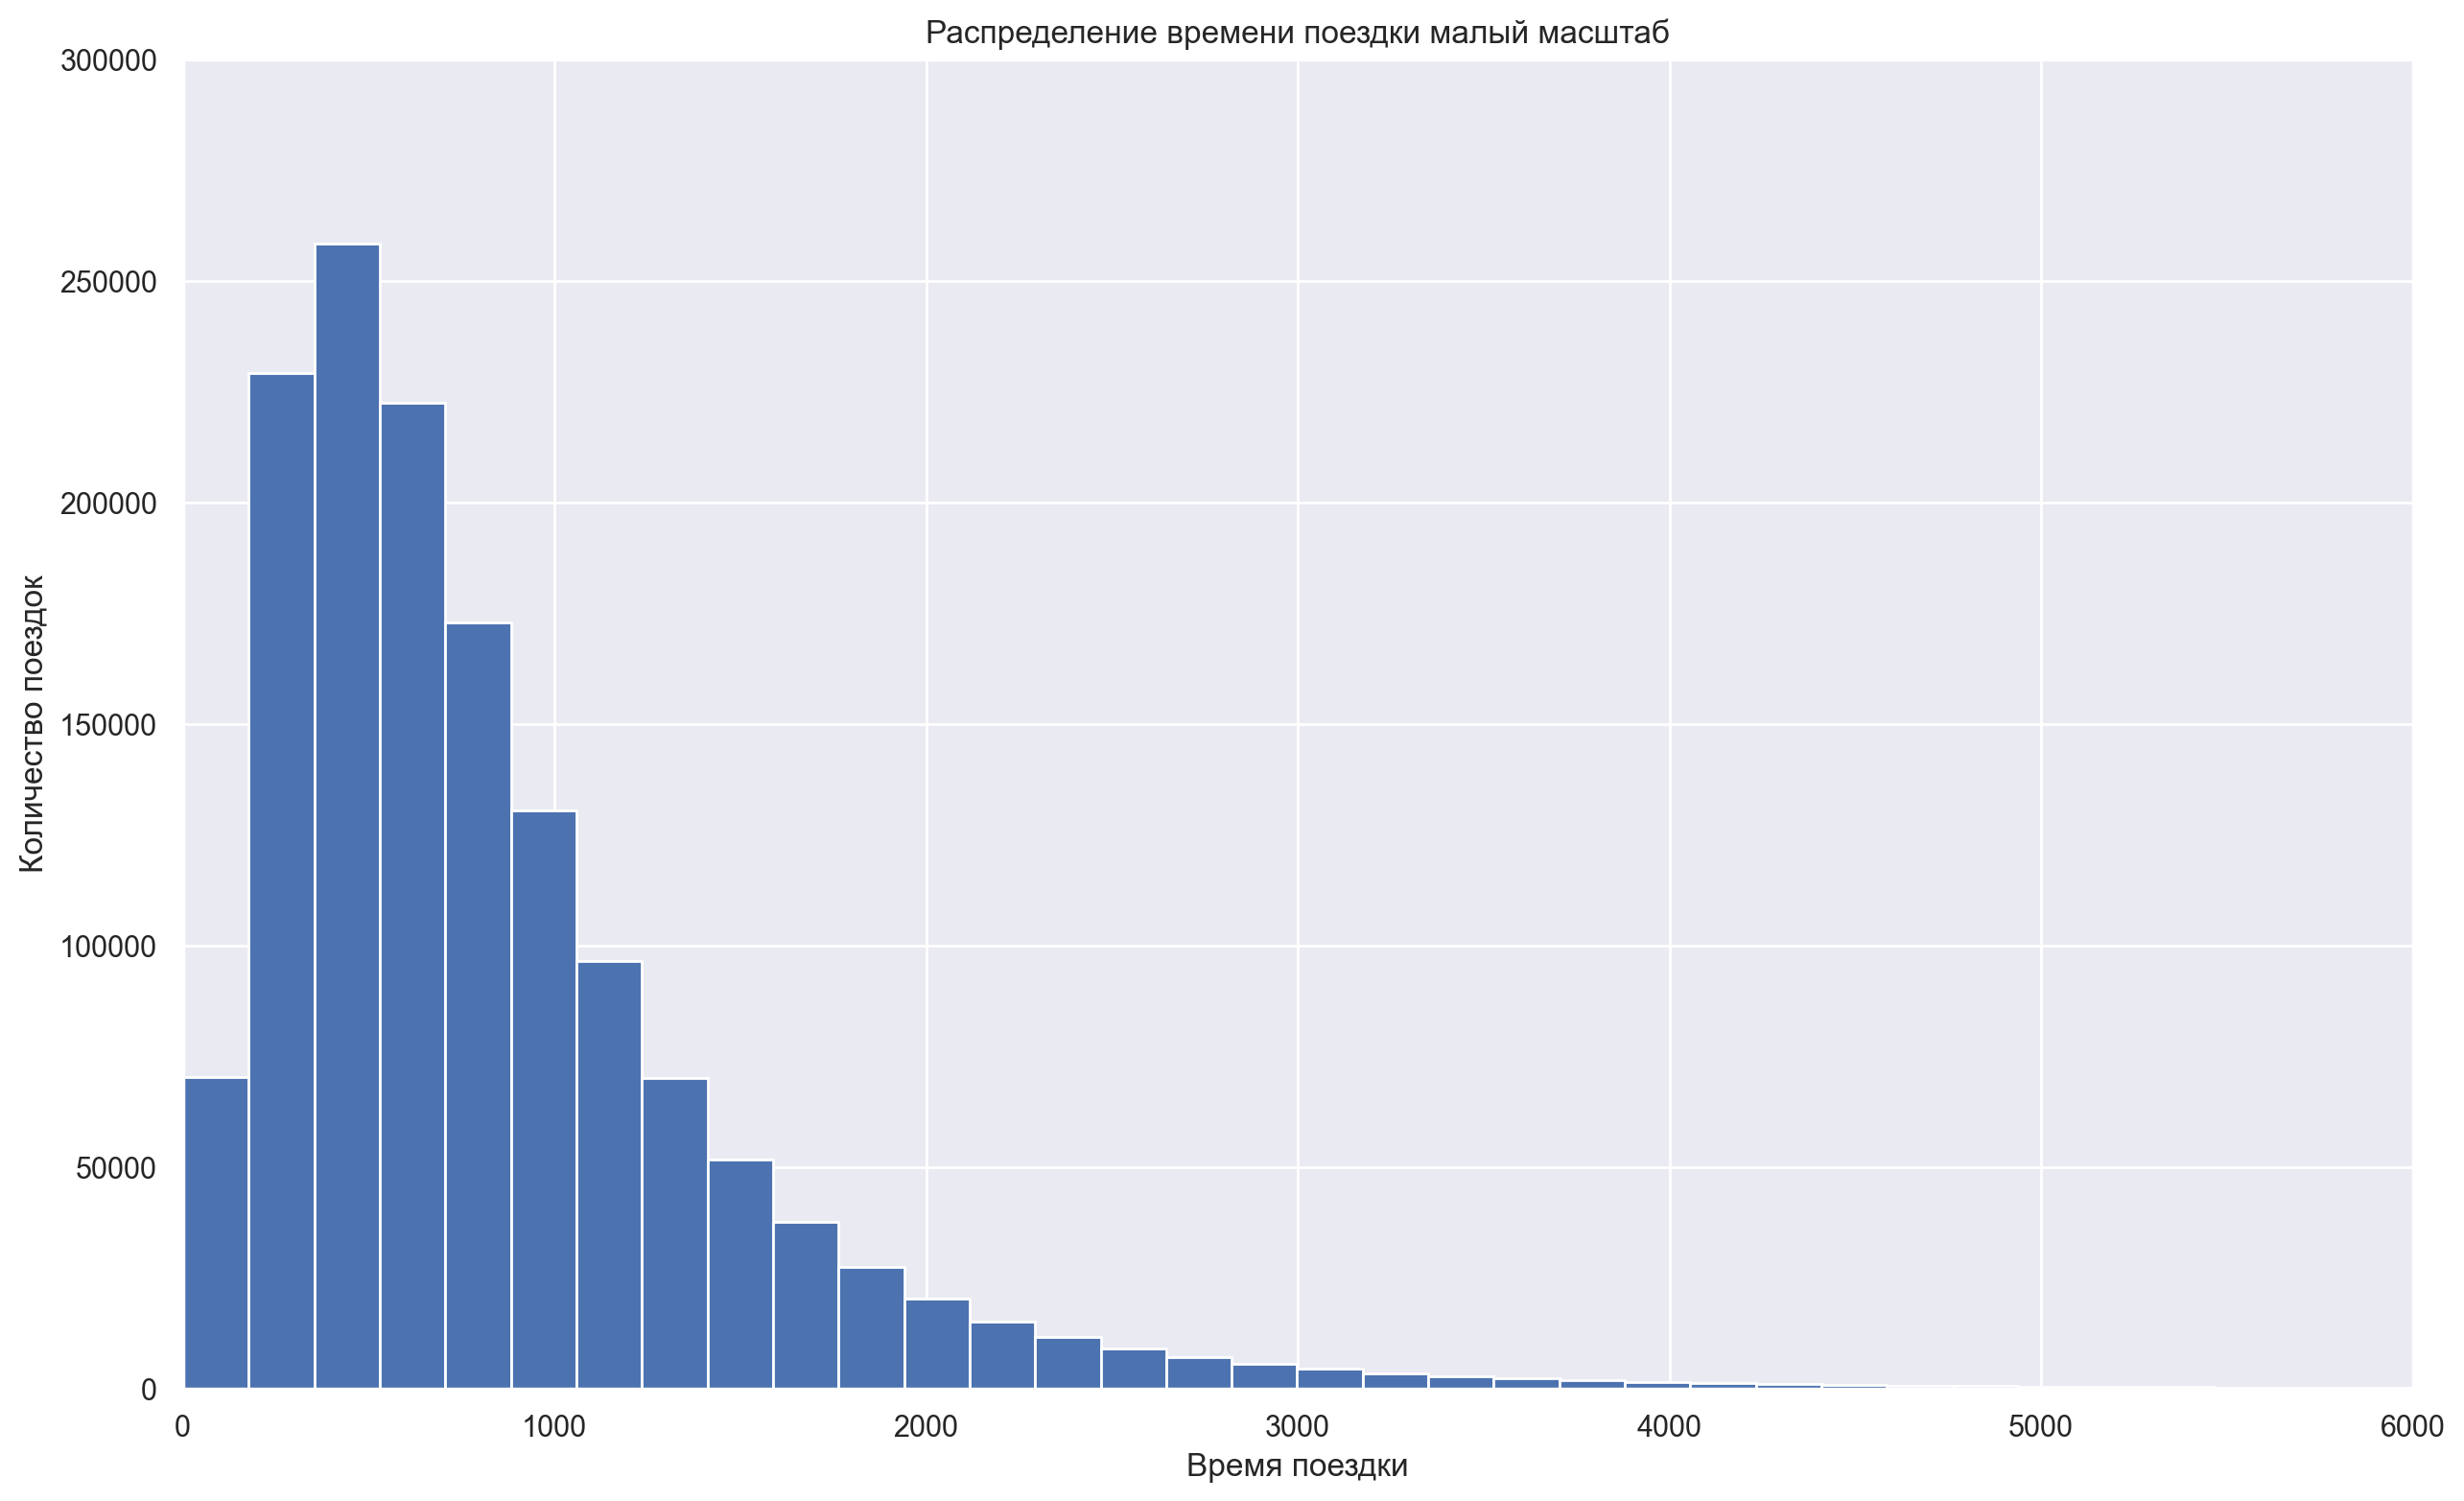

In [8]:
plt.hist(df['trip_duration'], bins = 20000)

plt.title('Распределение времени поездки малый масштаб')
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')

plt.xlim(0,6e3)
plt.ylim(0, 3e5)

plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

**Ответ:** По распределению видно, что 
1. есть какие-то экстремальные значения в районе 80-90к секунд, что примерно 24ч. Это могут быть какие-то выбросы(сбой) или возможно это поездки в соседние города/штаты, тк все-таки там не одна-две поездки, а чуть менее 2 тысяч
2. В адекватном диапазоне поездок распределение очень похоже на логнормальное

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

**Ответ:** Самое простое, что приходит в голову - логнормальное распределение таргета :)
Кроме этого, я нашел [статью](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a), в которой говорилось, про 3 важные особенности RMSLE по сравнению с RMSE:
1. RMSLE менее чувствительна к выбросам, тем самым меньше на них оринетируется
2. RMSLE показывает относительную ошибку предсказанного таргета относительно фаткического
3. RMSLE больше штрафует за недооцененные модели, чем за переоценненые. Это особенно важно в такси, т.к. лучше показать клиенту большее время и выполнить заказ быстрее, чем показать меньшее и опоздать. По большей части из-за этой особенности была выбрана метрика RMSLE, как мне кажется

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.
 
**Доказательство**: Логарифм это монотонная функция. Поэтому из минимизации RMSE будет следовать минимизация RMSLE и наоборот. Другими словами мы можем сравнивать наши модели, используя RMSLE, т.к. эта метрика упорядочит модели, также как RMSE. Такая же логика для сравнения RMSE и MSE - корень это монотонная функция.

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [9]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])
df = df.drop('trip_duration', axis=1)

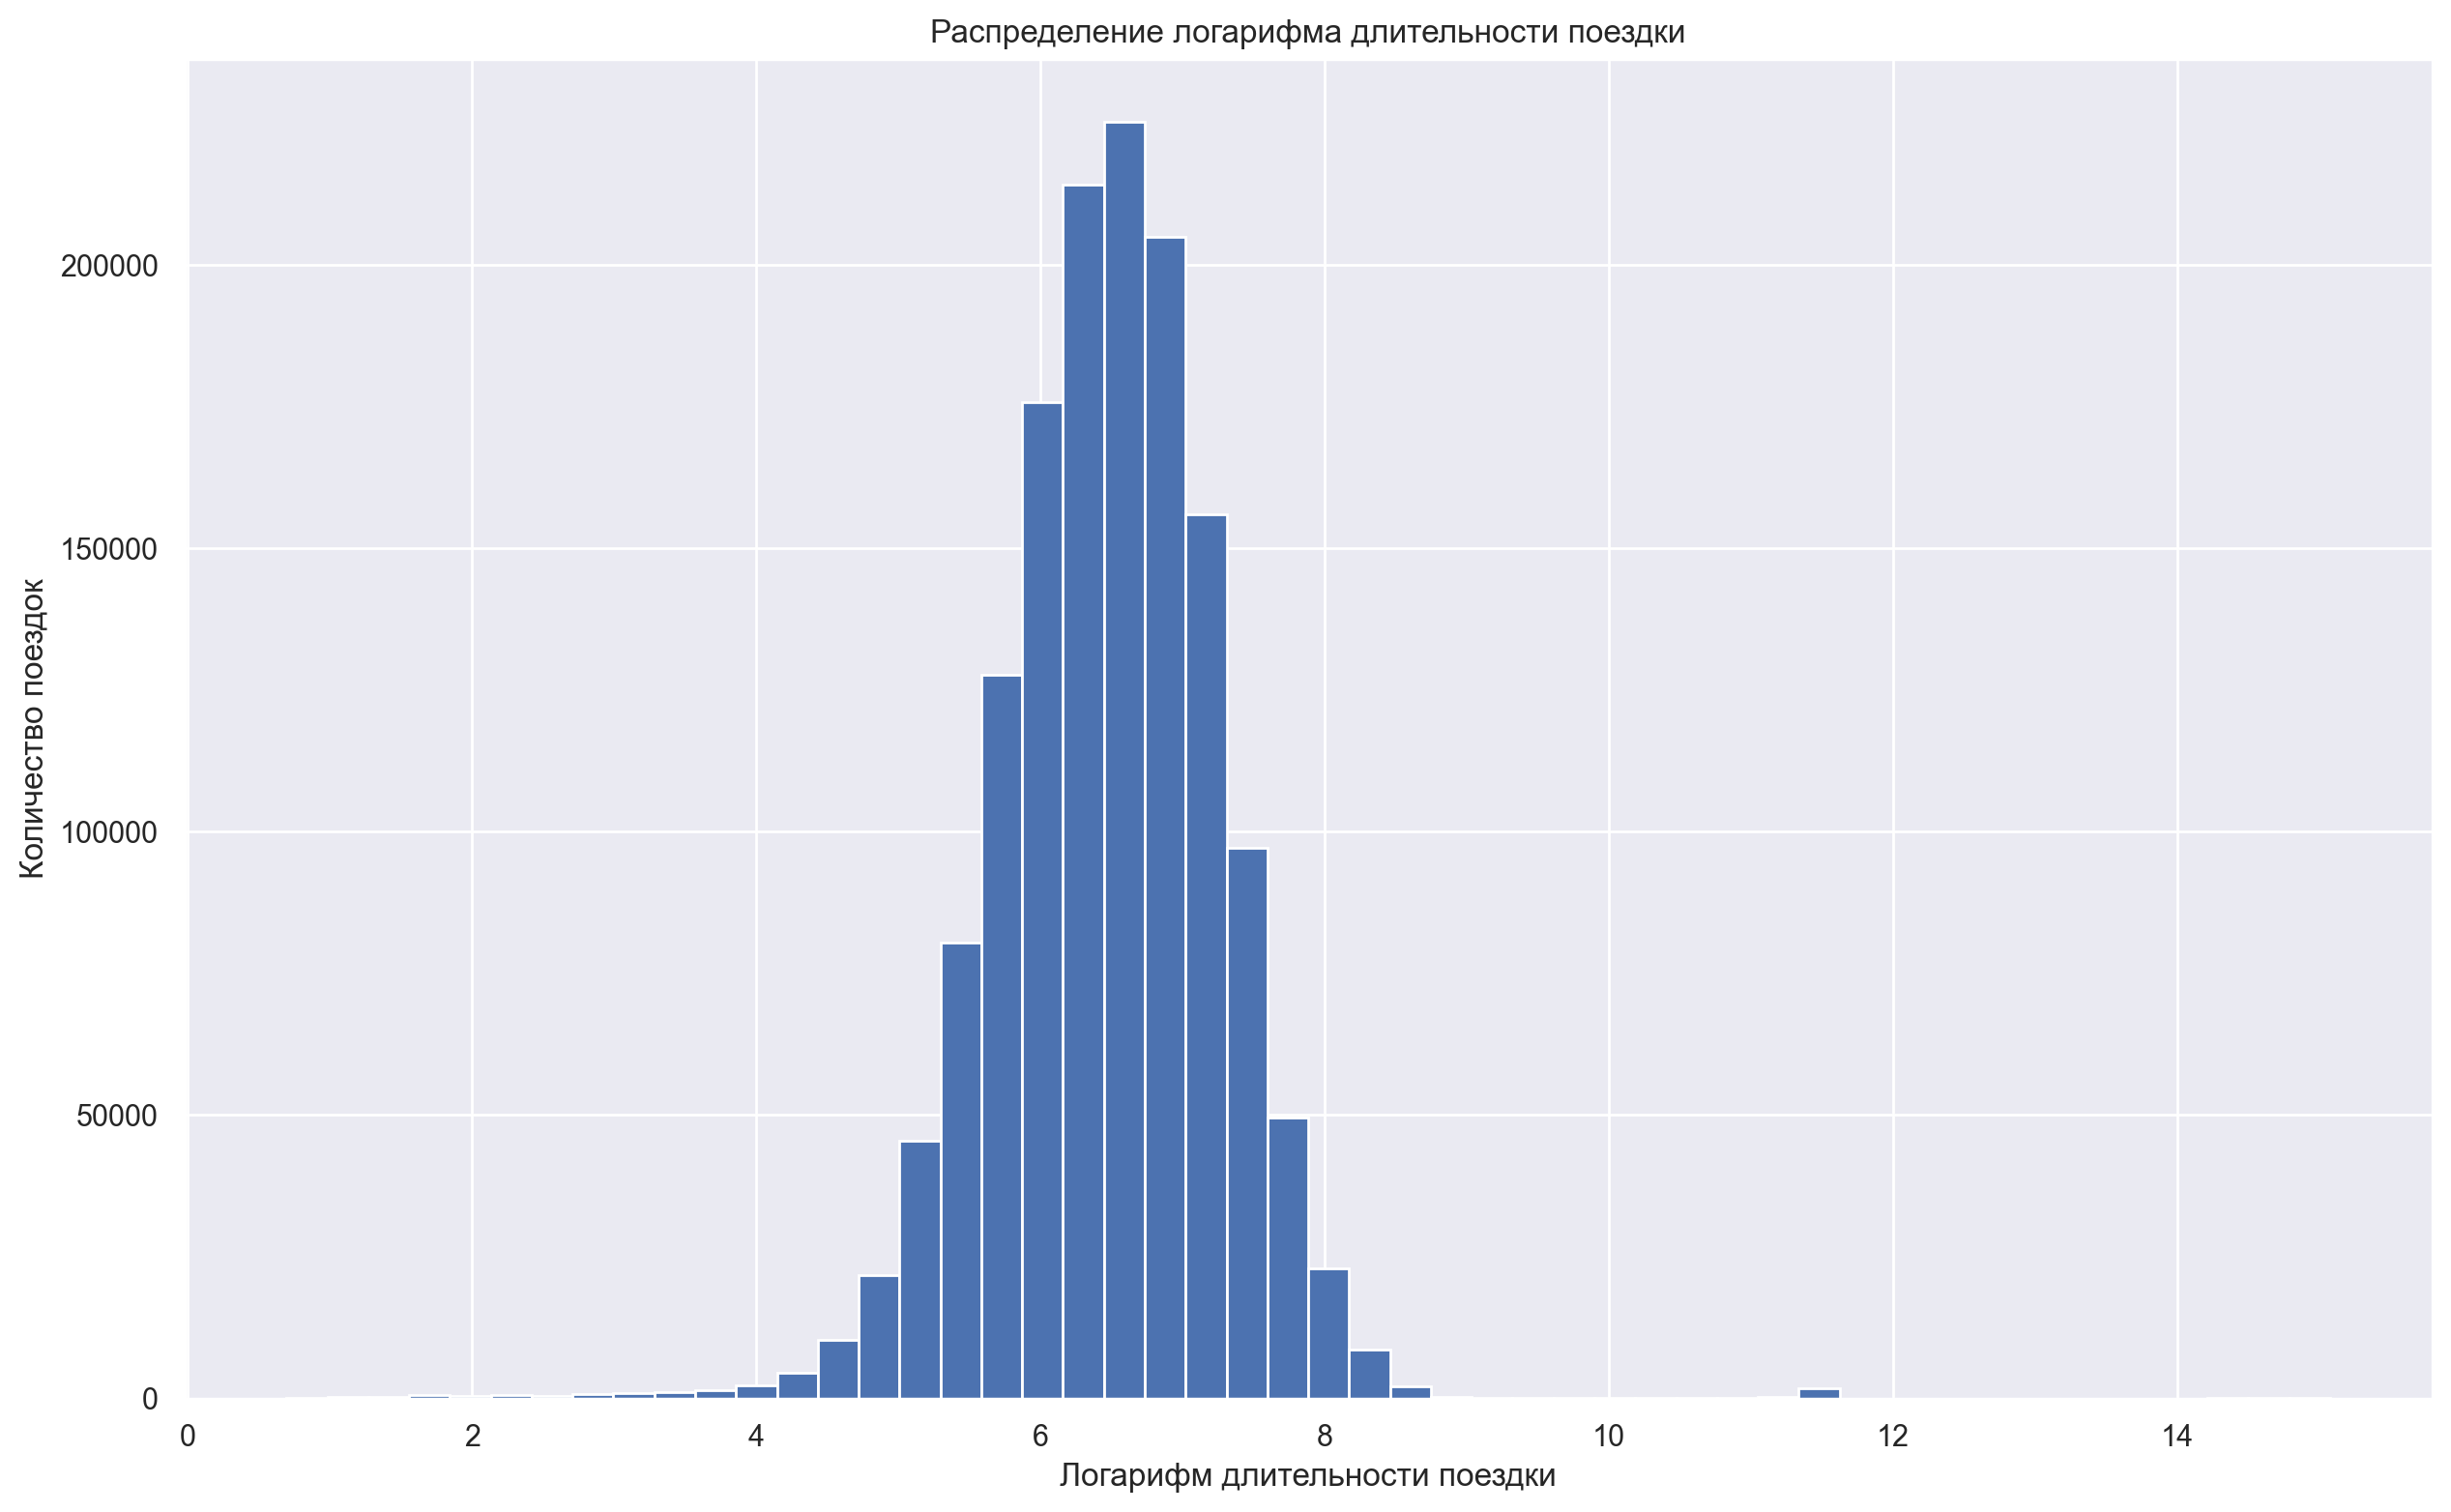

In [10]:
plt.hist(df['log_trip_duration'], bins=50)

plt.title('Распределение логарифма длительности поездки')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Количество поездок')

plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
y_true = df['log_trip_duration']
y_mean = [np.mean(df['log_trip_duration'])] * df.shape[0]
print("MSE = %.4f" % mean_squared_error(y_true, y_mean))

MSE = 0.6332


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

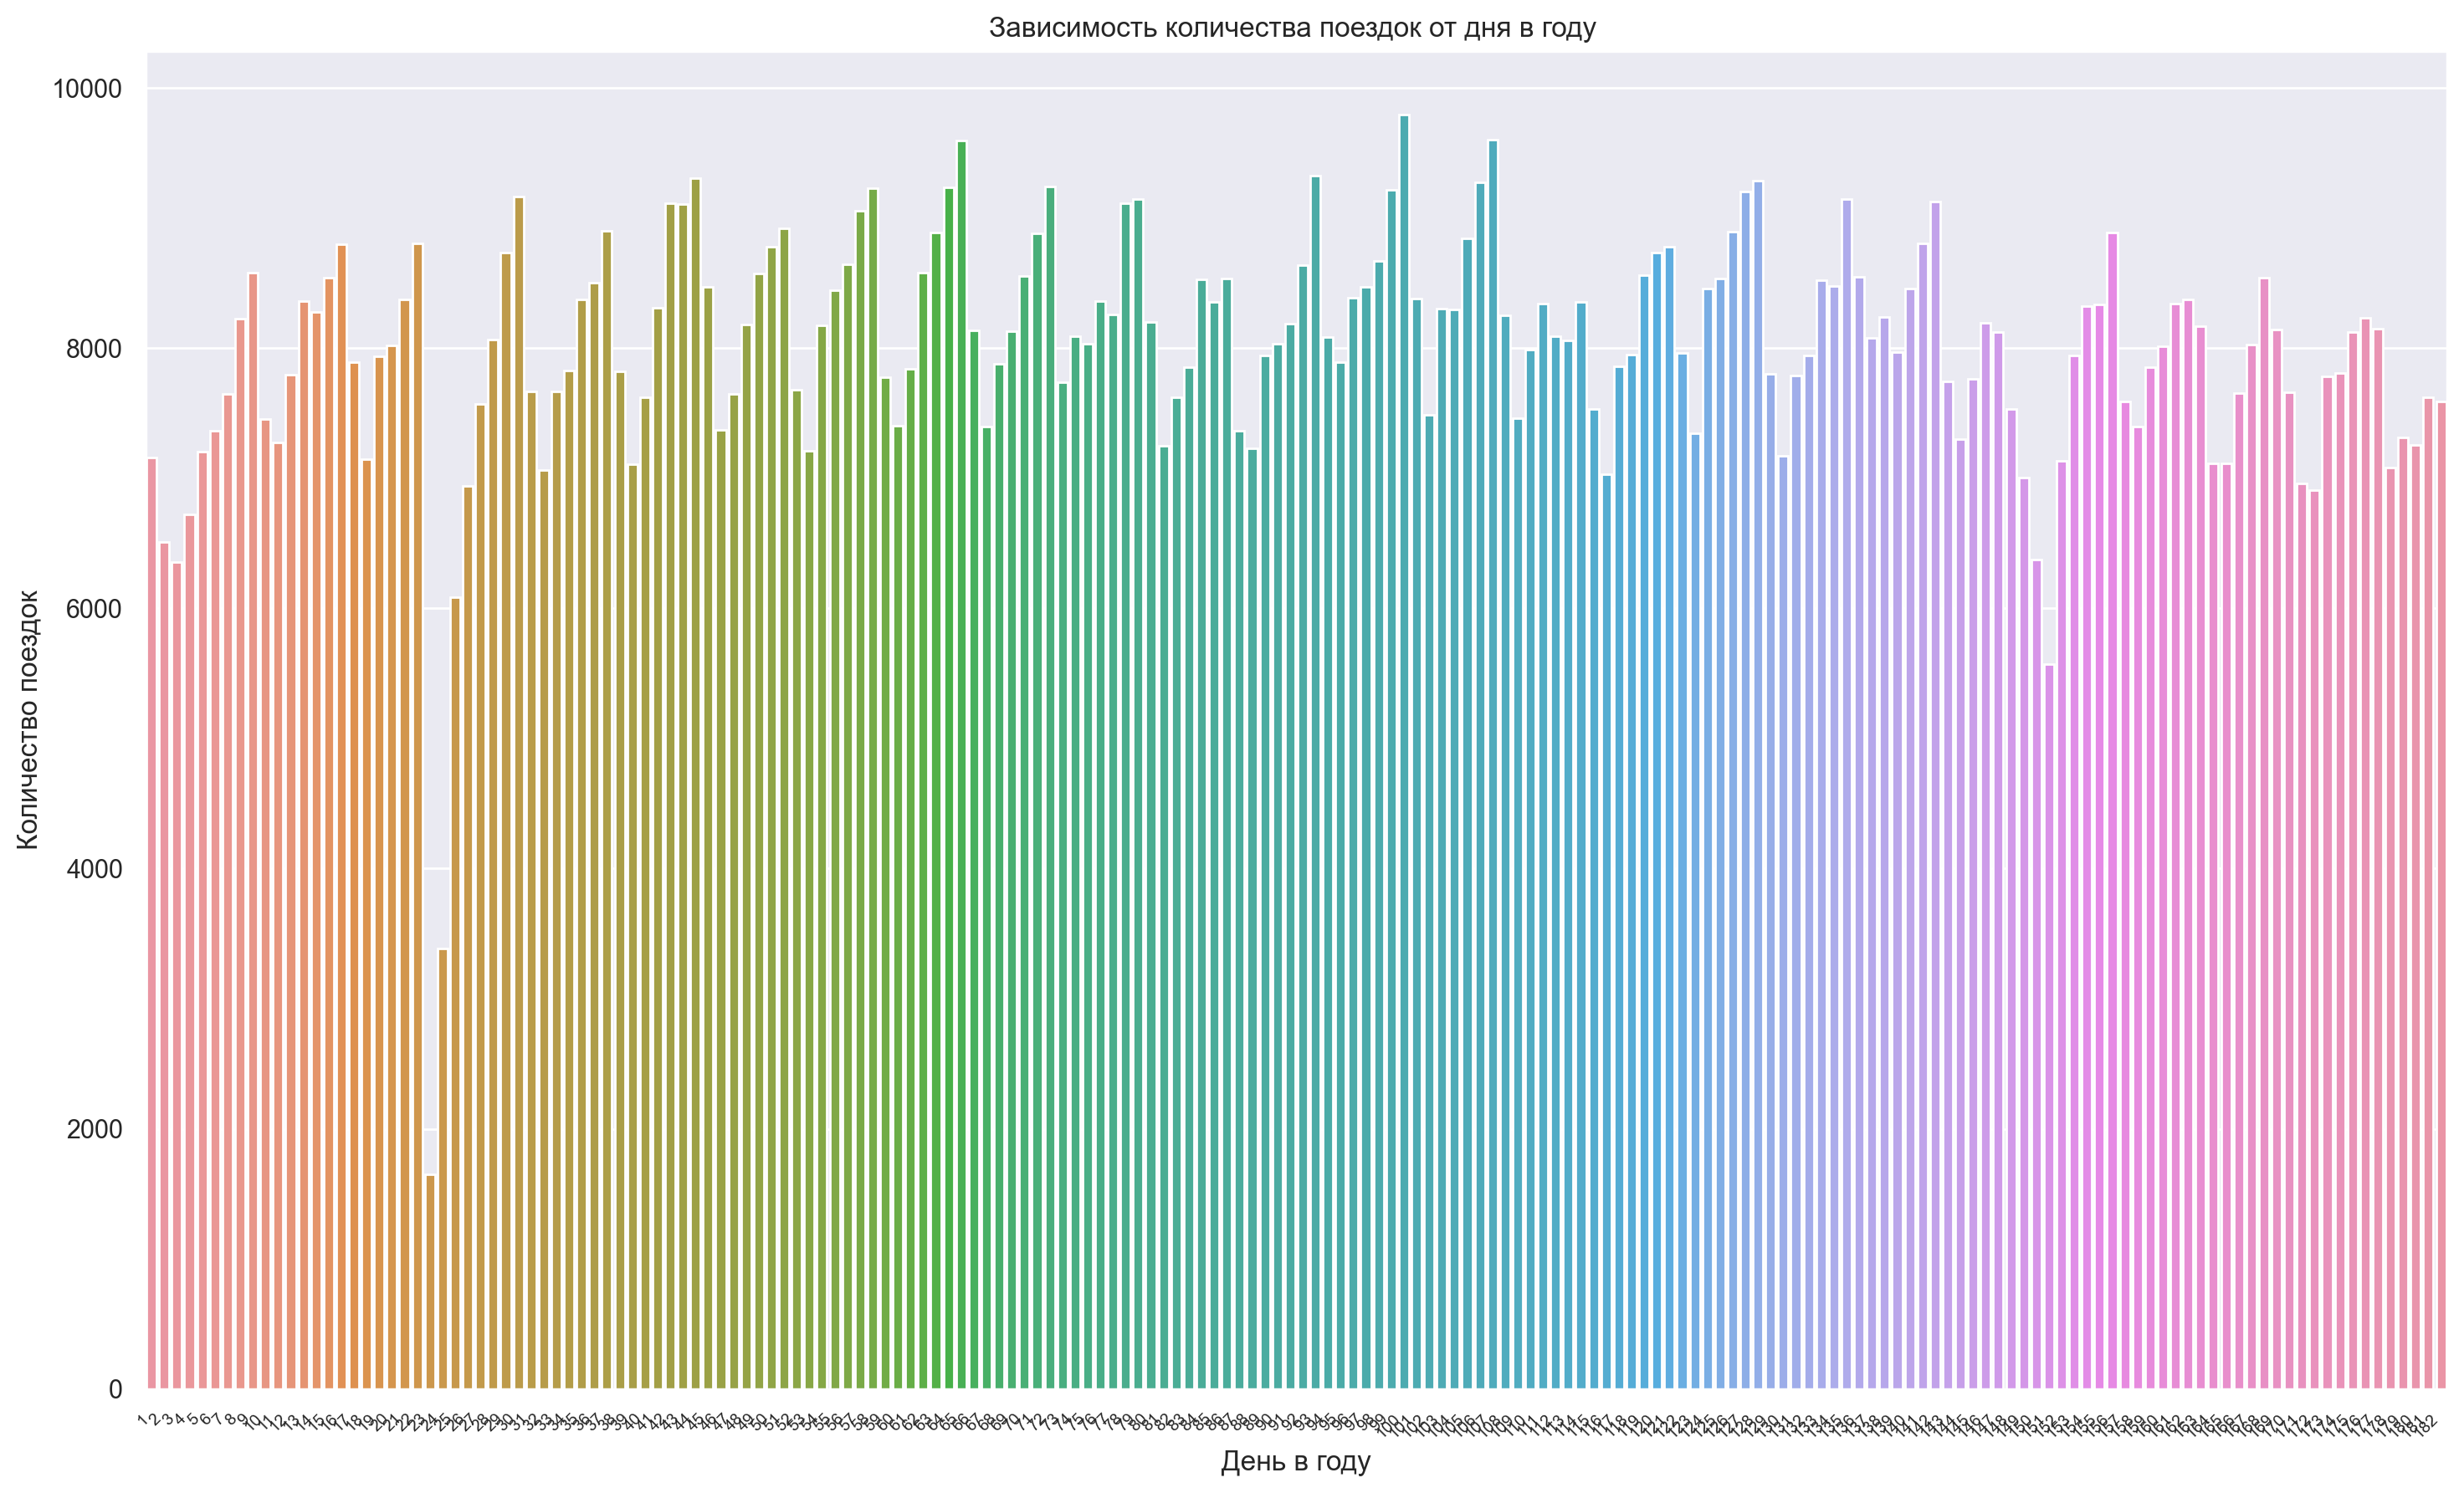

In [13]:
day = df['pickup_datetime'].dt.dayofyear.sort_values()
ax = sns.countplot(x=day)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, ha="right")
plt.tight_layout()

plt.title('Зависимость количества поездок от дня в году ')
plt.xlabel('День в году')
plt.ylabel('Количество поездок')

plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [14]:
df['pickup_date'] = df['pickup_datetime'].dt.to_period('D') #создаем столбец с датой
print(df.groupby('pickup_date').id.count().reset_index().sort_values(by='id').head(5)) #группирую по дате и считаю число поездок
df = df.drop('pickup_date', axis=1)

    pickup_date    id
22   2016-01-23  1648
23   2016-01-24  3383
150  2016-05-30  5570
24   2016-01-25  6084
2    2016-01-03  6353


скачки были в январе и в мае  
23-24 января 2016 в Нью-Йорке была [буря](https://ria.ru/20160123/1364032228.html)
30 мая была [стрельба](https://tass.ru/proisshestviya/3324970) и [сбой компьютера в аэропорту](https://www.interfax.ru/world/510698) это маловато связано с такси, но больше я не нашел)

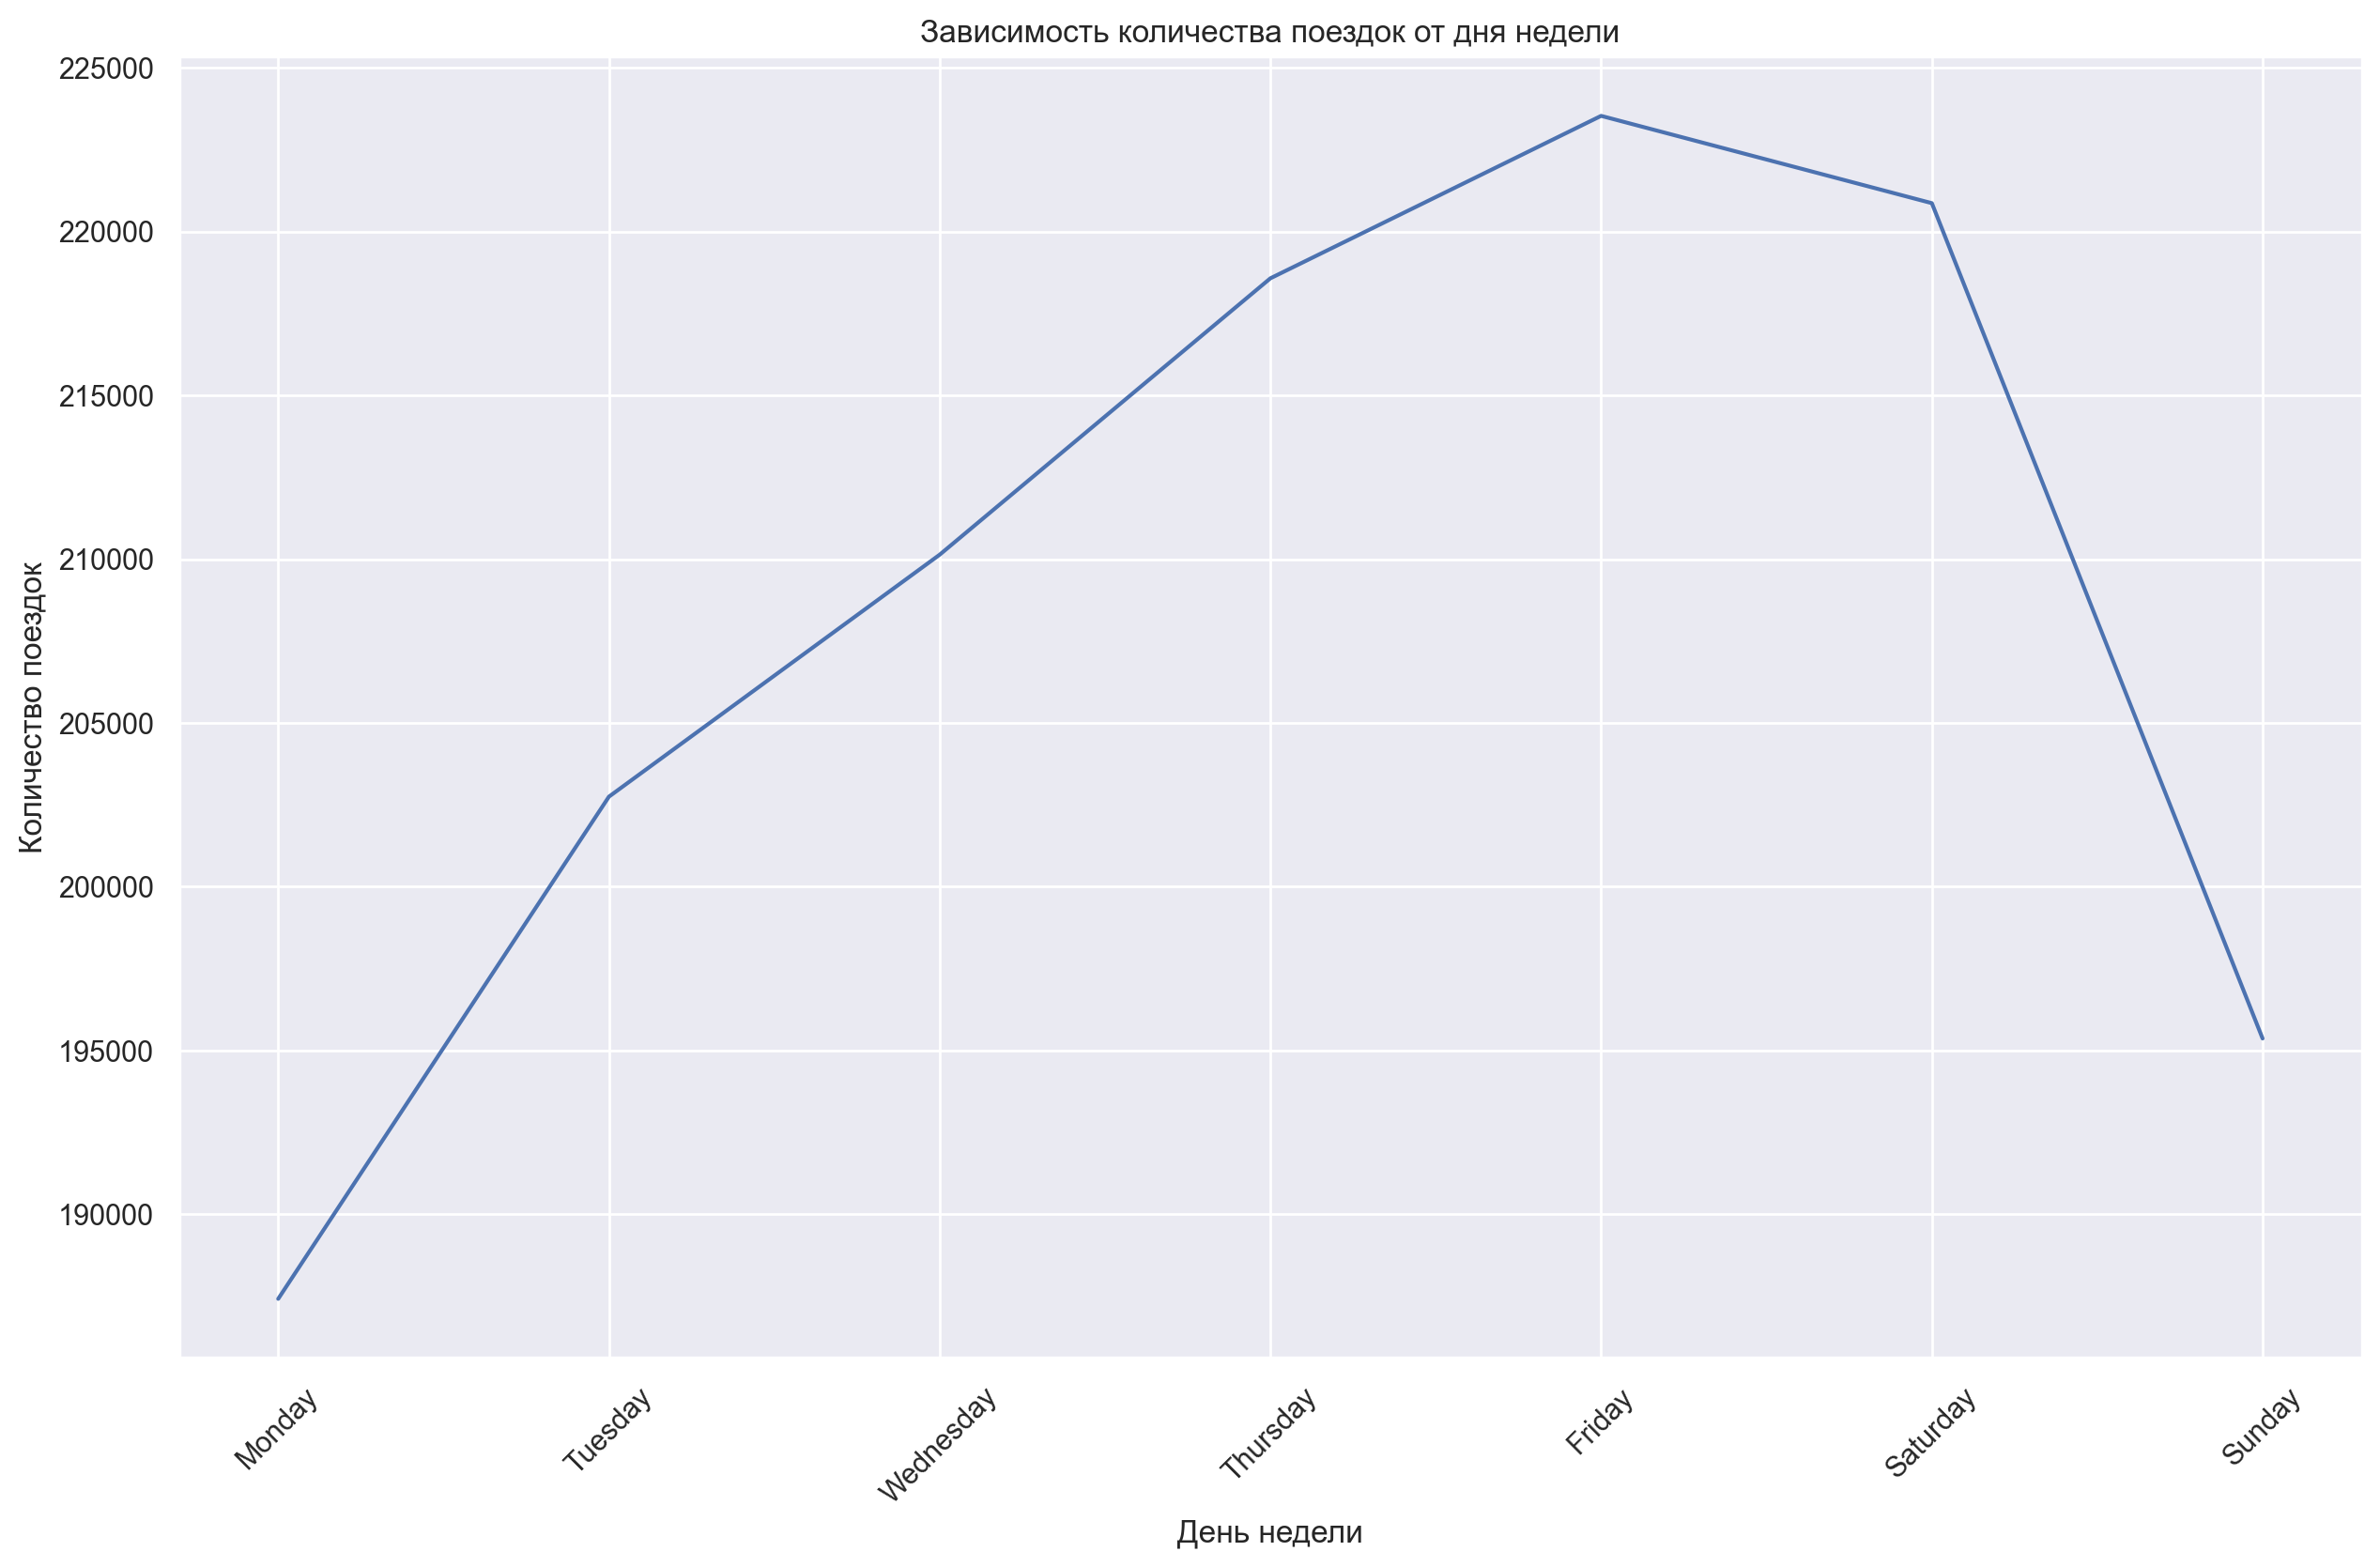

In [15]:
draw_week = df.groupby(df['pickup_datetime'].dt.dayofweek).id.count().reset_index().sort_values('pickup_datetime')

sns.lineplot(data=draw_week, x='pickup_datetime', y='id') 
#вместо relplot использовал lineplot, потому что для relplot не применяется figsize, а в остальном они одинаковые

plt.title('Зависимость количества поездок от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')

plt.xticks(np.arange(7), rotation=45, 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

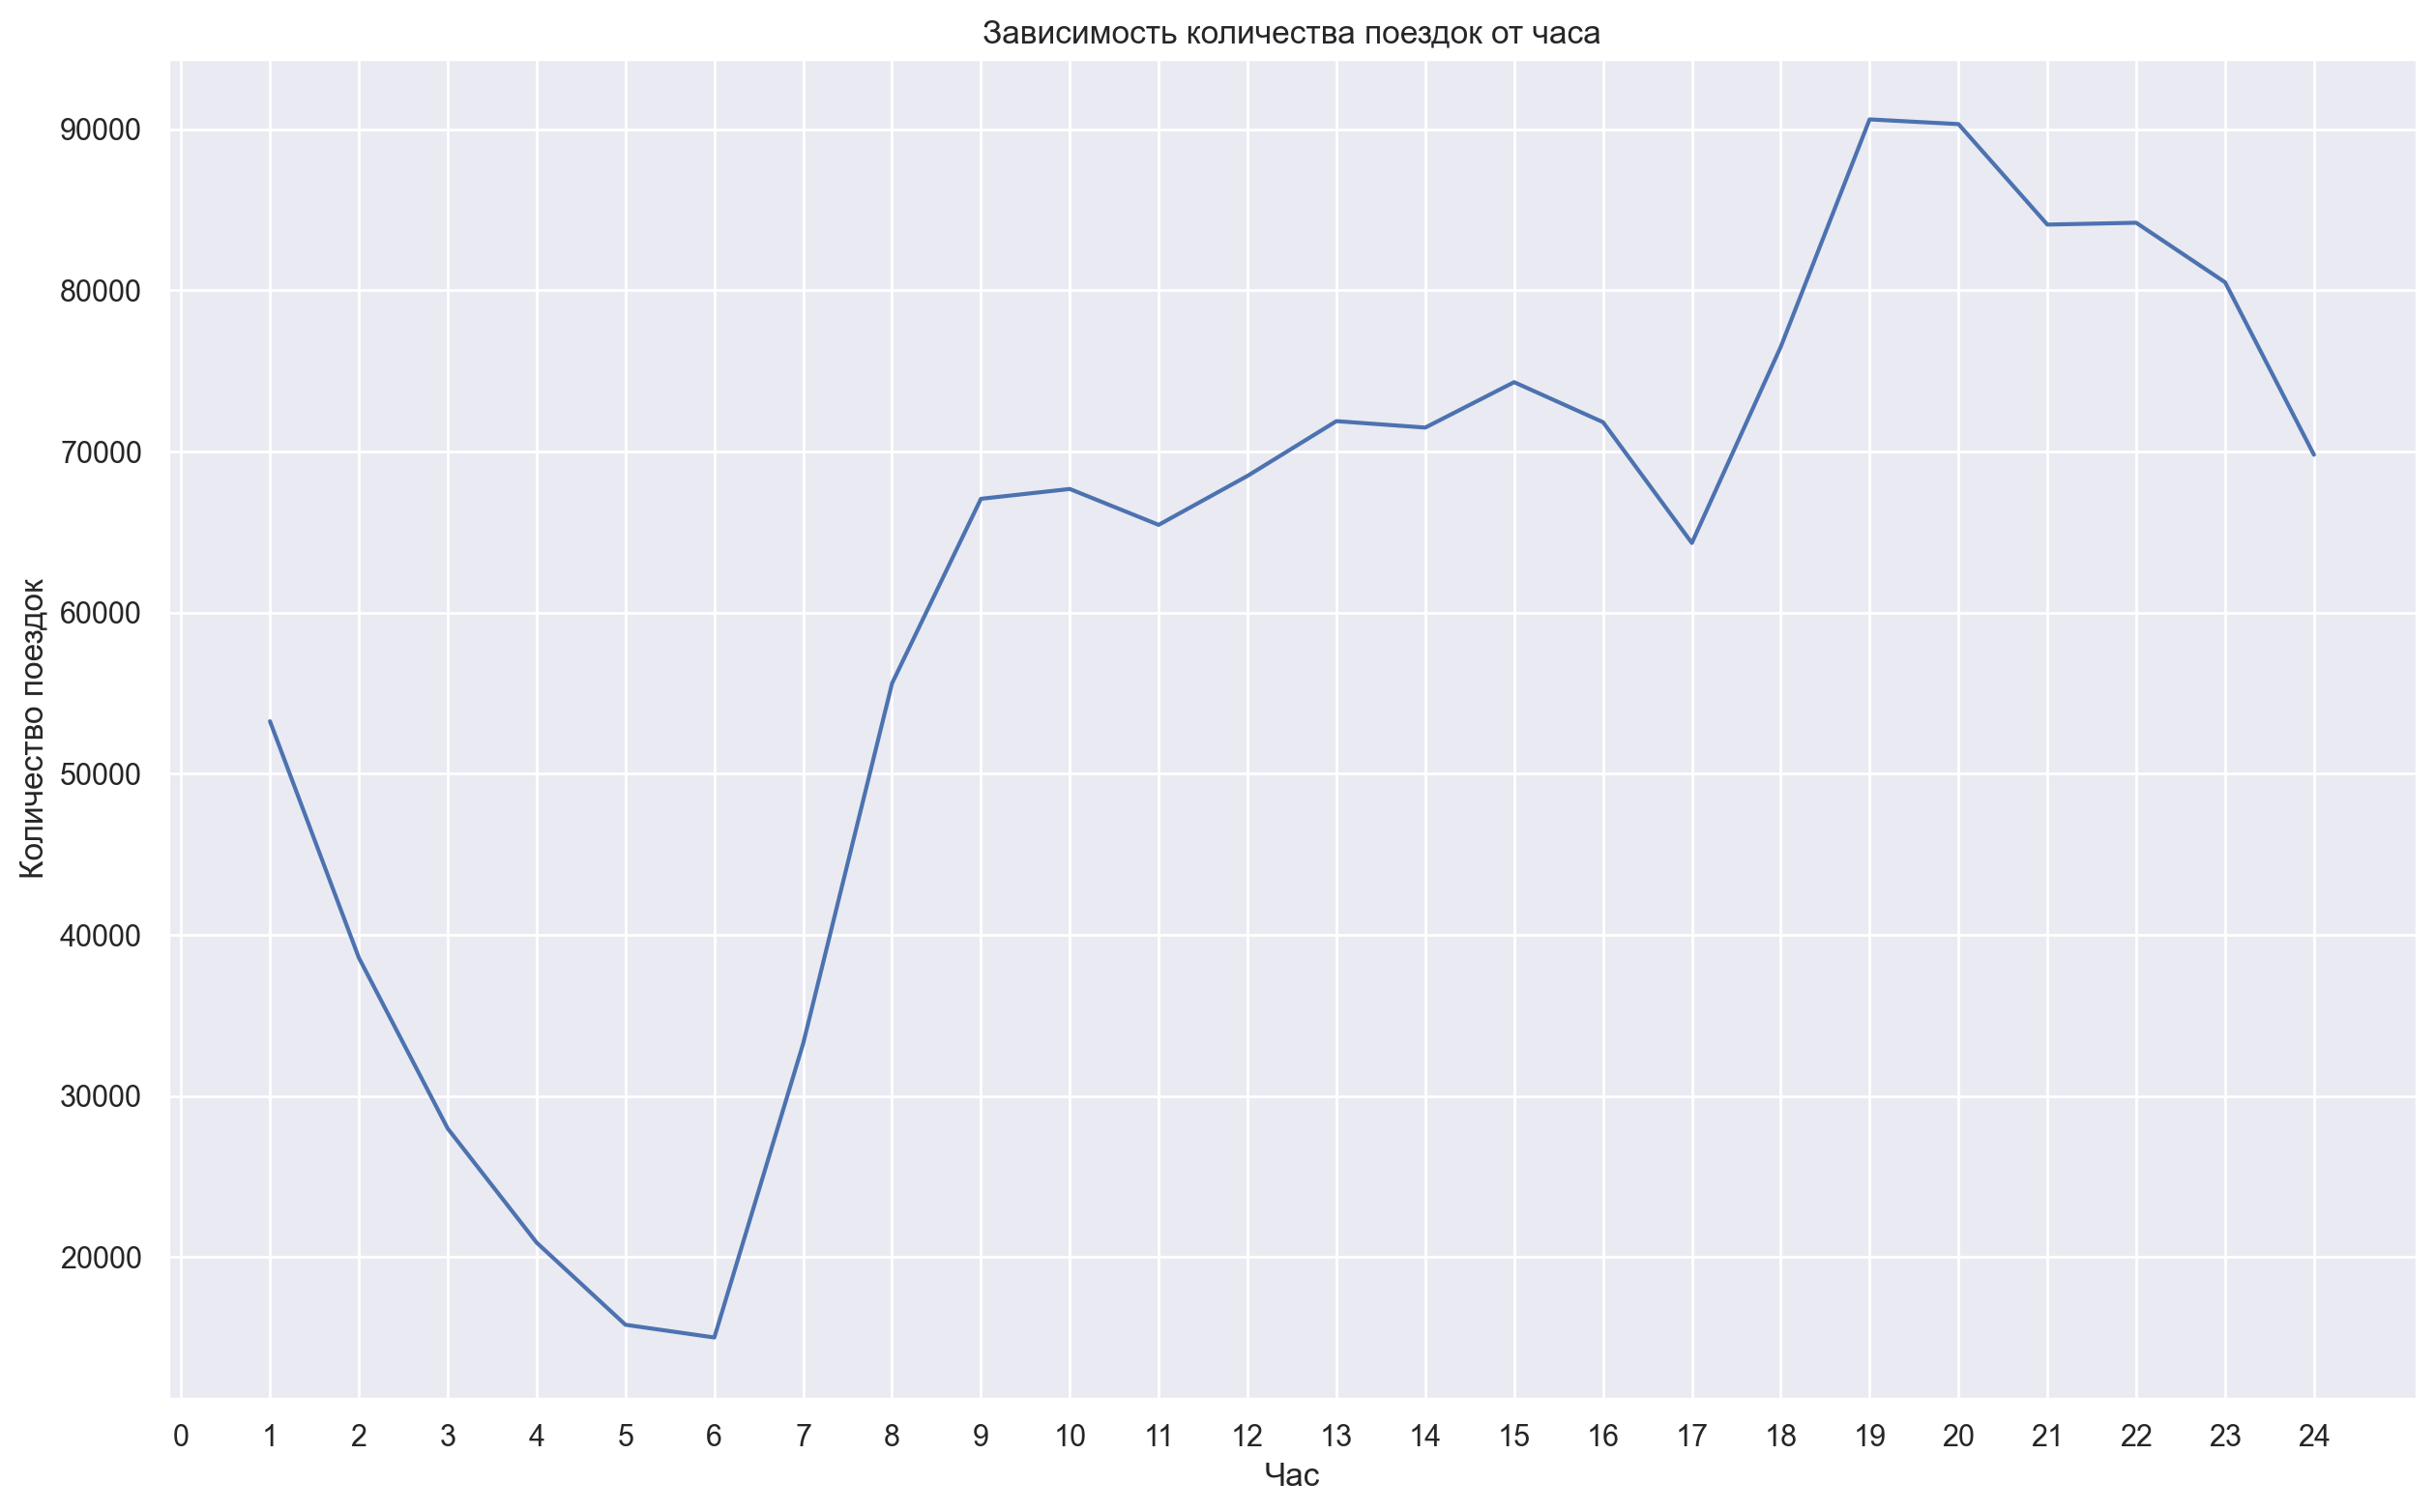

In [16]:
draw_hour = df.groupby(df['pickup_datetime'].dt.hour + 1).id.count().reset_index().sort_values('pickup_datetime')
sns.lineplot(data=draw_hour, x='pickup_datetime', y='id')

plt.title('Зависимость количества поездок от часа')
plt.xlabel('Час')
plt.ylabel('Количество поездок')

plt.xticks(np.arange(25))
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

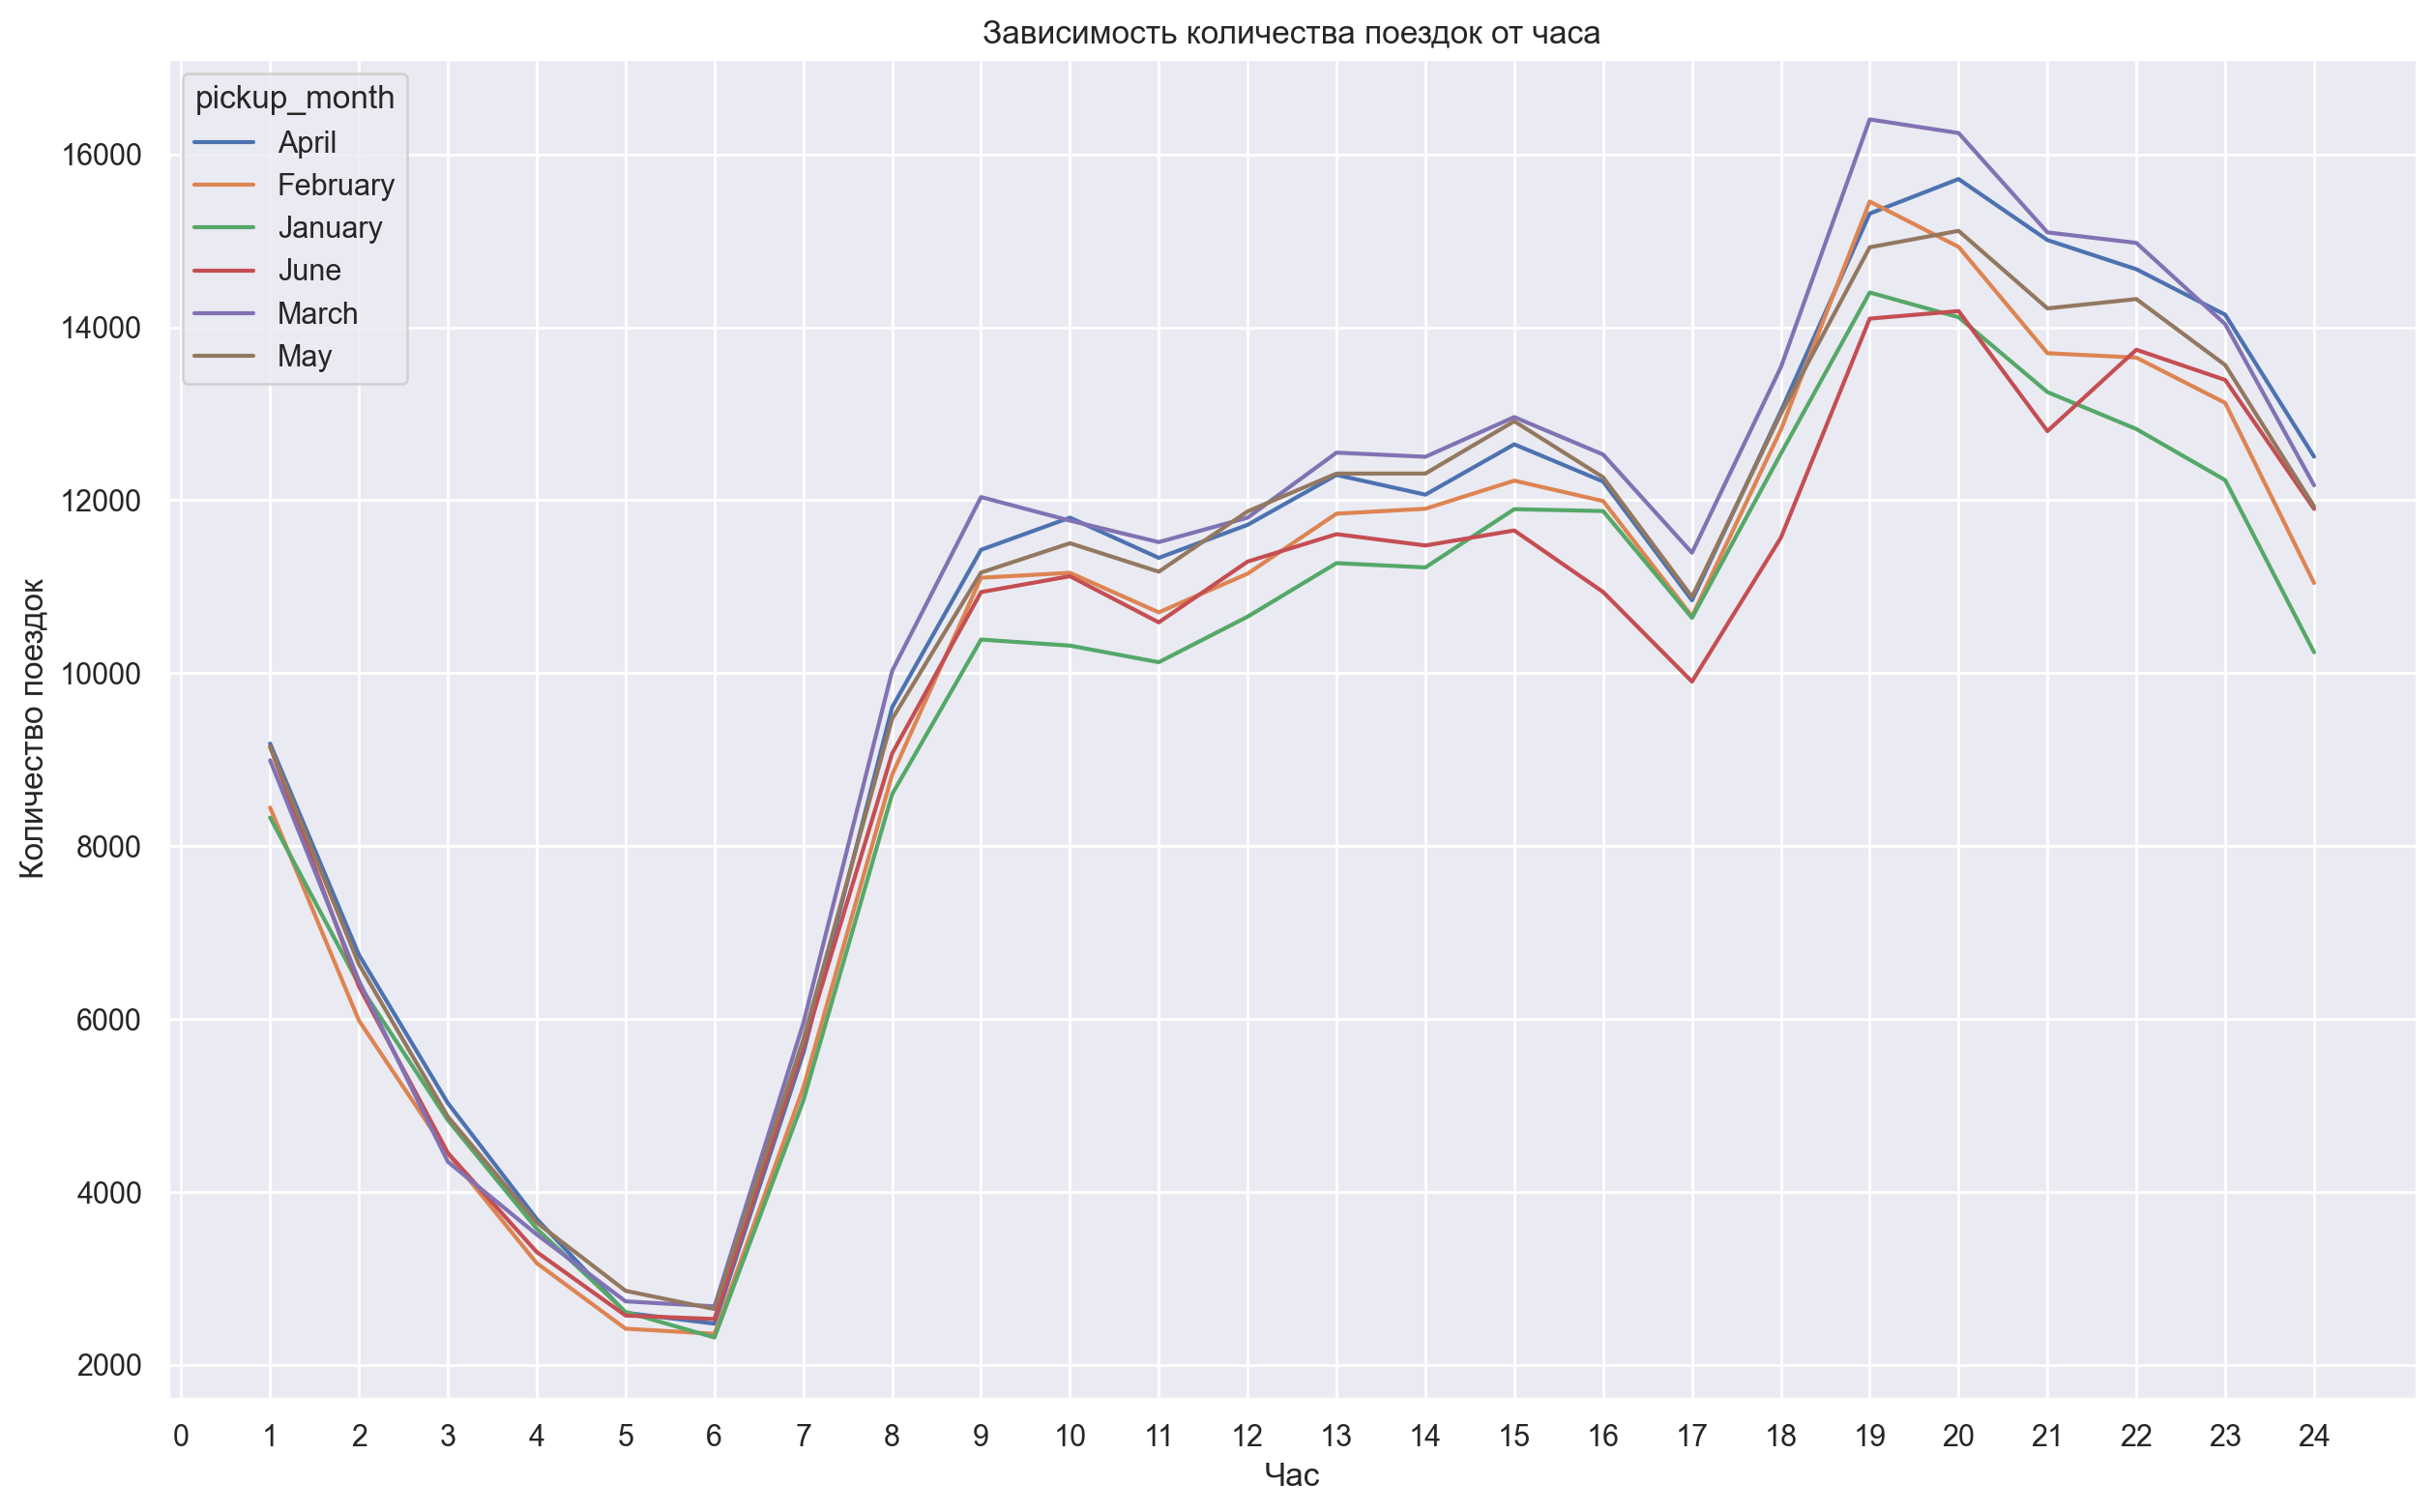

In [16]:
df['pickup_month'] = df['pickup_datetime'].dt.month_name()
df['pickup_hour'] = df['pickup_datetime'].dt.hour + 1

draw = df.groupby([df['pickup_month'], df['pickup_hour']]).count().reset_index()

sns.lineplot(data=draw, x='pickup_hour', y='id', hue='pickup_month')

plt.title('Зависимость количества поездок от часа')
plt.xlabel('Час')
plt.ylabel('Количество поездок')

plt.xticks(np.arange(25))

df = df.drop(['pickup_month', 'pickup_hour'], axis=1)
plt.show()

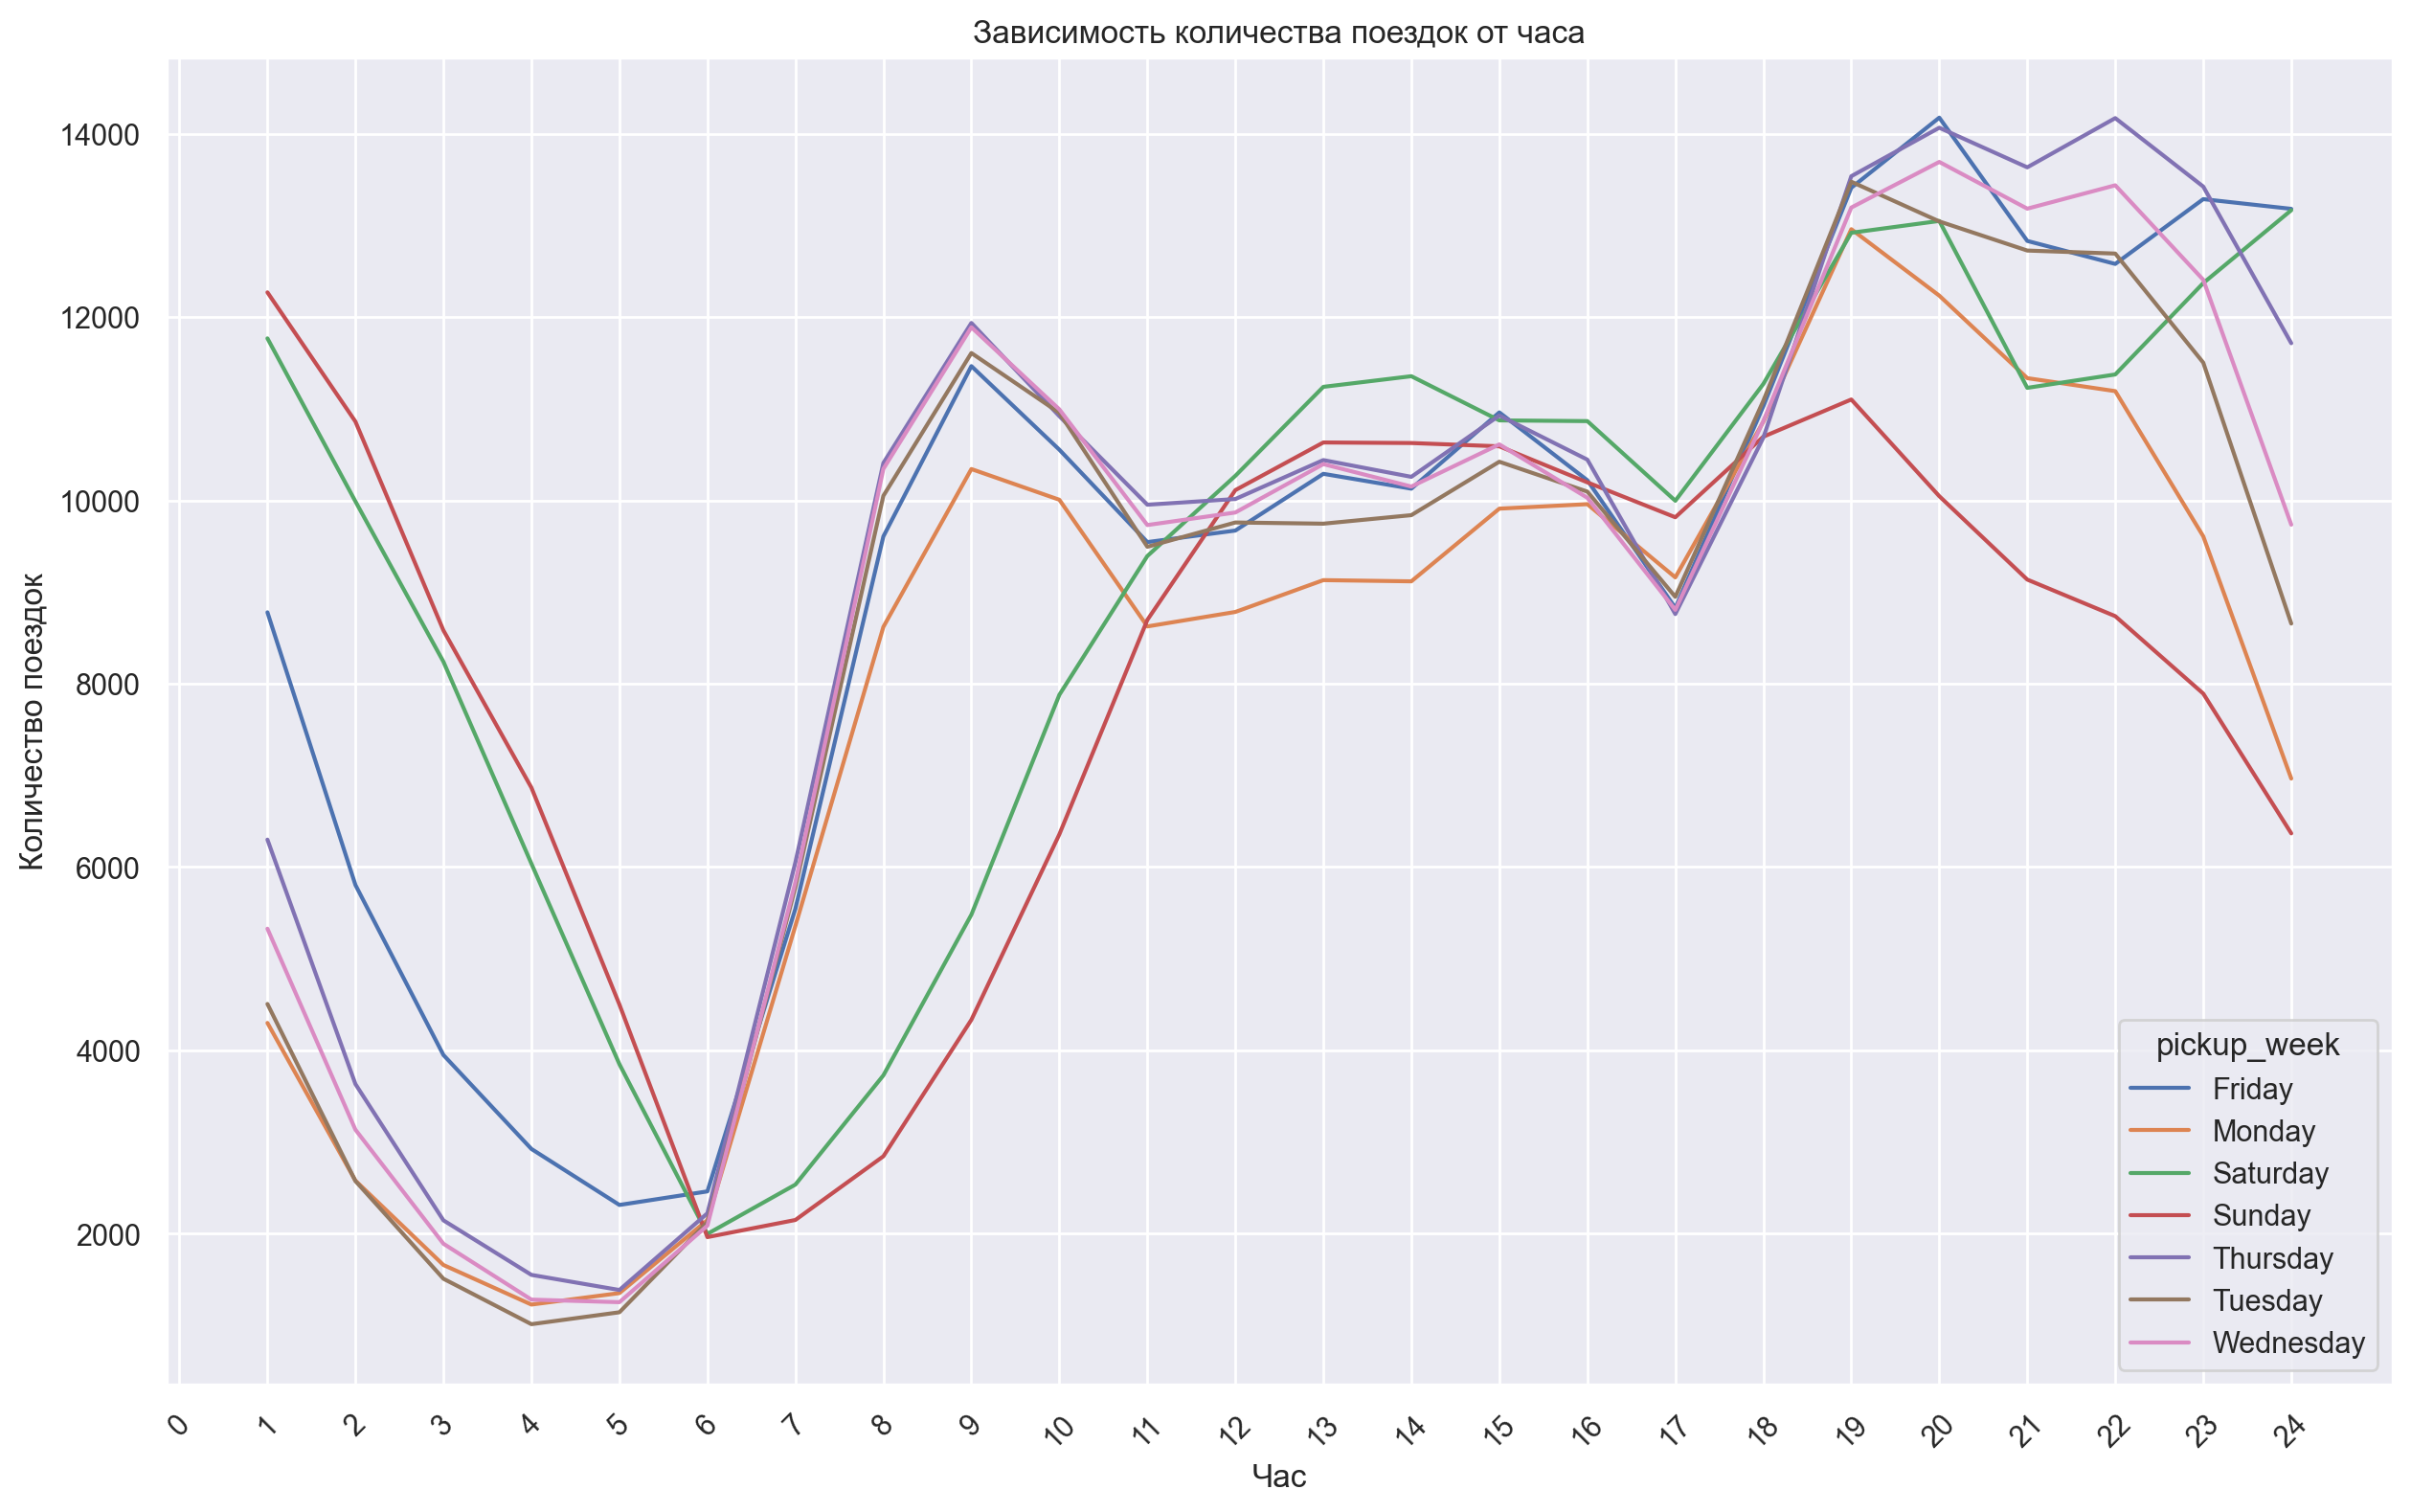

In [18]:
df['pickup_week'] = df['pickup_datetime'].dt.day_name()
df['pickup_hour'] = df['pickup_datetime'].dt.hour + 1

draw = df.groupby([df['pickup_week'], df['pickup_hour']]).count().reset_index()

sns.lineplot(data=draw, x='pickup_hour', y='id', hue='pickup_week')

plt.title('Зависимость количества поездок от часа')
plt.xlabel('Час')
plt.ylabel('Количество поездок')

plt.xticks(np.arange(25), rotation=45)

df = df.drop(['pickup_week', 'pickup_hour'], axis=1)
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Ответ:**  
Можно сделать следующие выводы:
1. Больше всего поездок совершается в пятницу, а меньше всего в понедельник. При этом кол-во поездок на протяжении рабочей недели увеличивается, а в выходные падает. Видимо к концу недели люди устают ездить на общественном транспорте:)
2. По часам, если смотреть в разбивке по дням недели, то можно сделать вывод, что больше всего активность поднимается утром с 8 до 10 и вечером с 19 до 21 в рабочие дни. Эт логично, тк люди едут на работу и с работы. В выходные люди реже пользуются такси и позже поднимается активность. При этом активность примерно постоянн с 12 до 18. В отличие от будней нет пиков с утра и вечером. Но в выходные много заказов ночью 1-2. Это может быть связано с тем, что люди ездят развлекаться
3. Самые непопулярные месяцы для такси - это июнь и январь, а самый популярный - март

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

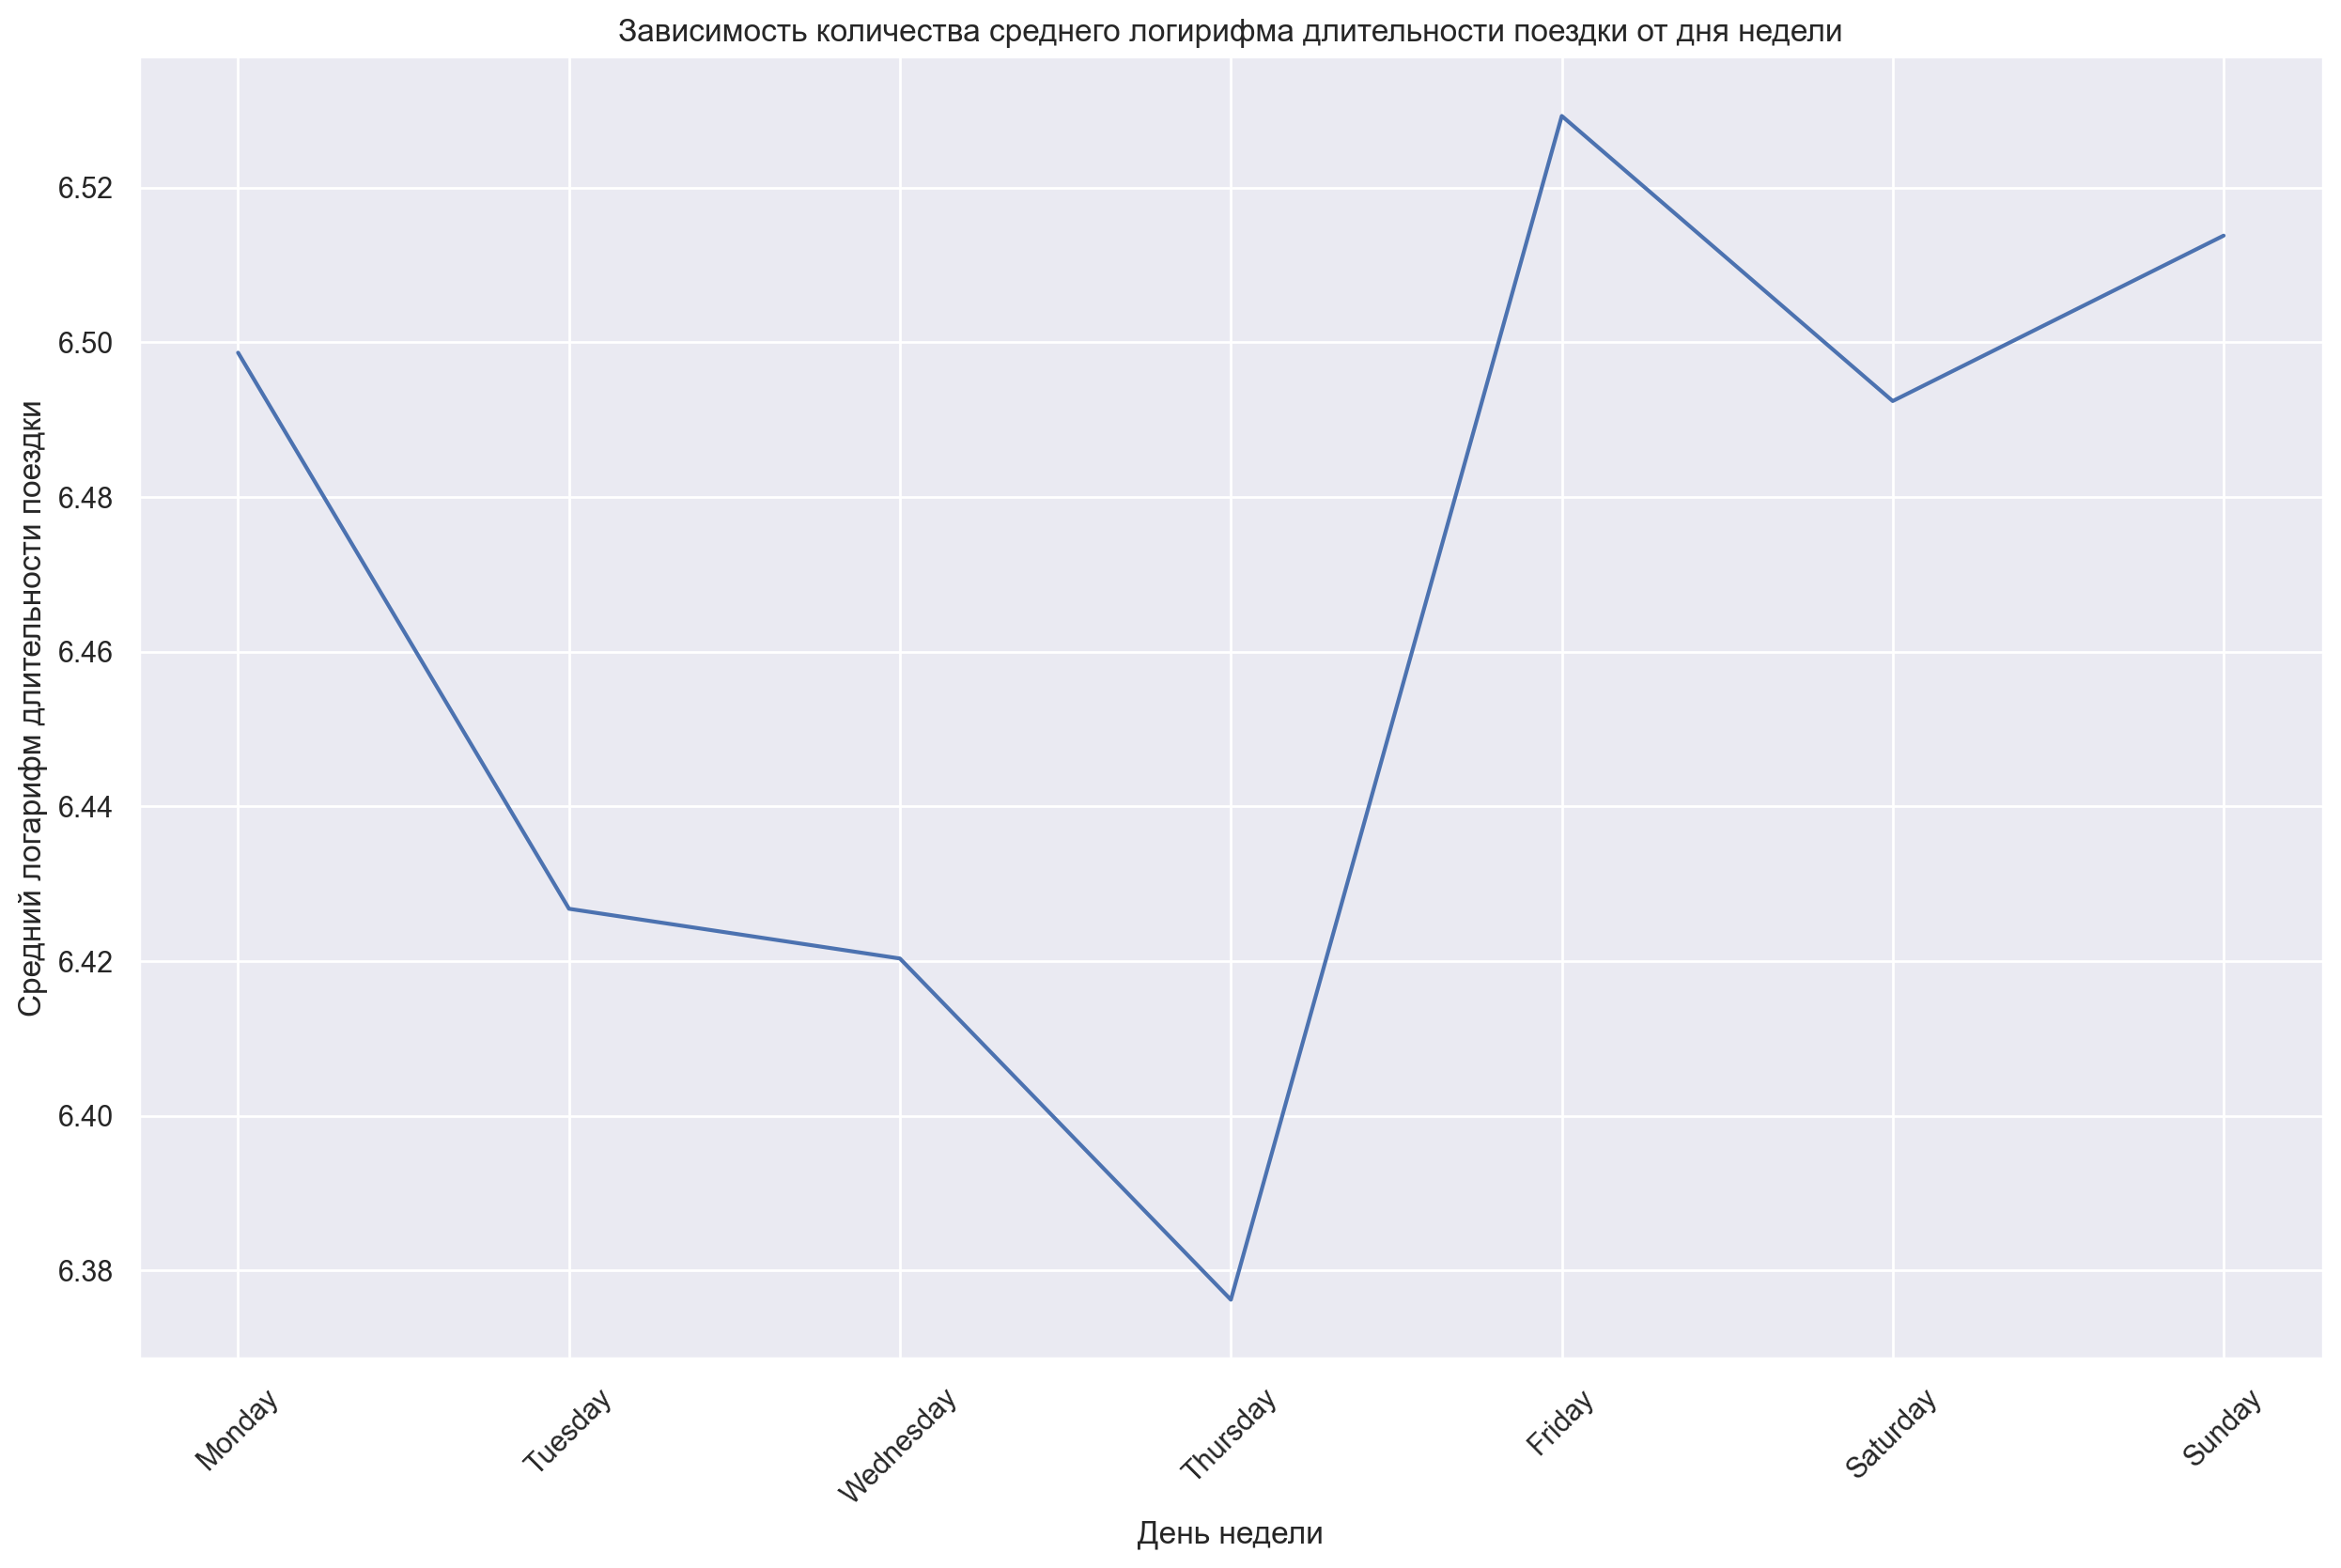

In [18]:
X_train['pickup_week'] = X_train['pickup_datetime'].dt.day_name() #создаю столбец с днем недели
draw = X_train.groupby('pickup_week').log_trip_duration.mean().reset_index() #аггрегирую 

sns.lineplot(data=draw, x='pickup_week', y='log_trip_duration')

plt.title('Зависимость количества среднего логирифма длительности поездки от дня недели')
plt.xlabel('День недели')
plt.ylabel('Средний логарифм длительности поездки')

plt.xticks(np.arange(7), rotation=45, 
           labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()
X_train = X_train.drop('pickup_week', axis=1)

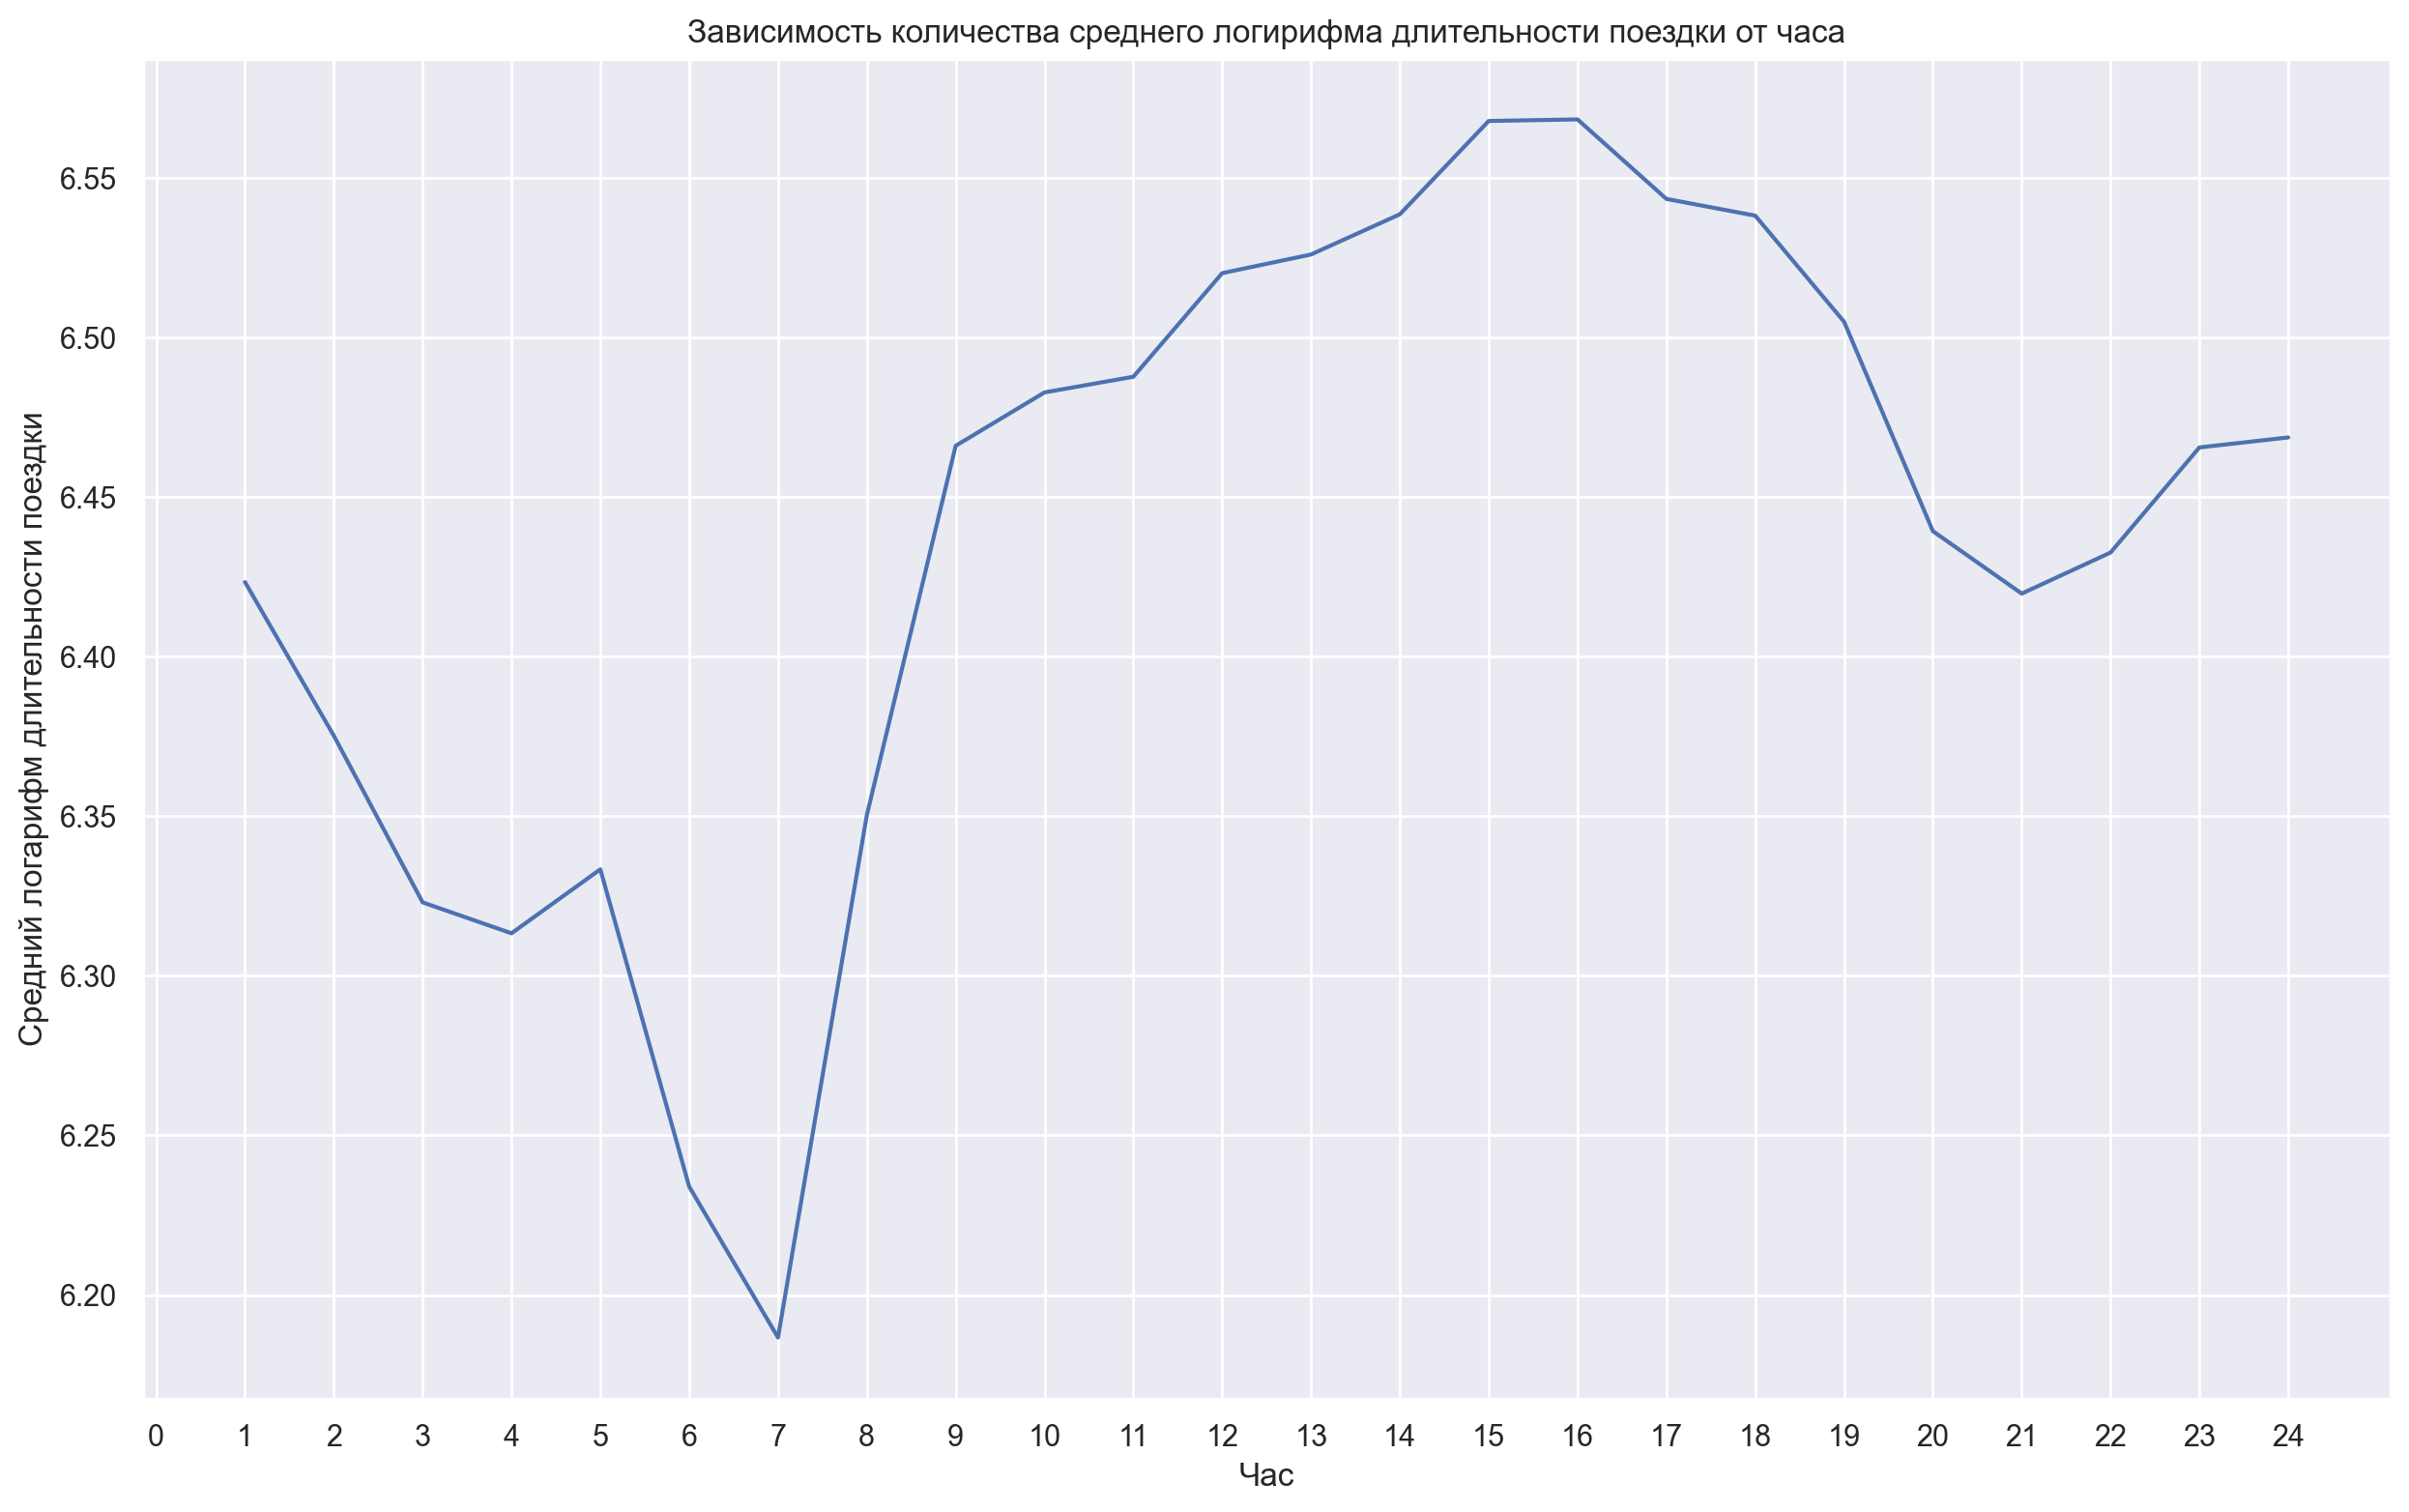

In [19]:
X_train['pickup_hour'] = X_train['pickup_datetime'].dt.hour + 1 #создаю столбец с часом в сутках
draw = X_train.groupby('pickup_hour').log_trip_duration.mean().reset_index() #аггрегирую 

sns.lineplot(data=draw, x='pickup_hour', y='log_trip_duration')

plt.title('Зависимость количества среднего логирифма длительности поездки от часа')
plt.xlabel('Час')
plt.ylabel('Средний логарифм длительности поездки')

plt.xticks(np.arange(25))

plt.show()
X_train = X_train.drop('pickup_hour', axis=1)

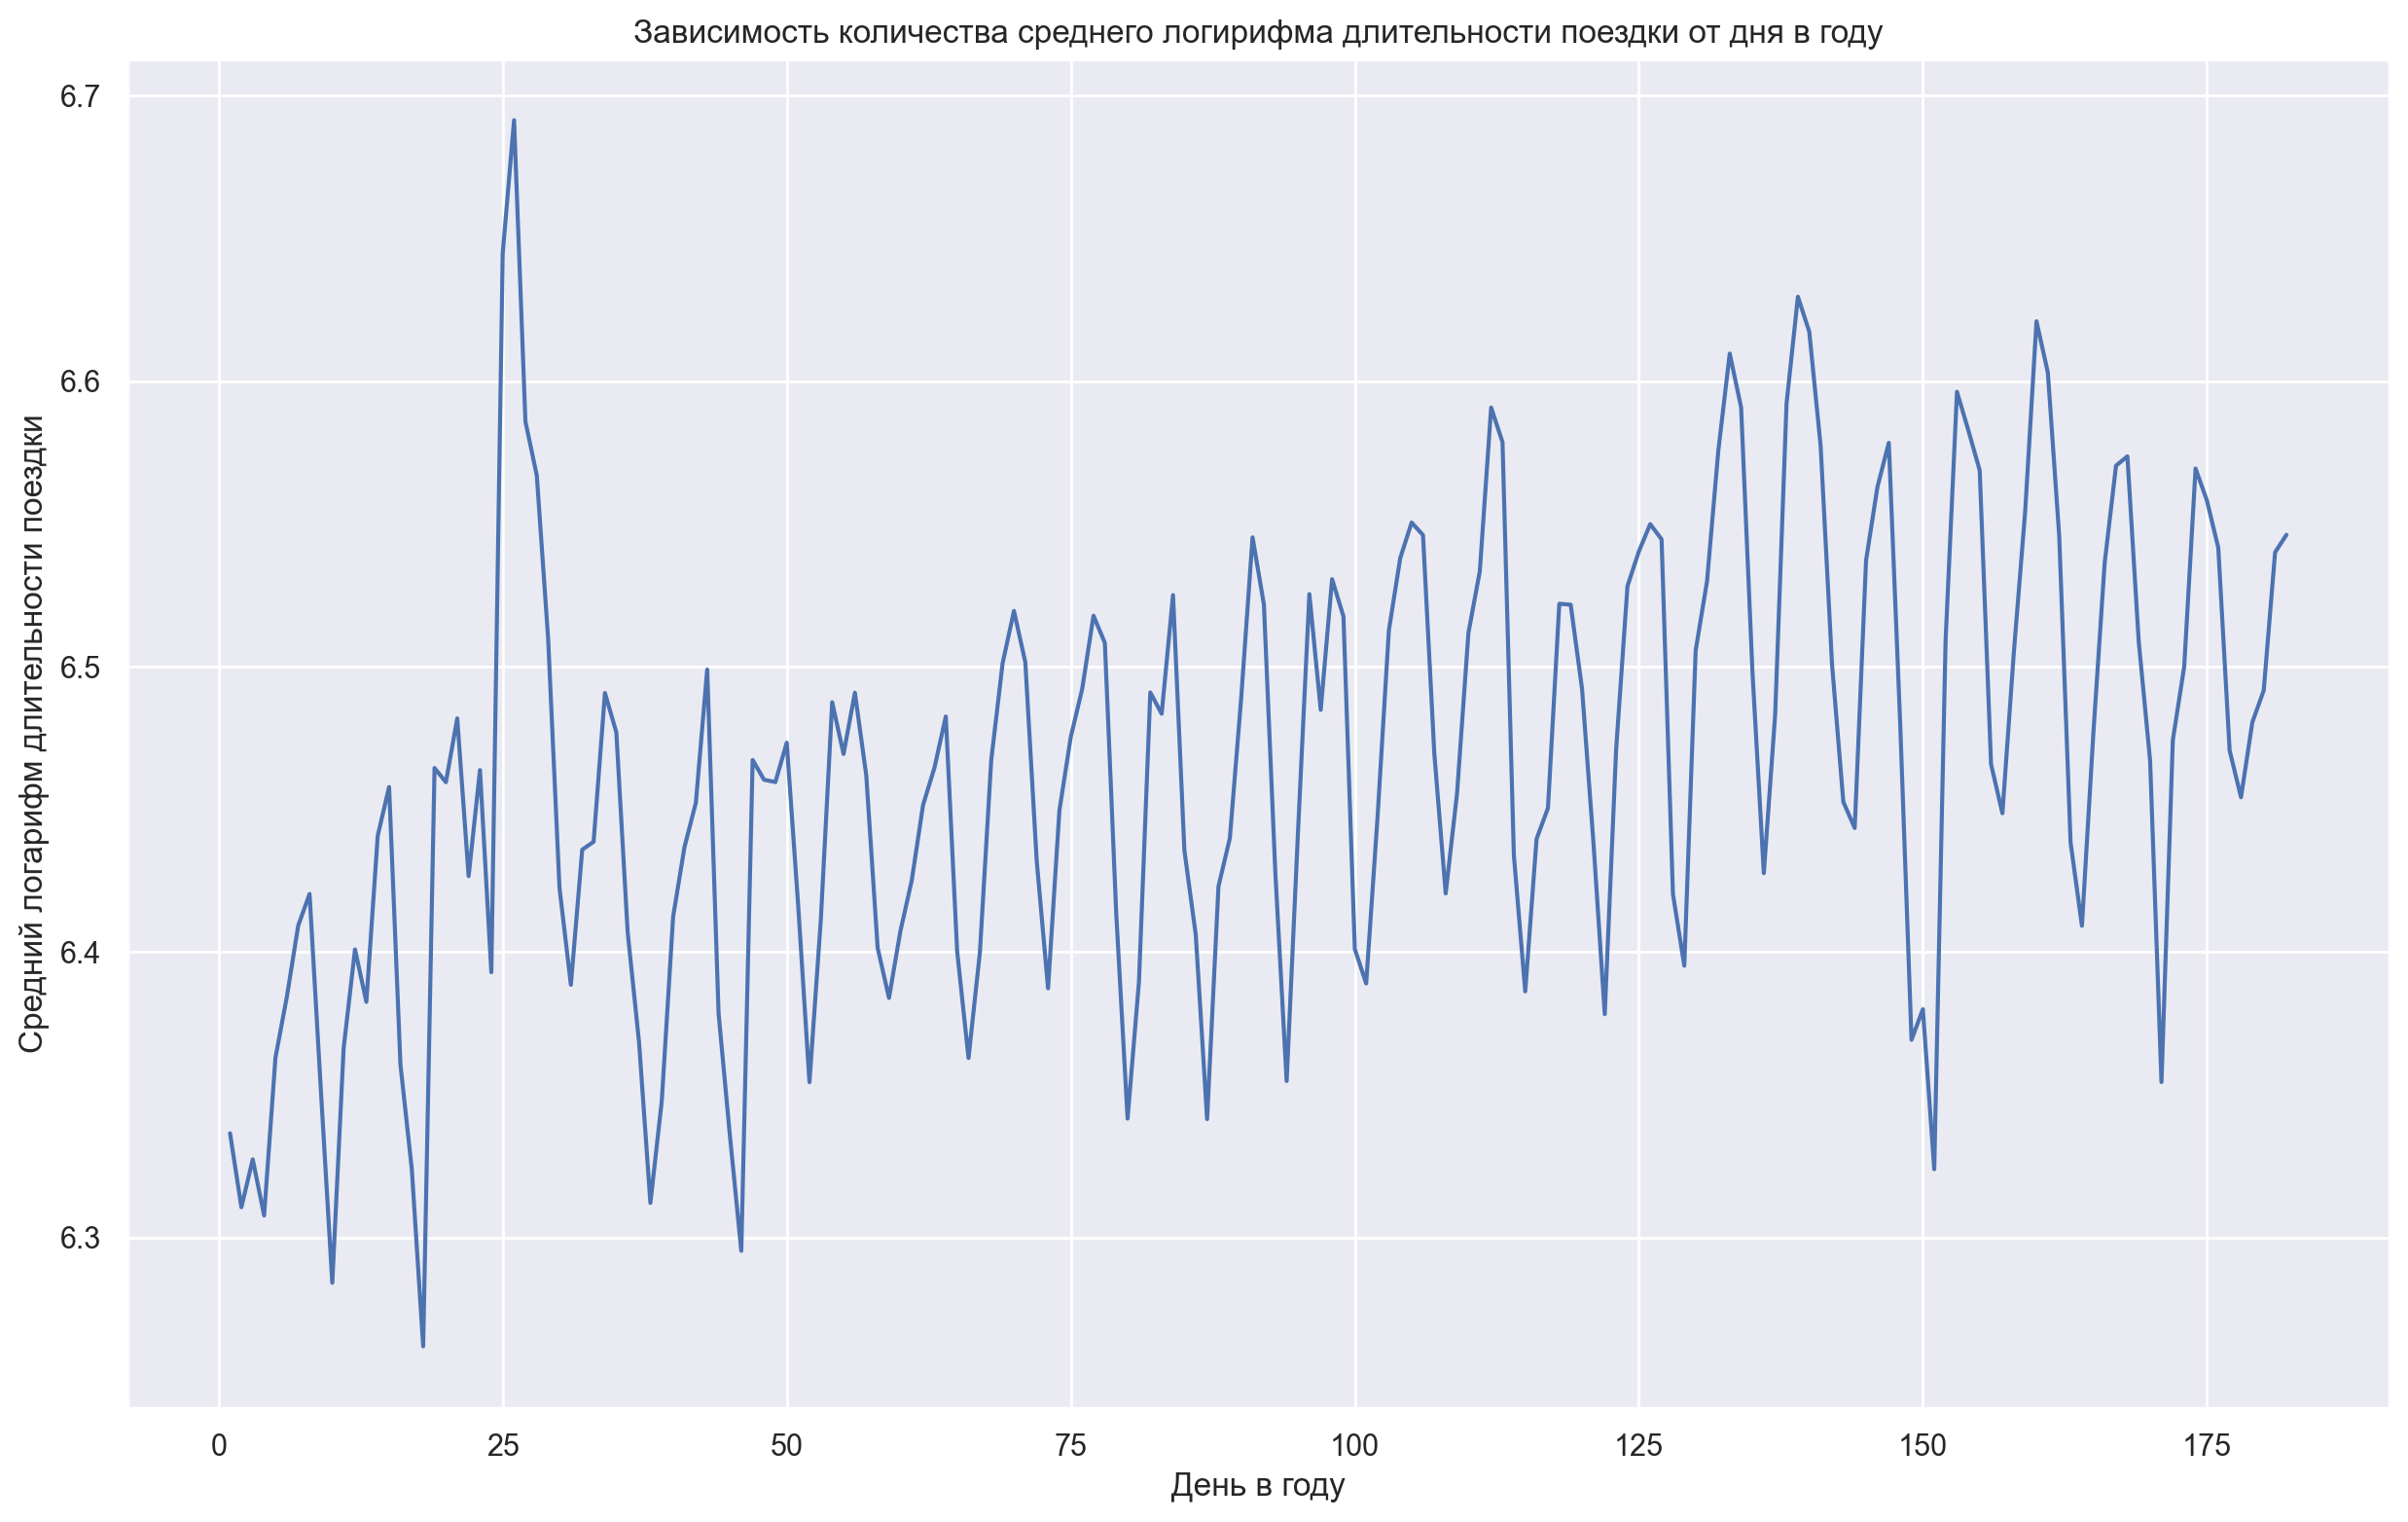

In [20]:
X_train['pickup_day'] = X_train['pickup_datetime'].dt.dayofyear #создаю столбец с часом в сутках
draw = X_train.groupby('pickup_day').log_trip_duration.mean().reset_index() #аггрегирую 

sns.lineplot(data=draw, x='pickup_day', y='log_trip_duration')

plt.title('Зависимость количества среднего логирифма длительности поездки от дня в году')
plt.xlabel('День в году')
plt.ylabel('Средний логарифм длительности поездки')

plt.show()
X_train = X_train.drop('pickup_day', axis=1)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

**Ответ:** График зависимости таргета от дня недели на график для количества поездок не похож, график зависимости таргета от часа в сутках на график для количества поездок немного похож, но я не понимаю почему они должны быть похожи? Это же вообще разные признаки. Один измеряет время поездки, а другой количество поездок. Возможно время и количество как-то коррелируют, но вряд ли они будут похожи. Единственное, что я заметил - в пятницу больше всего поездок и больше всего время поездки. Это можно объяснить тем, что образуеются пробки  
В те два аномальных периода средний таргет сильно меняется. В первый период в январе он резко возрастает. Это логично, так как если была буря, то движение будет проблематичным и время увеличится. Во второй период время, наоборот, сократилось. Если там была стрельба, то люди вряд ли хотели куда-то выходить и ездить на дальние расстояния  
Тренд на графике зависимости log_trip_duration от номера дня в году и вправду наблюдается, причем возрастающий и линейный

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [65]:
X_train['pickup_week'] = X_train['pickup_datetime'].dt.day_name()
X_train['pickup_month'] = X_train['pickup_datetime'].dt.month_name()
X_train['pickup_hour'] = X_train['pickup_datetime'].dt.hour
X_train['is_anomaly1'] = 0
X_train.loc[df['pickup_datetime'].dt.dayofyear.isin ([23,24]), 'is_anomaly1'] = 1
X_train['is_anomaly2'] = 0
X_train.loc[df['pickup_datetime'].dt.dayofyear.isin ([151]), 'is_anomaly2'] = 1
X_train['pickup_day'] = X_train['pickup_datetime'].dt.dayofyear

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

**Ответ:** В качестве категориальных я выберу pickup_week и pickup_month. is_anomaly1, is_anomaly2 уже категориальные (по сути бинарные). pickup_hour и pickup_day буду рассматривать как числовые, потому что во-первых, все-таки можно сравнивать спрос на такси в разные часы - понятно, что в будни в рабочие часы чем больше час, тем больше поездок, но так не на всем интервале. С днем в году есть некая сезонность - чем ближе к лету, тем больше поездок. Во-вторых, если учитывать эти фичи как категориальные, то получится слишком много признаков. 

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Напишу функции преобразования категориальных и числовых фичей, потому что они еще будут много использоваться дальше

In [23]:
def one_hot_encoding(X, columns):
    #применяю OneHotEncoder
    ohe = OneHotEncoder()
    feature_arry = ohe.fit_transform(X[columns]).toarray() #матрица категориальных фичей
    labels = ohe.categories_
    #объединяю массивы в категориями в один массив
    feature_labels = []
    for category in labels:
        feature_labels = np.hstack([feature_labels, np.array(category, dtype=object)])
    features = pd.DataFrame(feature_arry, columns=feature_labels)
    q = X.copy()
    q = pd.concat([X.reset_index(), features.reset_index()], axis=1)
    q = q.drop('index', axis=1)
    return q

In [25]:
def scaler(X, columns):
    var = X.loc[:, columns]
    scaler = StandardScaler().fit(var)
    var_scaled = scaler.transform(var)
    X_scaled = pd.DataFrame(var_scaled, columns=[title + '_scaled' for title in columns])
    q = X.copy()
    q = pd.concat([X.reset_index(), X_scaled.reset_index()], axis=1)
    q = q.drop('index', axis=1)
    return q

In [66]:
X_train = one_hot_encoding(X_train, ['pickup_week', 'pickup_month'])
X_train = scaler(X_train, ['pickup_hour', 'pickup_day'])

In [94]:
from sklearn.linear_model import Ridge
#обучим модель
#выберем нужные столбцы
cols = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'February', 'January', 
        'June', 'March','May', 'pickup_hour_scaled', 'pickup_day_scaled', 'is_anomaly1', 'is_anomaly2']
ridge = Ridge()
ridge.fit(X_train[cols], X_train['log_trip_duration'])

Ridge()

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [30]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [31]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [32]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

**Ответ:** На самом деле при каждом запуске точки меняются и иногда они появляются где-то в поле, но в основном всегда есть точки в двух аэропортах - рядом с Newark и в районе Queen (я посмотрел там находится аэропорт John F. Kennedy International Airport)

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [33]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [67]:
X_train['haversine'] = haversine_array(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, 
                                  X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [68]:
X_train['log_haversine'] = np.log1p(X_train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [36]:
print('корреляция логарифма расстояния с таргетом = %.5f' % X_train['log_haversine'].corr(X_train['log_trip_duration']))
print('корреляция расстояния с таргетом = %.5f' % X_train['haversine'].corr(X_train['log_trip_duration']))

корреляция логарифма расстояния с таргетом = 0.74996
корреляция расстояния с таргетом = 0.56541


Стонкс

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

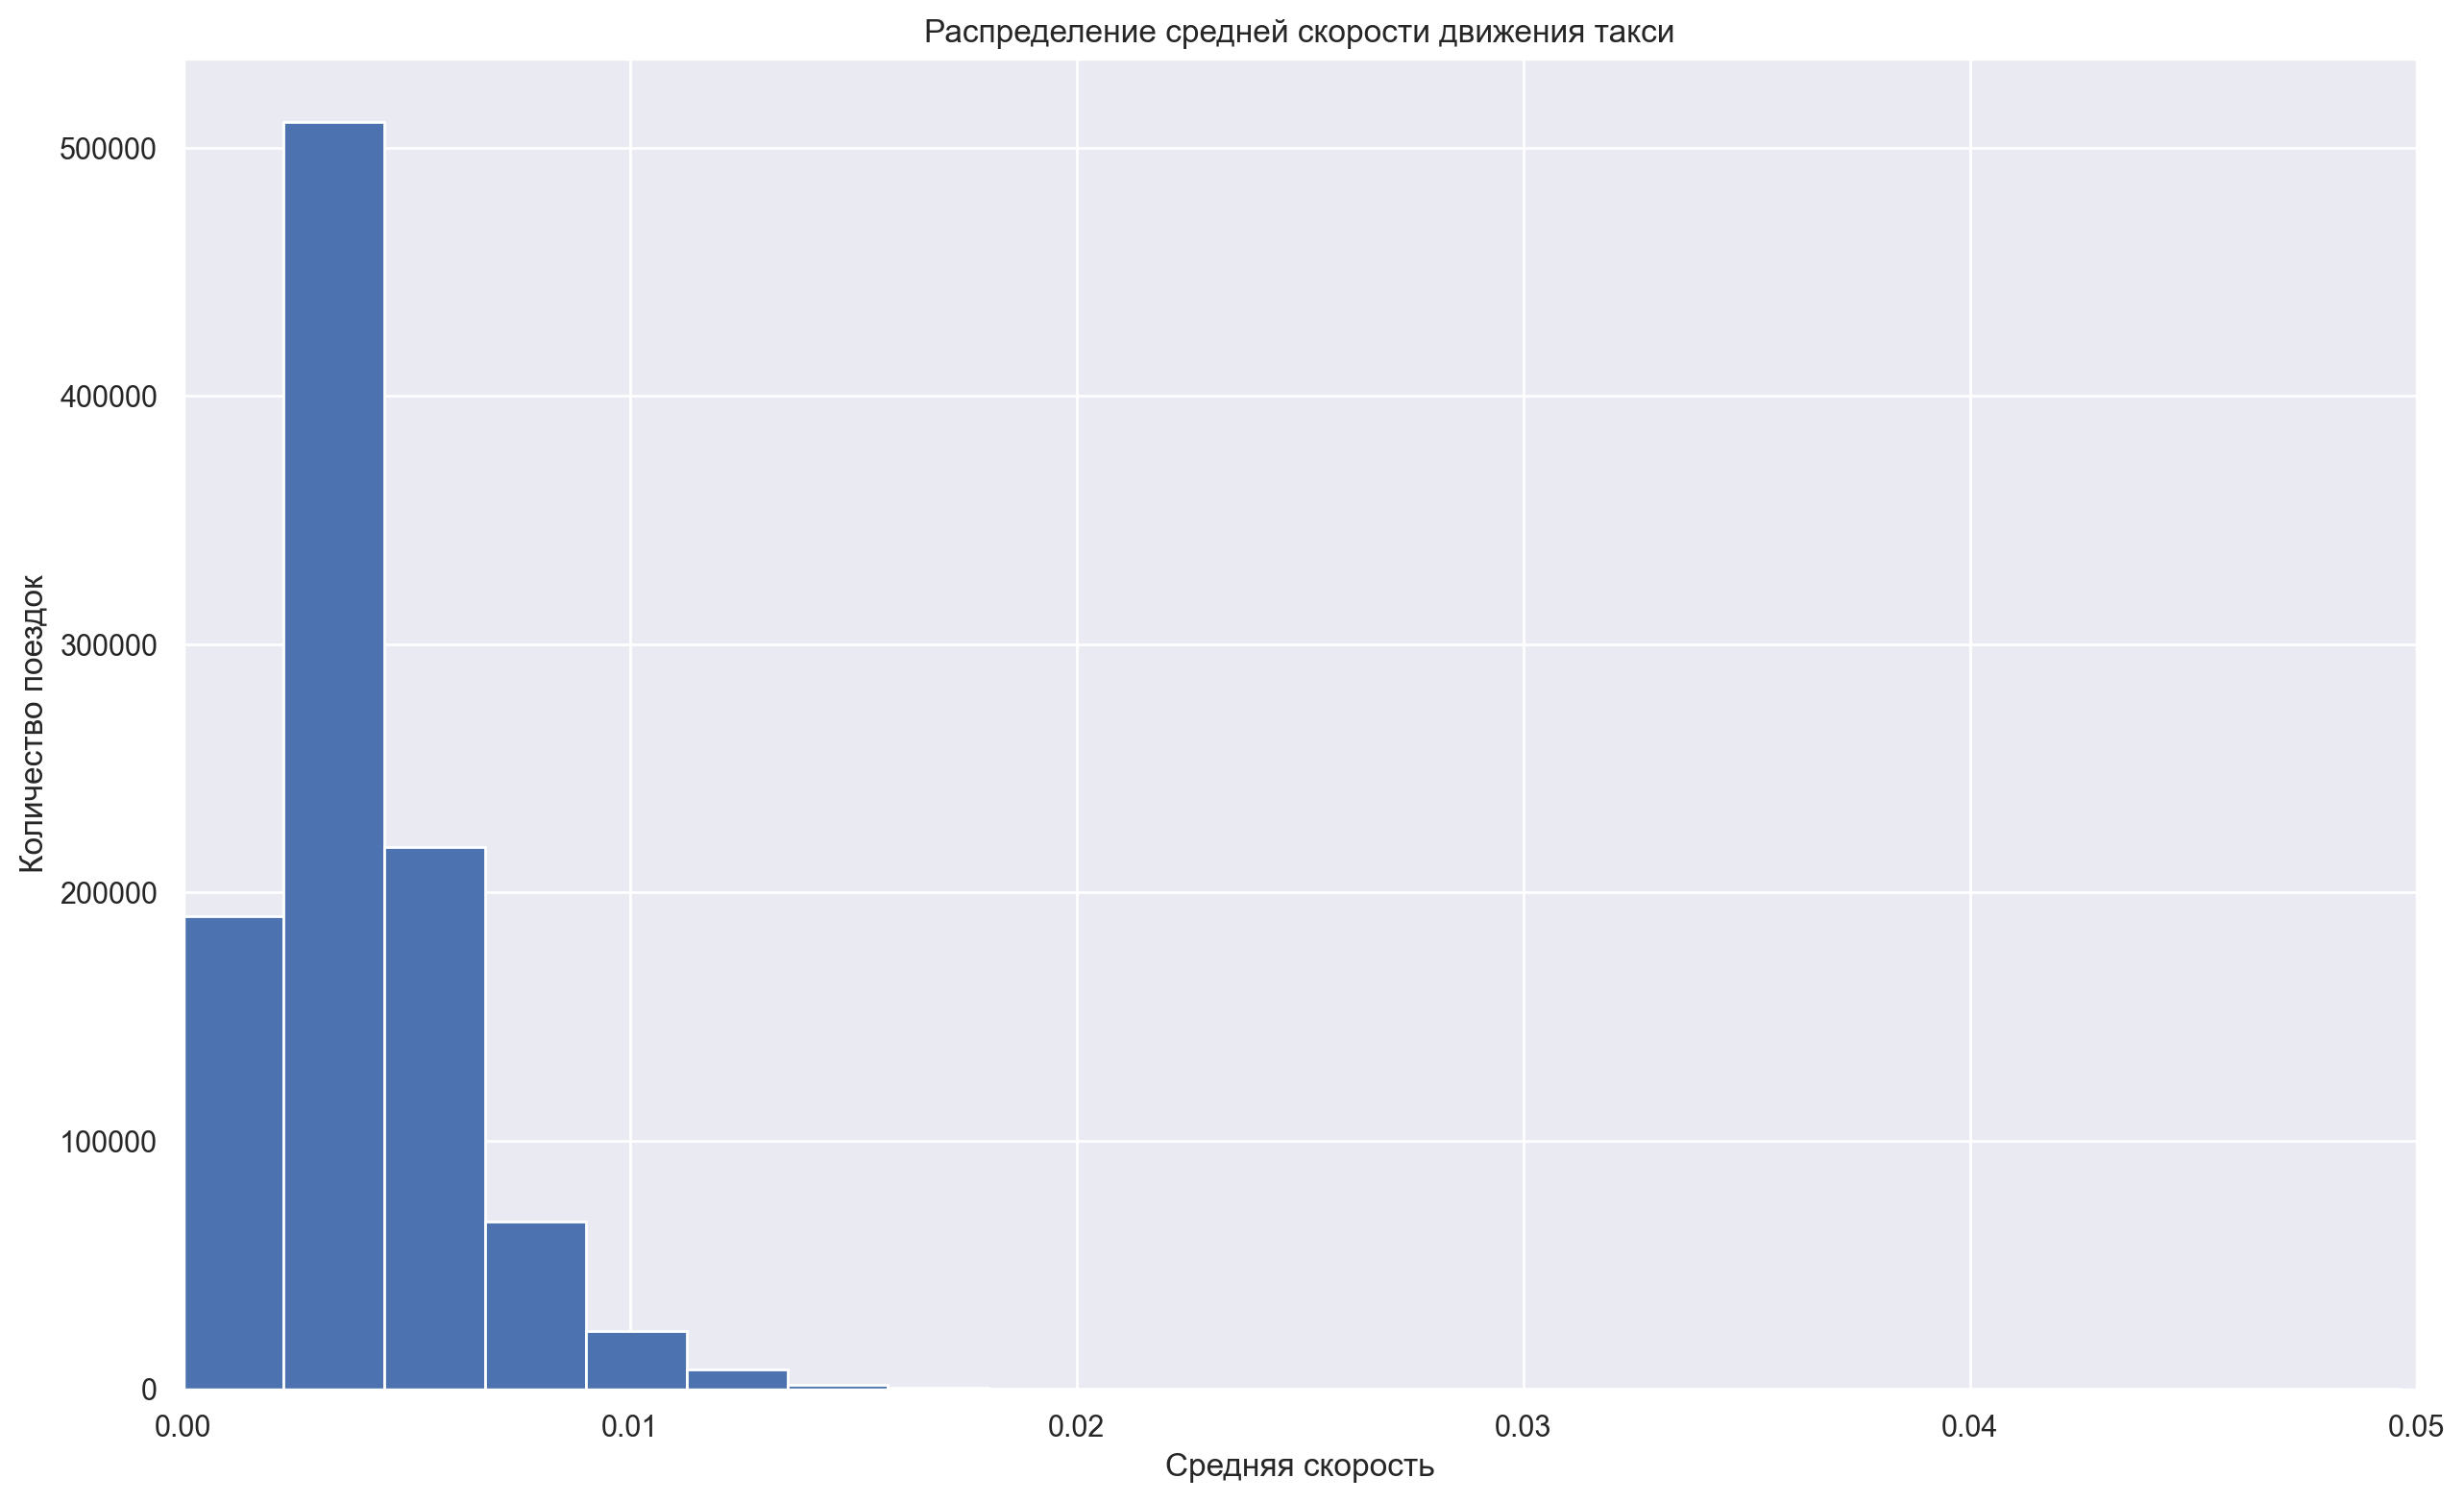

In [37]:
plt.hist(X_train['haversine'] / (np.exp(X_train['log_trip_duration']) ), bins=1000)

plt.xlim(0,0.05)

plt.title('Распределение средней скорости движения такси')
plt.xlabel('Средняя скорость')
plt.ylabel('Количество поездок')

plt.show()


Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [38]:
X_train['mean_velocity'] = X_train['haversine'] / (np.exp(X_train['log_trip_duration']))
quant = X_train.quantile(q=.95, axis=0).mean_velocity #ищу 0.95 квантиль скорости
X_train = X_train[X_train['mean_velocity'] <= quant] #оставляю только те, что меньше

/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/1476417254.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quant = X_train.quantile(q=.95, axis=0).mean_velocity #ищу 0.95 квантиль скорости


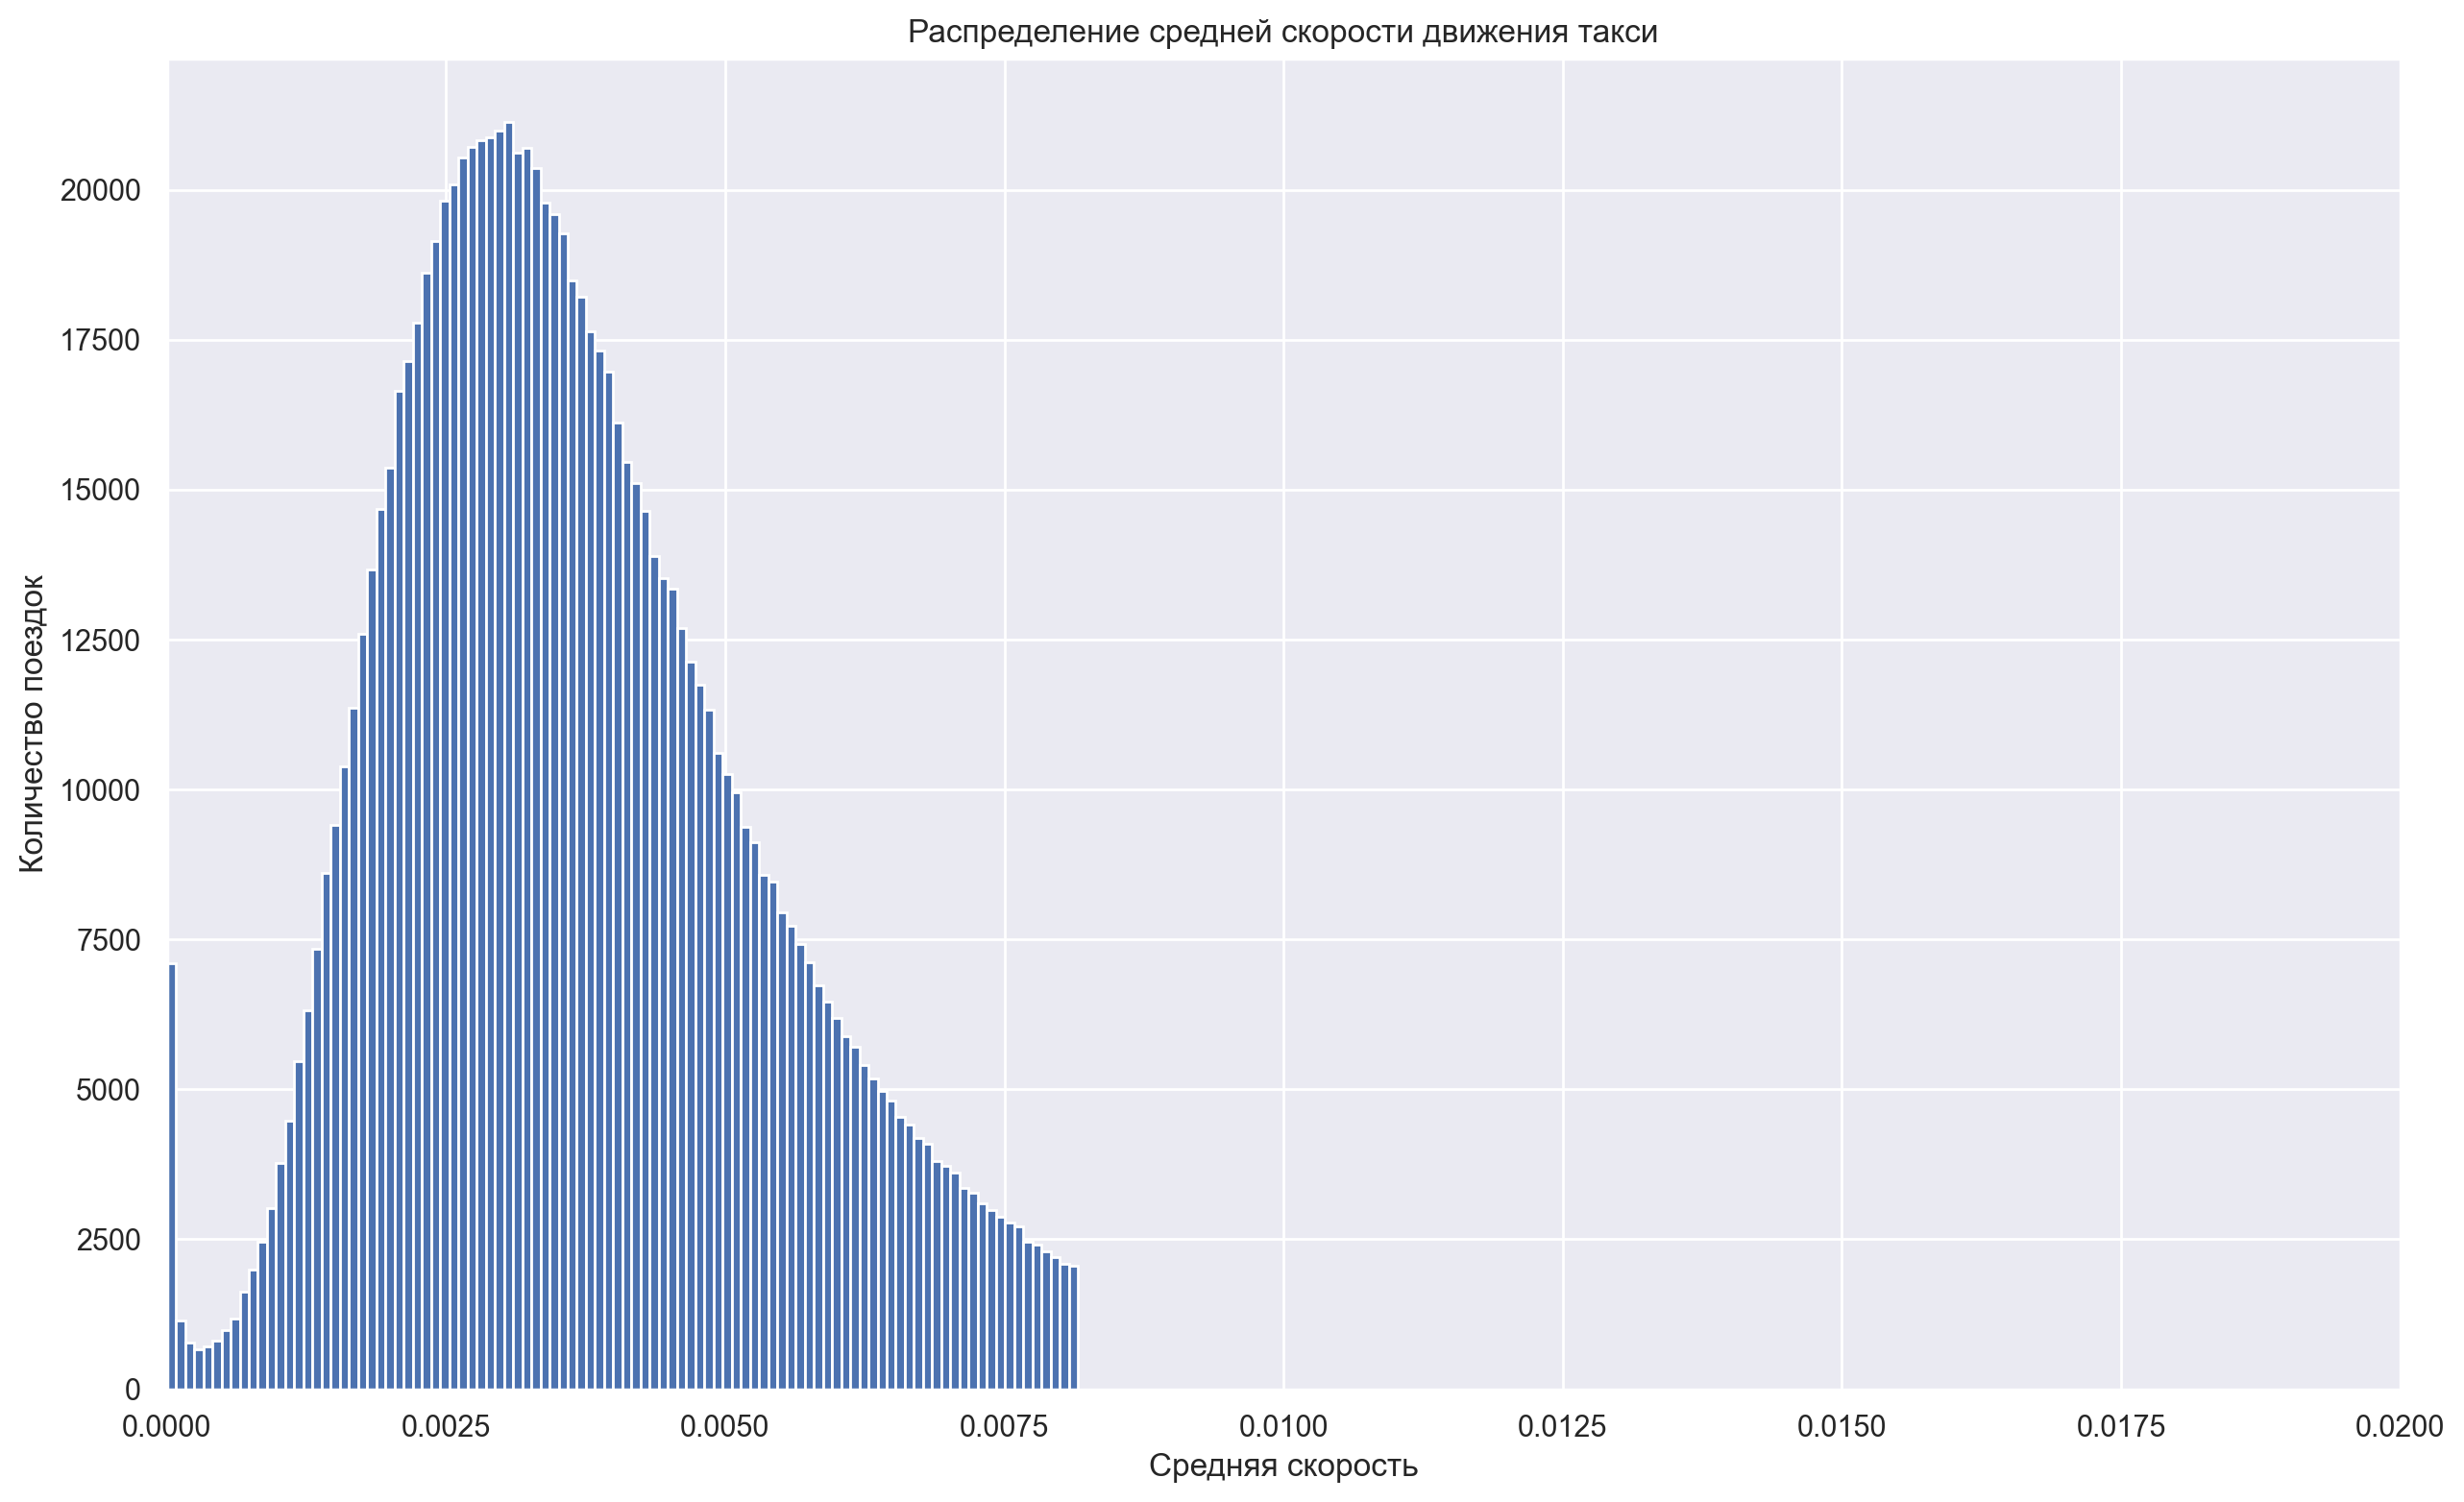

In [39]:
plt.hist(X_train['mean_velocity'], bins=100)

plt.xlim(0, .02)

plt.title('Распределение средней скорости движения такси')
plt.xlabel('Средняя скорость')
plt.ylabel('Количество поездок')

plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

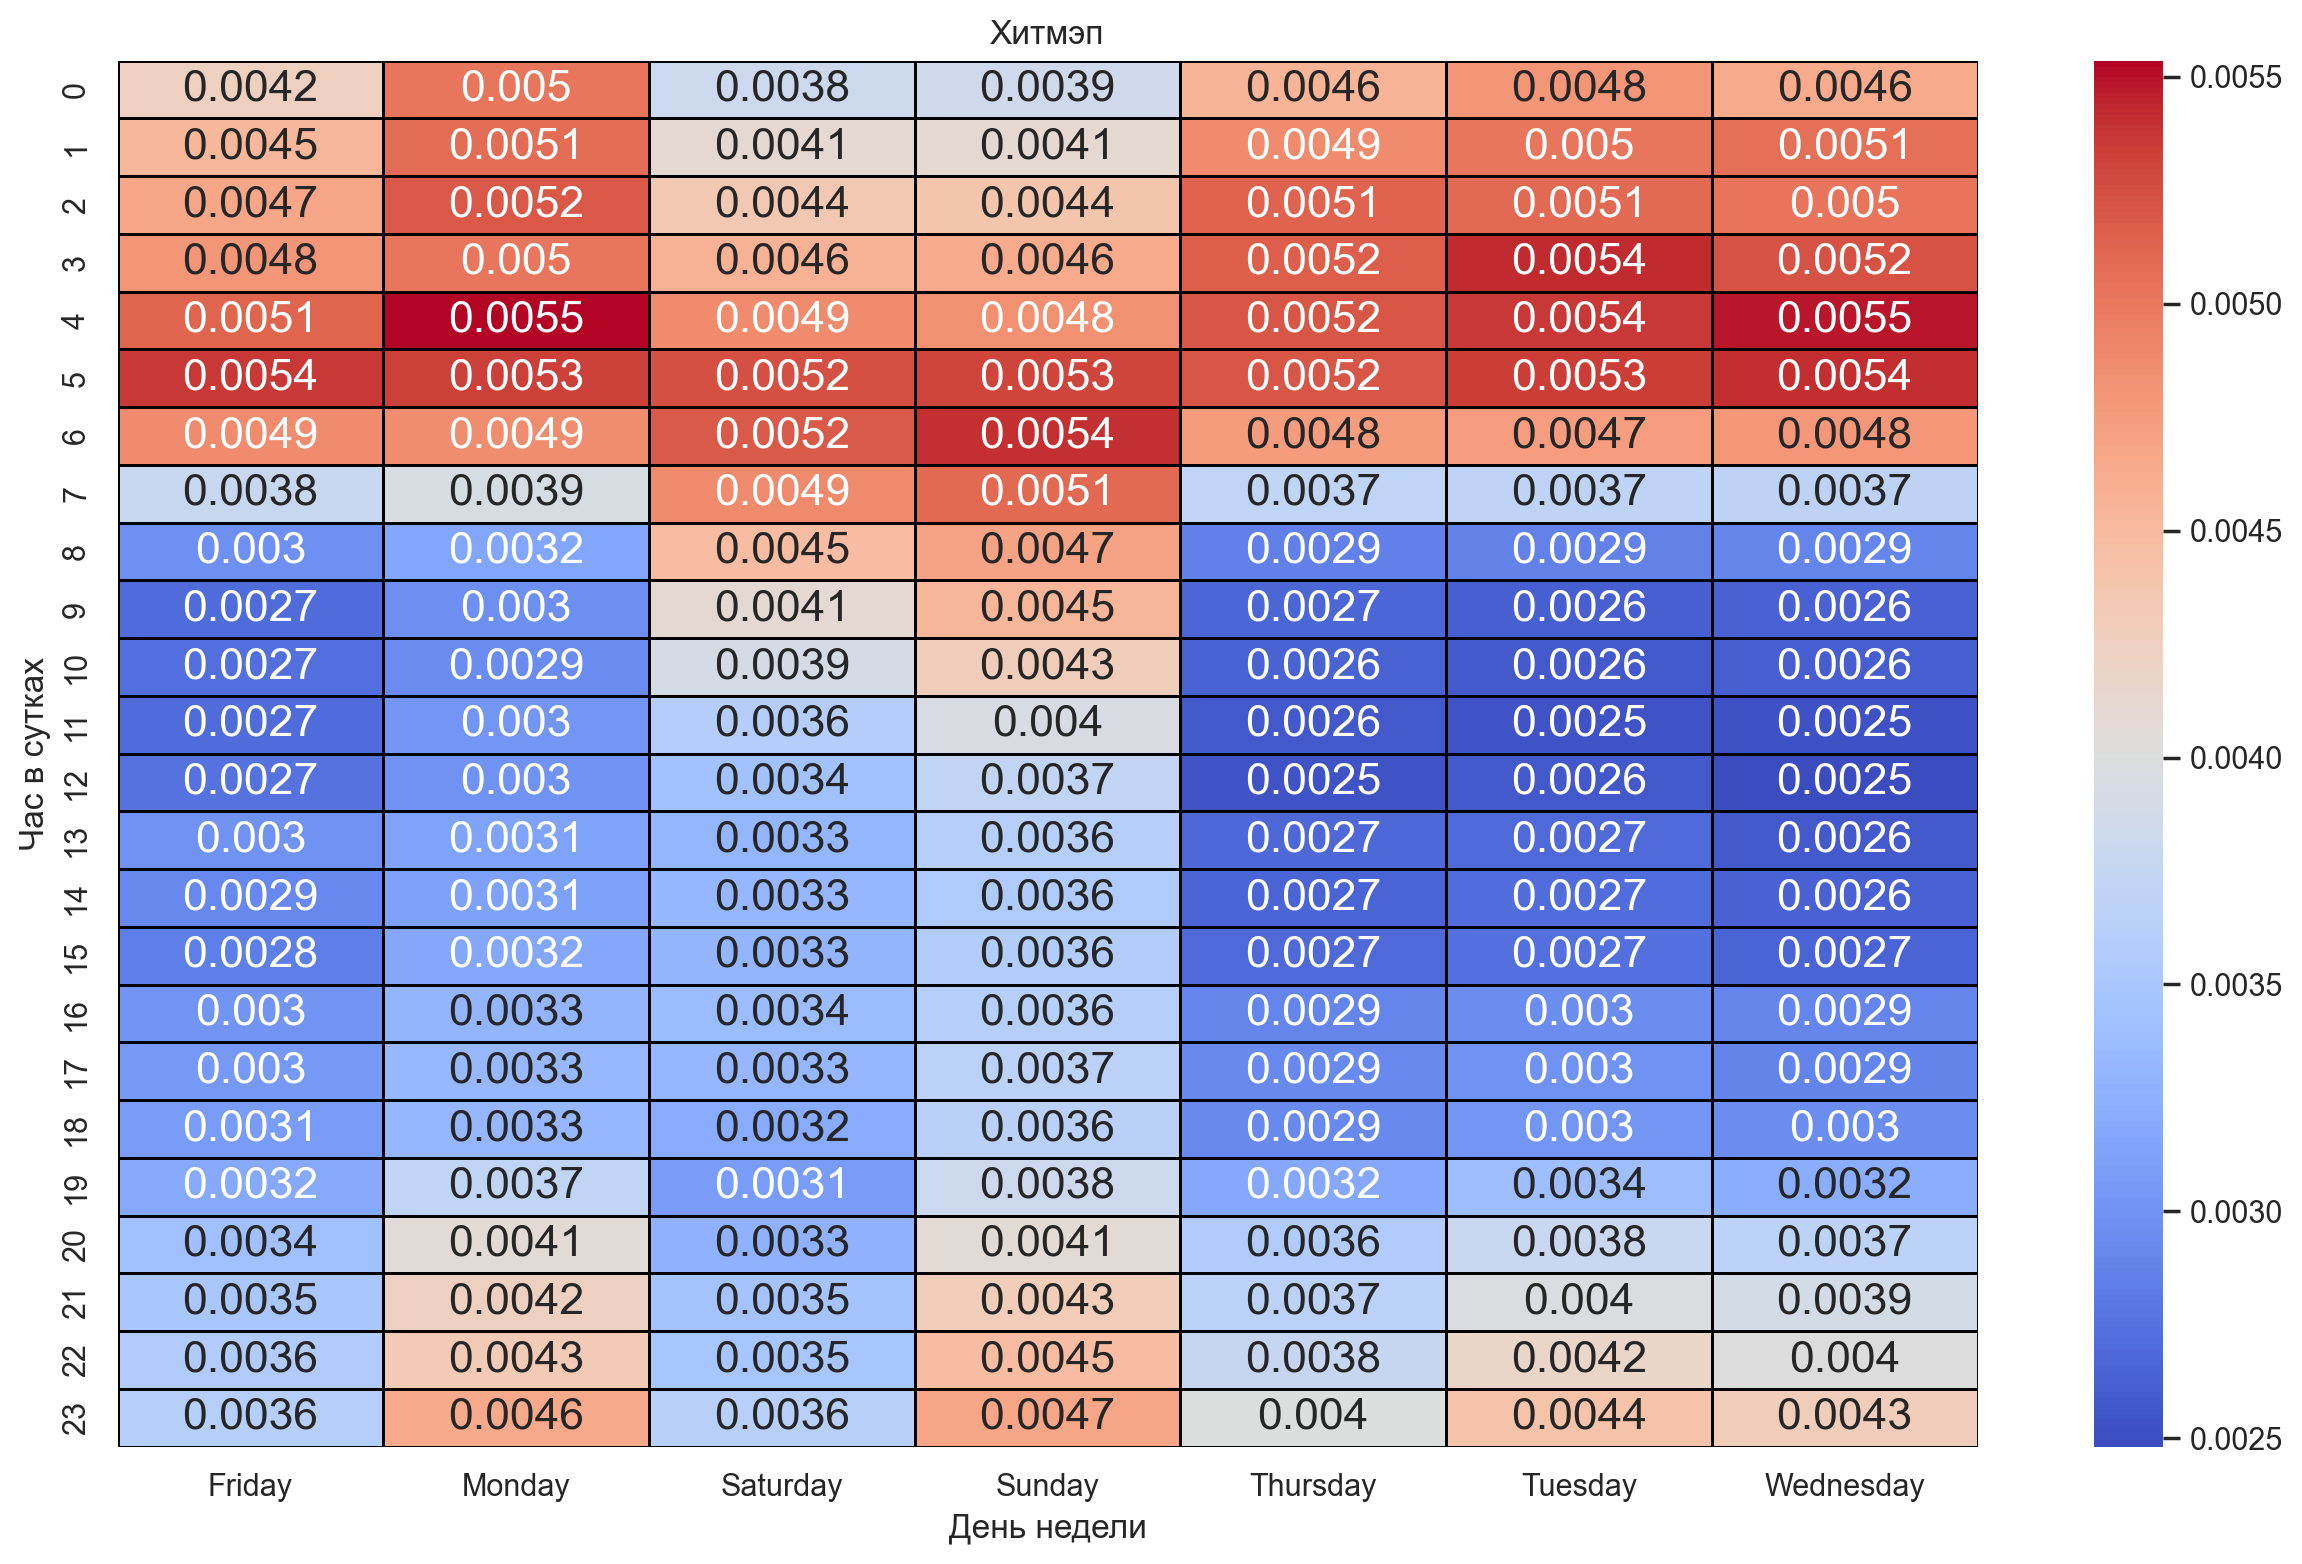

In [40]:
table = pd.pivot_table(X_train, values='mean_velocity', index='pickup_hour', columns='pickup_week',
                       aggfunc={'mean_velocity': np.median})

sns.heatmap(table, annot=True, cmap= 'coolwarm',  linewidths=.5, linecolor='black')

plt.title('Хитмэп')
plt.xlabel('День недели')
plt.ylabel('Час в сутках')

plt.show()

In [41]:
X_train = X_train.drop('mean_velocity', axis=1)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

**Ответ:** потому что заранее невозможно измерить скорость, тк мы не знаем конечную точку, а следовательно и расстояние и время

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

**Ответ:** Скорость максимальна ~4-6 часа ночи, а минимальна в будни в рабочие часы. В целом на протяжении всего рабочего времени в будни загруженность на дорогах примерно одинаковая. Пробки начинаются примерно с 8 и до 19 в будни. В суббоу ситуация довольно похода, но все же разгруженность побольше. Можно сказать, что пробки с 13 до 20. В воскресенье дороги по большей части свободные

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [69]:
X_train['traffic_road'] = 0
X_train.loc[( (X_train['pickup_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (X_train['pickup_hour'].isin(list(range(8,20))))) 
       | ((X_train['pickup_week'] == 'Saturday') & (X_train['pickup_hour'].isin(list(range(13,21))))), 'traffic_road'] = 1

X_train['free_road'] = 1
X_train.loc[( (X_train['pickup_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (X_train['pickup_hour'].isin(list(range(8,20))))) 
       | ((X_train['pickup_week'] == 'Saturday') & (X_train['pickup_hour'].isin(list(range(13,21))))), 'traffic_road'] = 0

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [70]:
#Newark airport
X_train['newark_start'] = 0
X_train.loc[(X_train['pickup_latitude'].between(40.71, 40.74)) & (X_train['pickup_longitude'].between(-74.2, -74.1)), 'newark_start'] = 1
X_train['newark_end'] = 0
X_train.loc[(X_train['dropoff_latitude'].between(40.71, 40.74)) & (X_train['dropoff_longitude'].between(-74.2, -74.1)), 'newark_end'] = 1
#JFK airport
X_train['jfk_start'] = 0
X_train.loc[(X_train['pickup_latitude'].between(40.5, 40.7)) & (X_train['pickup_longitude'].between(-73.8, -73.7)), 'jfk_start'] = 1
X_train['jfk_end'] = 0
X_train.loc[(X_train['dropoff_latitude'].between(40.5, 40.7)) & (X_train['dropoff_longitude'].between(-73.8, -73.7)), 'jfk_end'] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

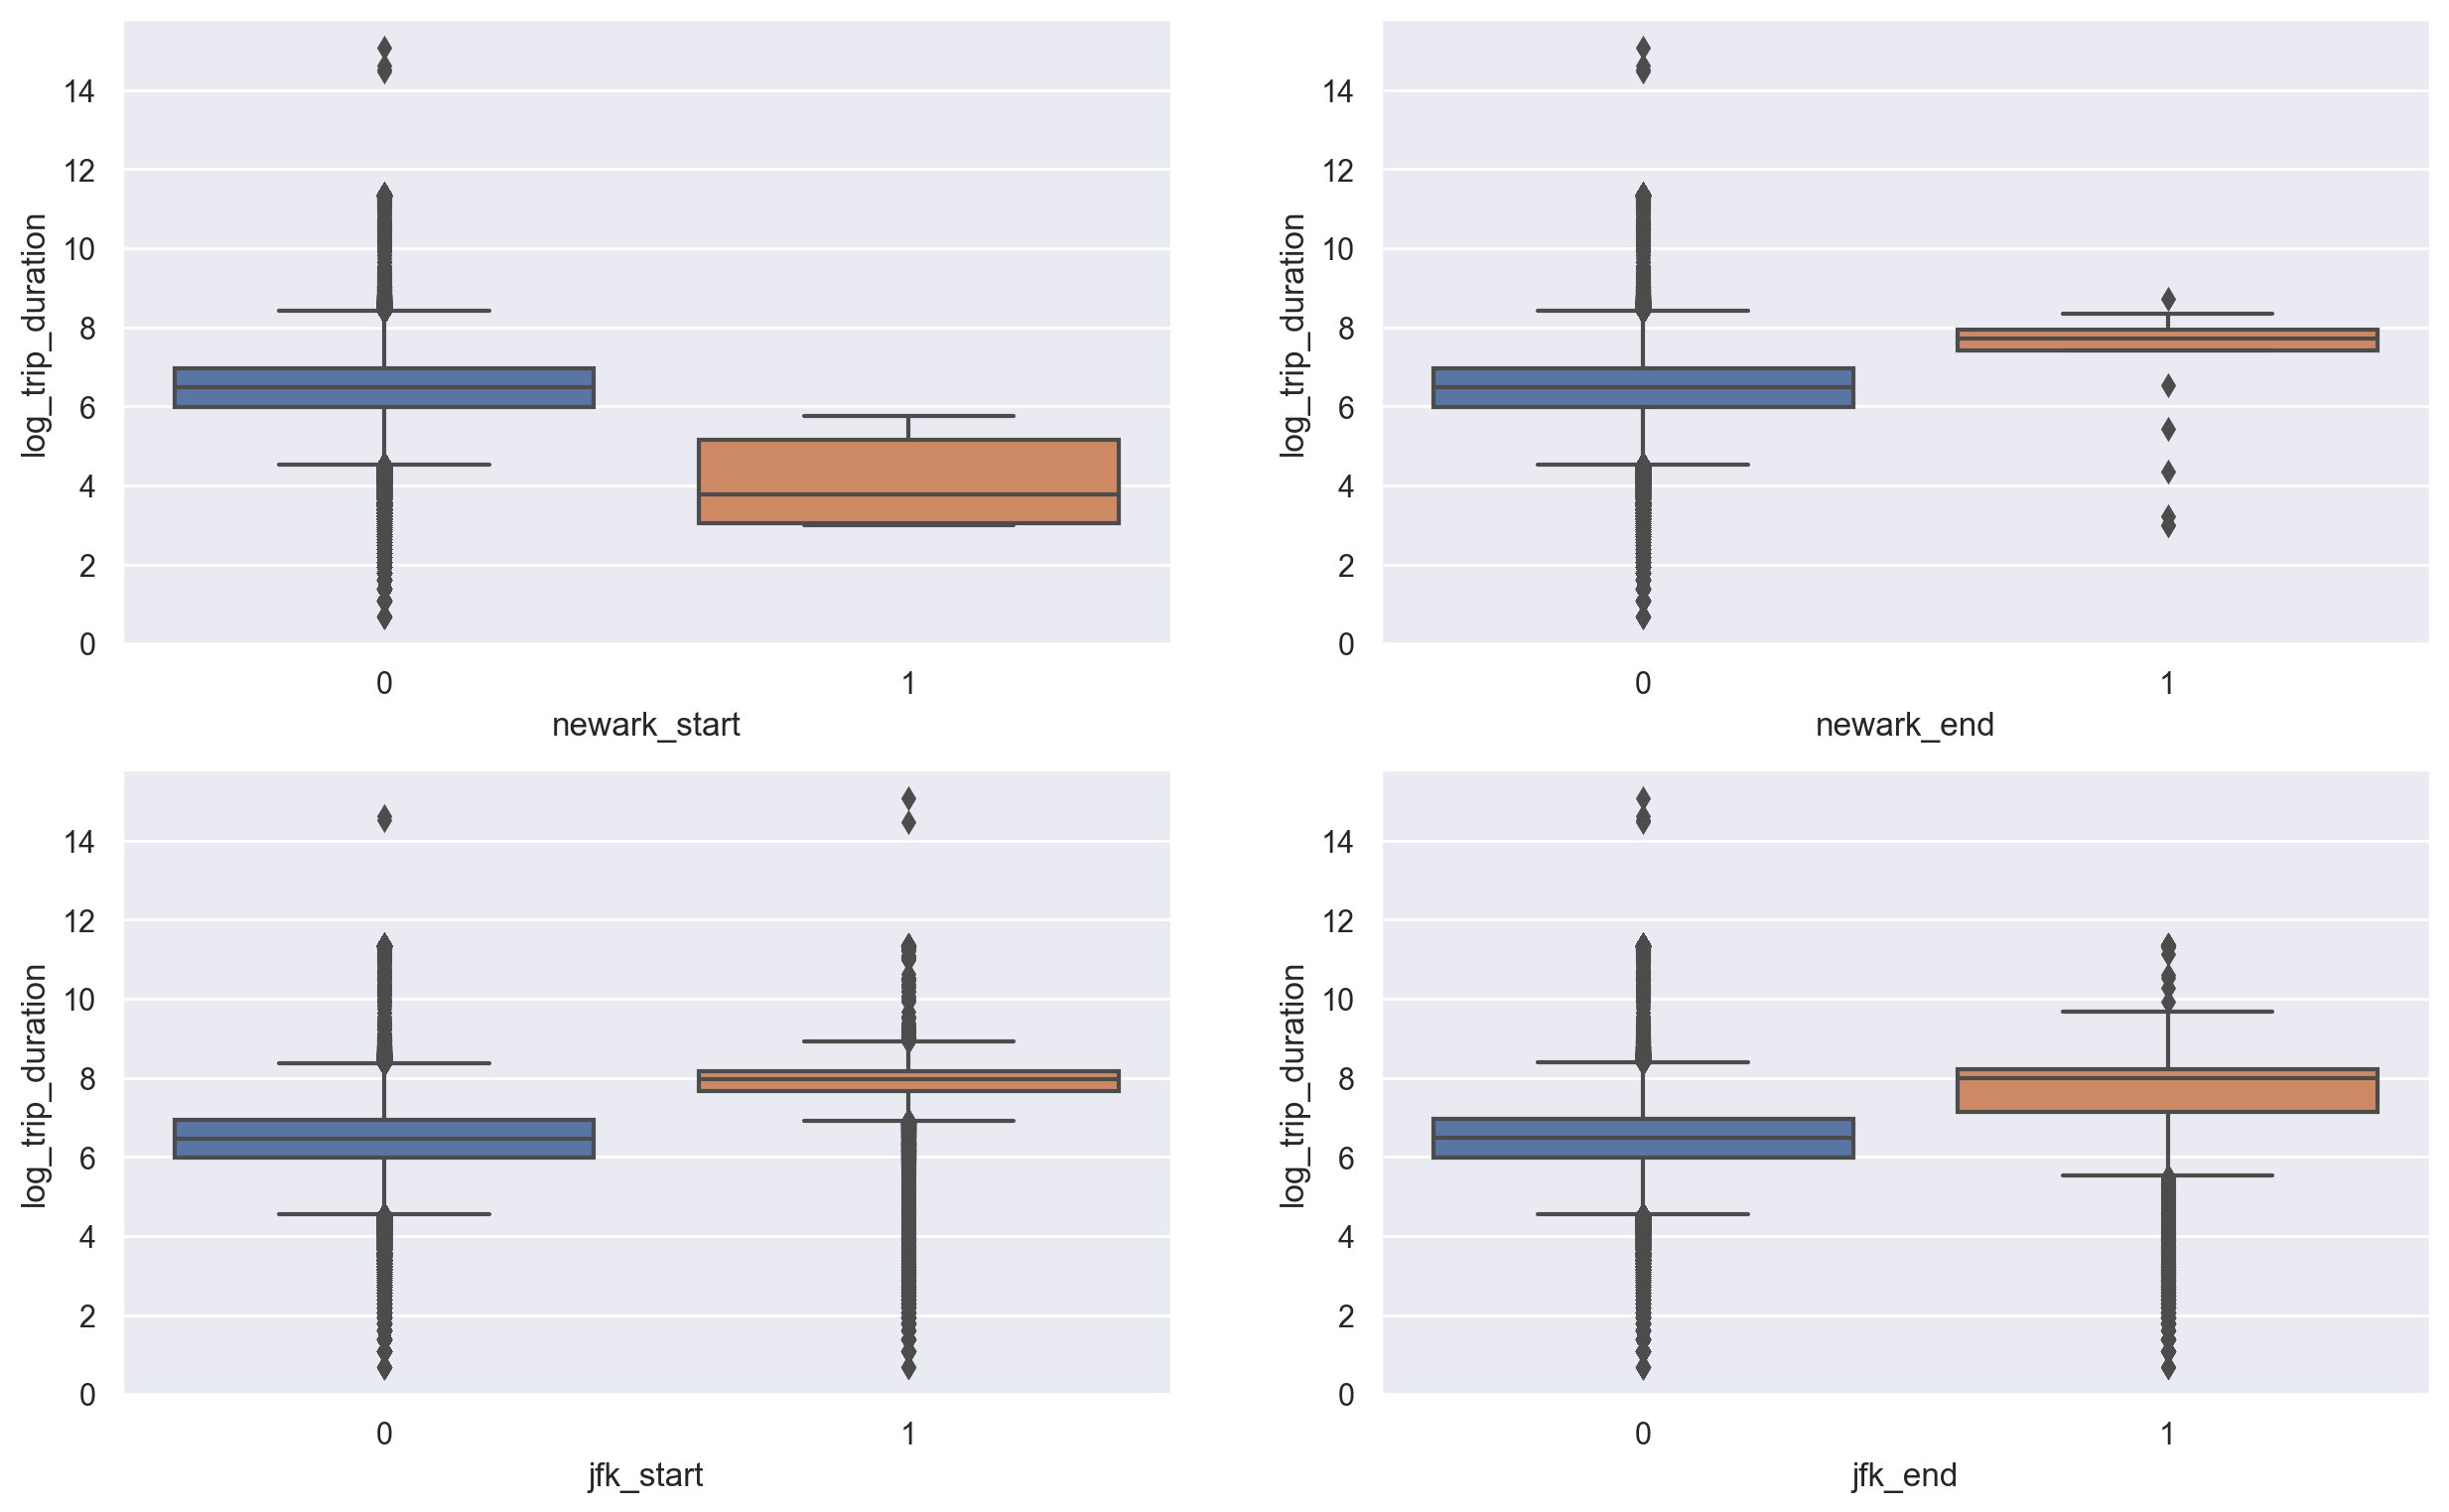

In [44]:
fig, ax = plt.subplots(2, 2)

for i, column in enumerate(['newark_start', 'newark_end', 'jfk_start', 'jfk_end']):
    ax = plt.subplot(2, 2, i + 1)
    sns.boxplot(X_train, x=column, y='log_trip_duration')
    
    plt.xlabel(column)
    

plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

**Ответ:** В целом достаточно неплохие. Для 3 из 4 точек время поездки получилось больше. Только для поездок, которые начались из newark время меньше, но там и разброс больше

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

**Идею** как разбить сетку я позаимствовал [отсюда](https://stackoverflow.com/questions/51573164/dividing-geographical-region-into-equal-sized-grid-and-retrieving-indexing-posit)

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, topLeft, topRight, bottomRight, bottomLeft, columns=3, rows=4):
        self.topLeft = topLeft
        self.topRight = topRight
        self.bottomRight = bottomRight
        self.bottomLeft = bottomLeft
        self.number_of_columns = columns
        self.number_of_rows = rows
        #разбиваю заданную область на сетку
        self.cols = np.linspace(bottomLeft[1], bottomRight[1], num=columns)
        self.rows = np.linspace(bottomLeft[0], topLeft[0], num=rows)
        pass    

    def transform(self, X, y=None):
        q = X.copy()
        #это функция, которая возвращает индекс в массиве, в который нужно вставить аргумент, чтобы сортировка массива не изменилась
        #таким образом я получаю номер столбца и строки для каждой точки 
        pickup_column = np.searchsorted(self.cols, X['pickup_longitude'])
        pickup_row = np.searchsorted(self.rows, X['pickup_latitude'])
        #формула по которой в соответствие номеру строки и столбца ставится номер ячейки
        q['pickup_column'] = np.searchsorted(self.cols, X['pickup_longitude'])
        q['pickup_row'] = np.searchsorted(self.rows, X['pickup_latitude'])
        #формула по которой в соответствие номеру строки и столбца ставится номер ячейки
        q['pickup_cell'] = self.number_of_columns * (q['pickup_row'] - 1) + q['pickup_column']
        #случаи когда надо ставить -1
        q.loc[(q['pickup_column'] < 1) | (q['pickup_column'] > self.number_of_columns) | 
              (q['pickup_row'] < 1) | (q['pickup_row'] > self.number_of_rows),
              'pickup_cell'] = -1
        q['dropoff_column'] = np.searchsorted(self.cols, X['dropoff_longitude'])
        q['dropoff_row'] = np.searchsorted(self.rows, X['dropoff_latitude'])
        q['dropoff_cell'] = self.number_of_columns * (q['dropoff_row'] - 1) + q['dropoff_column']
        q.loc[(q['dropoff_column'] < 1) | (q['dropoff_column'] > self.number_of_rows) |
              (q['dropoff_row'] < 1) | (q['dropoff_row'] > self.number_of_rows),
              'dropoff_cell'] = -1
        return q
    

In [71]:
#координаты я просто взял сам с карты
topLeft = [40.800996, -74.012065]
topRight = [40.784202, -73.946793]
bottomRight = [40.704052, -73.958546]
bottomLeft = [40.710571, -74.020803]
transformer = MapGridTransformer(topLeft, topRight, bottomRight, bottomLeft)
X_train = transformer.transform(X_train)

In [52]:
show_circles_on_map(X_train.query('pickup_cell != -1').sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Выглядит неплохо

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

В признаках добавились логарифм времени поездки, период пробок, период свободных дорог, старт и конец поездки из аэропортов, ячейка старта и окончания поездки  
Числовой - логарифм времени поездки. Его надо отнормировать  
категориальные - остальные. Кроме номера ячейки остальные уже бинарные, поэтому их не надо кодировать

In [53]:
#переименую числовые столбцы после ohe
def rename_columns(X, label):
    q = X.copy()
    for i in range(len(q.columns)):
        if isinstance(q.columns[i], int):
            q.rename(columns={q.columns[i]: label + str(q.columns[i])}, inplace=True)
    return q

In [72]:
X_train = scaler(X_train, ['log_haversine'])
X_train = one_hot_encoding(X_train, ['pickup_cell'])
X_train = rename_columns(X_train, 'pickup_cell_')
X_train = one_hot_encoding(X_train, ['dropoff_cell'])
X_train = rename_columns(X_train, 'dropoff_cell_')

In [55]:
cols = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'February', 'January', 
        'June', 'March','May', 'pickup_hour_scaled', 'pickup_day_scaled', 'is_anomaly1', 'is_anomaly2', 
        'log_haversine_scaled', 'traffic_road', 'free_road', 'newark_start', 'newark_end', 'jfk_start', 'jfk_end', 
       'pickup_cell_-1',
       'pickup_cell_1', 'pickup_cell_2', 'pickup_cell_3', 'pickup_cell_4',
       'pickup_cell_5', 'pickup_cell_6', 'pickup_cell_7', 'pickup_cell_8',
       'pickup_cell_9', 'pickup_cell_10', 'pickup_cell_11', 'pickup_cell_12',
       'dropoff_cell_-1', 'dropoff_cell_1', 'dropoff_cell_2', 'dropoff_cell_3',
       'dropoff_cell_4', 'dropoff_cell_5', 'dropoff_cell_6', 'dropoff_cell_7',
       'dropoff_cell_8', 'dropoff_cell_9', 'dropoff_cell_10'] 
#я не знаю, как по умному их тут перечислить :)
ridge = Ridge()
ridge.fit(X_train[cols], X_train['log_trip_duration'])

Ridge()

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

**Ответ:** vendor_id может быть полезен, потому что вендоры могут с разной скоростью выполнять заказы. Например, время поиска машины может быть разное или навигатор может строить более оптимальные пути или автопарк более новый.  
passenger_count тоже может влиять, так как для нескольких людей может быть несколько точек назначения. 
store_and_fwd_flag может быть полезен для отсечения выбросов. Если запись не сохранилась, то может быть какая-то неисправность, из-за которой время искажается

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [56]:
X_train[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique()

vendor_id             2
passenger_count       9
store_and_fwd_flag    2
dtype: int64

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

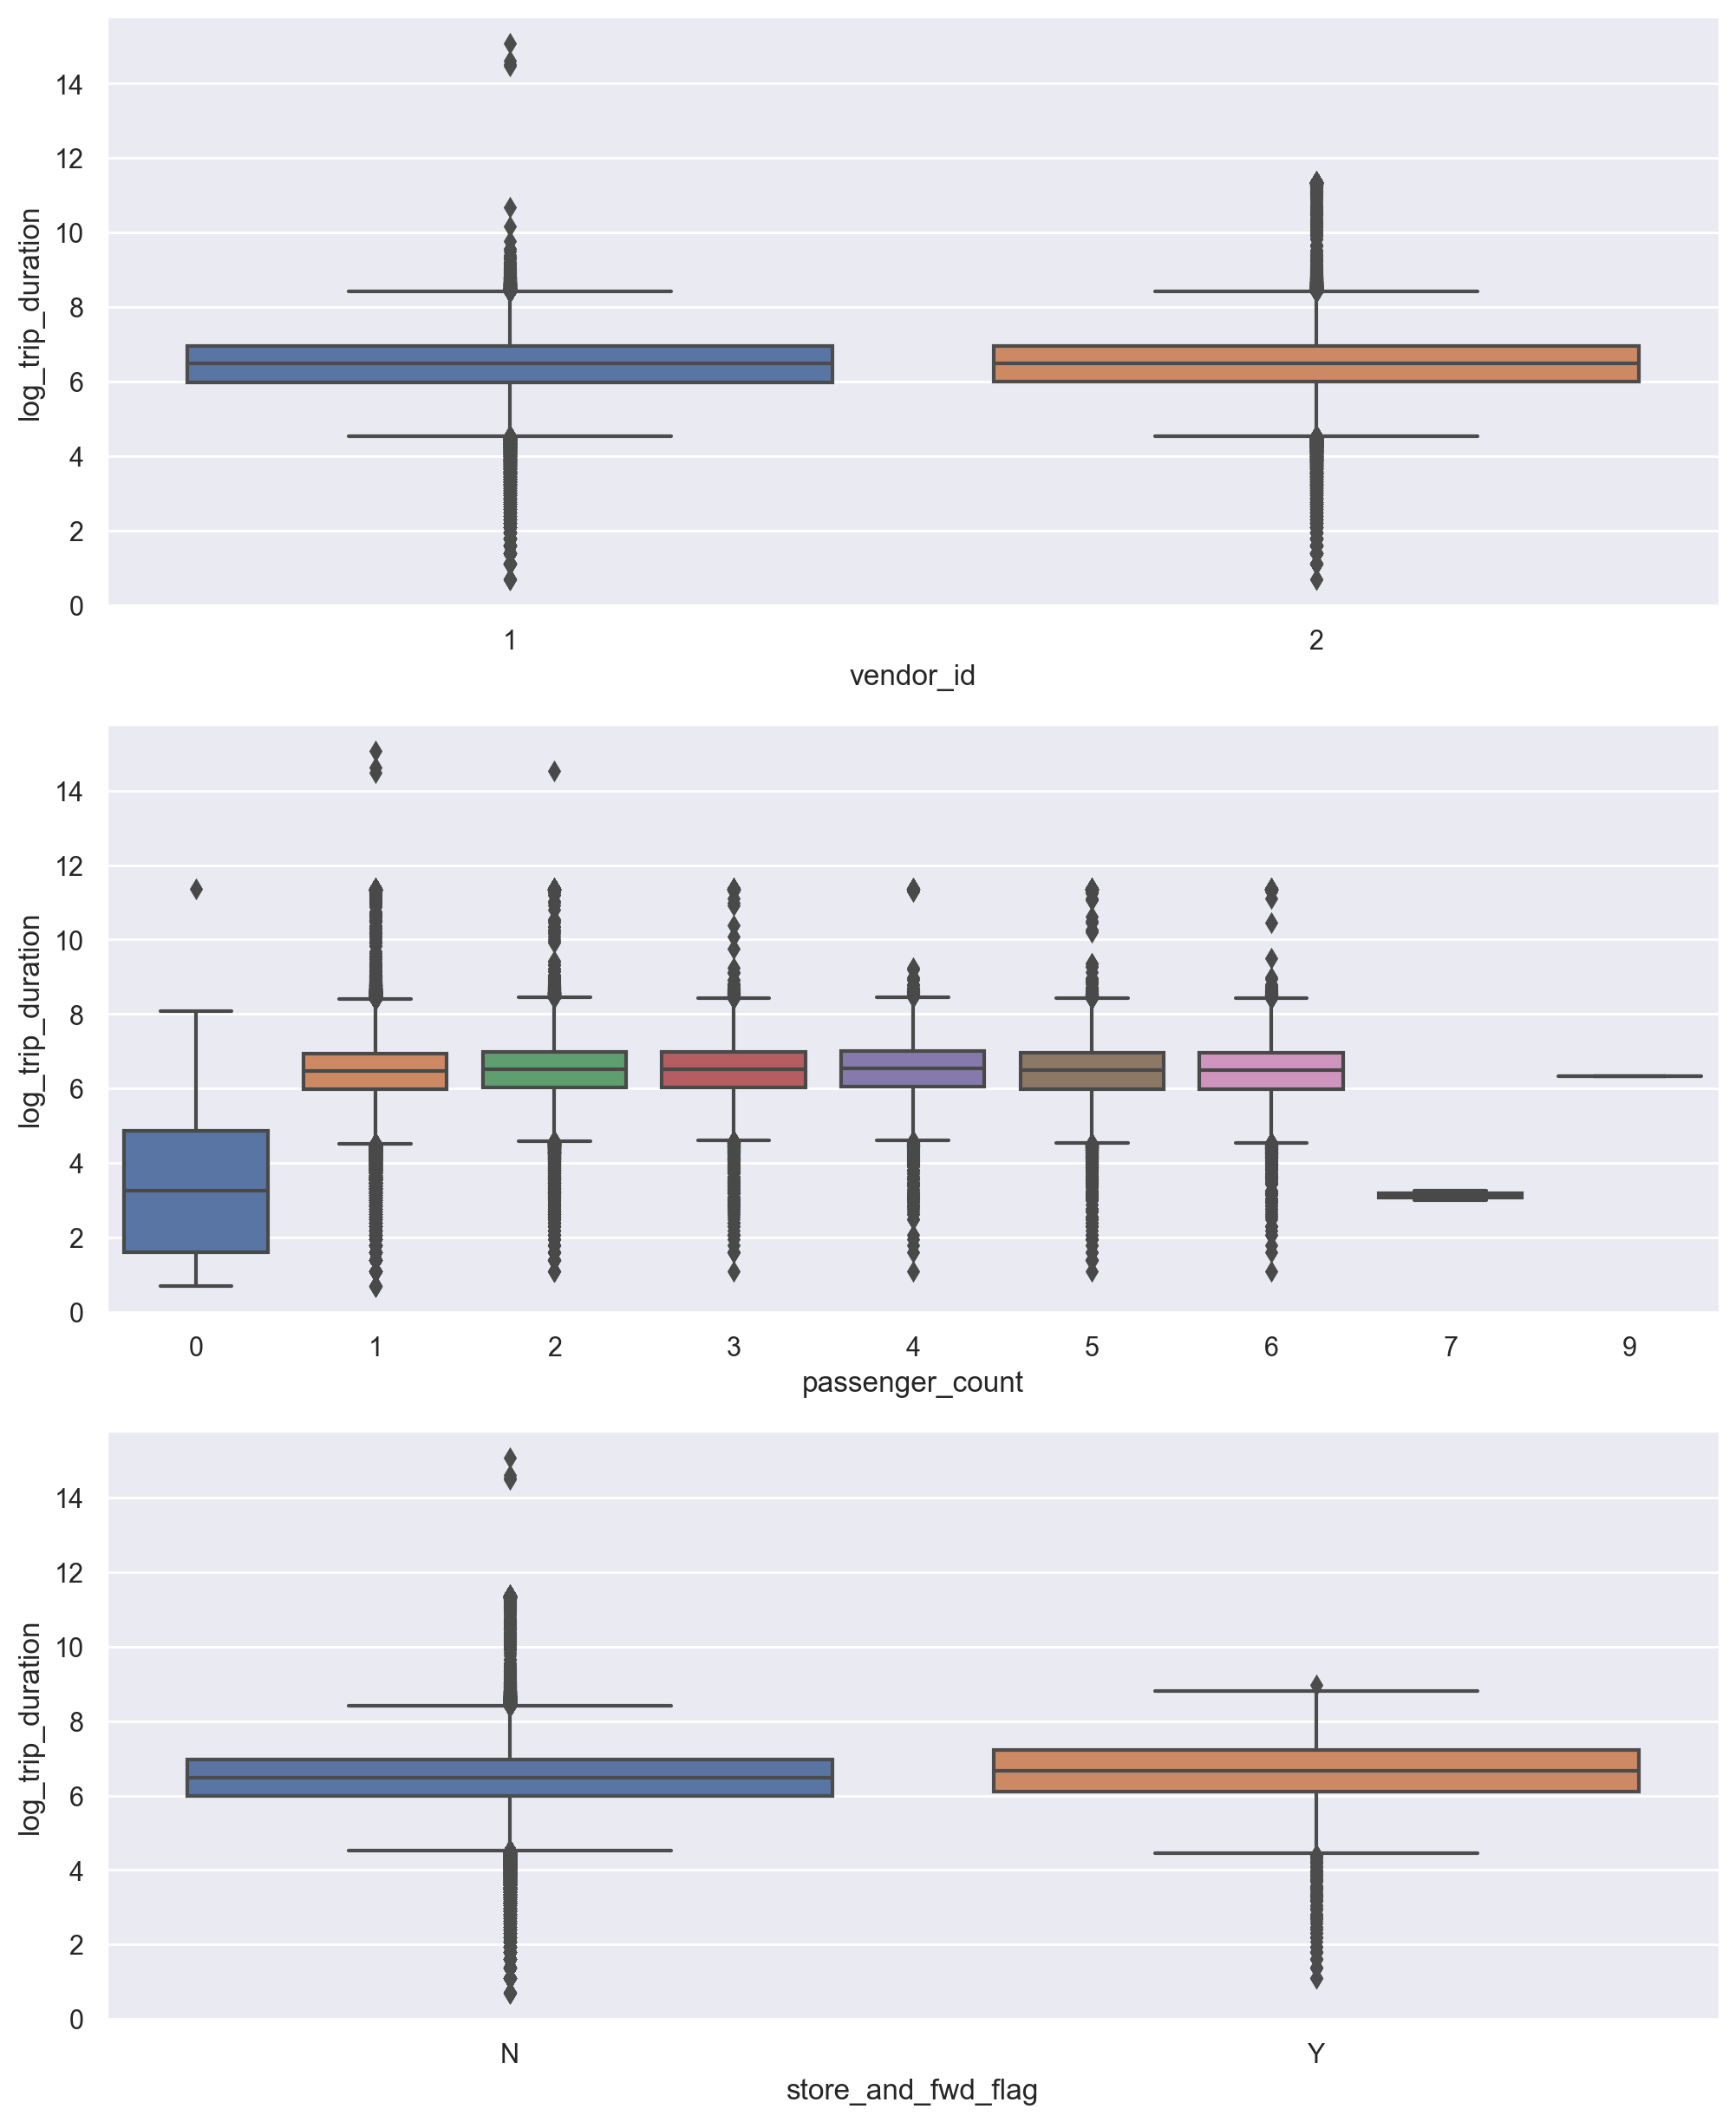

In [57]:
plt.figure(figsize=(12,15))

plt.subplot(3, 1, 1)
sns.boxplot(X_train, x='vendor_id', y='log_trip_duration')

plt.subplot(3, 1, 2)
sns.boxplot(X_train, x='passenger_count', y='log_trip_duration')

plt.subplot(3, 1, 3)
sns.boxplot(X_train, x='store_and_fwd_flag', y='log_trip_duration')
    

plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [73]:
X_train.loc[(X_train['vendor_id']==1), 'vendor_id'] = 0
X_train.loc[(X_train['vendor_id']==2), 'vendor_id'] = 1

X_train.loc[(X_train['store_and_fwd_flag']=='N'), 'store_and_fwd_flag'] = 0
X_train.loc[(X_train['store_and_fwd_flag']=='Y'), 'store_and_fwd_flag'] = 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Ответ:** мне кажется, что `vendor_id` и `store_and_fwd_flag` не изменят качество модели, т.к. распределения для разных групп у них почти одинаковые. А `passenger_count` поможет удалить выбросы, когда указано 0,7,8,9 пассажиров

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

Для начала все таки удалю строки, где число пассажиров 0, 7, 8, 9

In [59]:
X_train = X_train.loc[(X_train['passenger_count'].isin(list(range(1,7))))]

Добавились признаки `vendor_id`, `passenger_count`, `store_and_fwd_flag`. Закодируем их

In [74]:
X_train = one_hot_encoding(X_train, ['vendor_id'])
X_train = rename_columns(X_train, 'vendor_id_')
X_train = one_hot_encoding(X_train, ['passenger_count'])
X_train = rename_columns(X_train, 'passenger_count_id_')
X_train = one_hot_encoding(X_train, ['store_and_fwd_flag'])
X_train = rename_columns(X_train, 'store_and_fwd_flag_')

In [76]:
cols = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'February', 'January', 
        'June', 'March','May', 'pickup_hour_scaled', 'pickup_day_scaled', 'is_anomaly1', 'is_anomaly2', 
        'log_haversine_scaled', 'traffic_road', 'free_road', 'newark_start', 'newark_end', 'jfk_start', 'jfk_end', 
       'pickup_cell_-1',
       'pickup_cell_1', 'pickup_cell_2', 'pickup_cell_3', 'pickup_cell_4',
       'pickup_cell_5', 'pickup_cell_6', 'pickup_cell_7', 'pickup_cell_8',
       'pickup_cell_9', 'pickup_cell_10', 'pickup_cell_11', 'pickup_cell_12',
       'dropoff_cell_-1', 'dropoff_cell_1', 'dropoff_cell_2', 'dropoff_cell_3',
       'dropoff_cell_4', 'dropoff_cell_5', 'dropoff_cell_6', 'dropoff_cell_7',
       'dropoff_cell_8', 'dropoff_cell_9', 'dropoff_cell_10', 'vendor_id_0', 'vendor_id_1',
       'passenger_count_id_1', 'passenger_count_id_2', 'passenger_count_id_3',
       'passenger_count_id_4', 'passenger_count_id_5', 'passenger_count_id_6',
       'store_and_fwd_flag_0', 'store_and_fwd_flag_1'] 

ridge = Ridge()
ridge.fit(X_train[cols], X_train['log_trip_duration'])

Ridge()

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

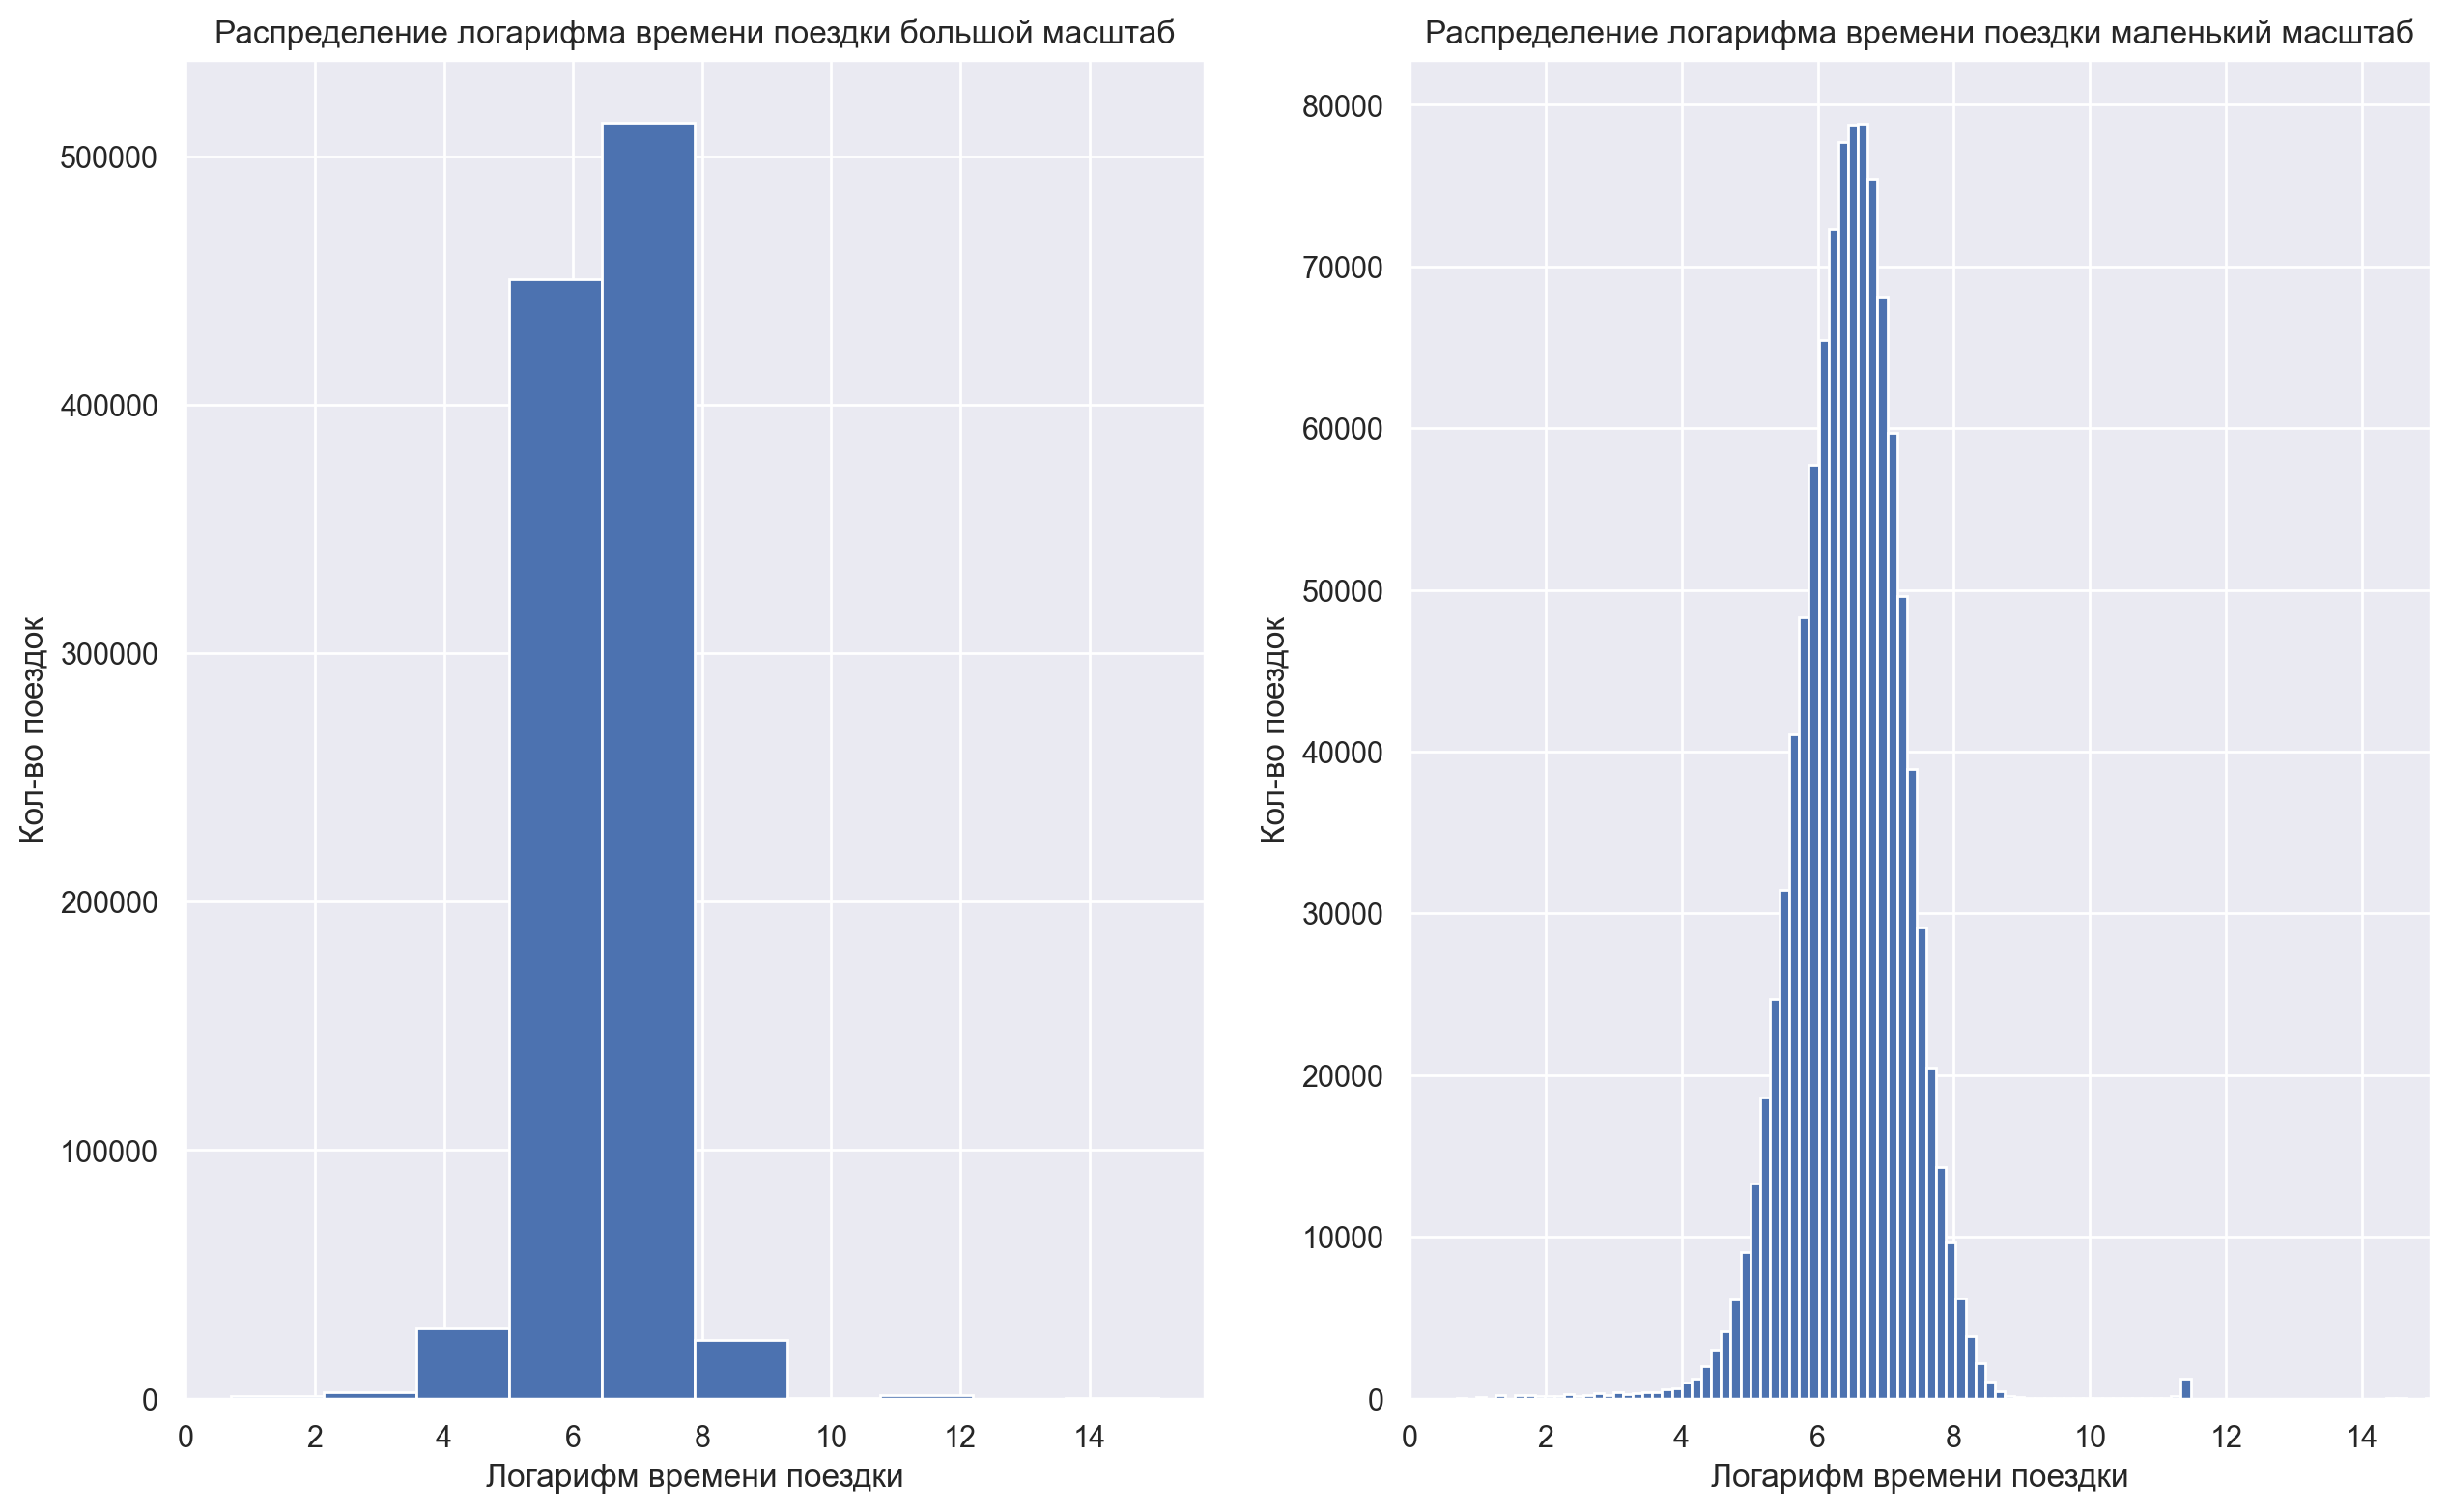

In [77]:
fig, ax = plt.subplots(1, 2)

plt.subplot(1,2,1)
plt.hist(X_train['log_trip_duration'])
plt.title('Распределение логарифма времени поездки большой масштаб')
plt.xlabel('Логарифм времени поездки')
plt.ylabel('Кол-во поездок')

plt.subplot(1,2,2)
plt.hist(X_train['log_trip_duration'], bins=100)
plt.xlim(0, 15)
plt.title('Распределение логарифма времени поездки маленький масштаб')
plt.xlabel('Логарифм времени поездки')
plt.ylabel('Кол-во поездок')

plt.show()

Видно, что есть выбросы на 12 и меньше 2. Чтобы руками их не вычислять, я просто удалю данные, которые ниже или выше определенного квантиля

In [78]:
lower = X_train.quantile(q=.025, axis=0).log_trip_duration
upper = X_train.quantile(q=.975, axis=0).log_trip_duration

X_train = X_train.loc[(X_train['log_trip_duration'].between(lower, upper))]

/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/2481778762.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  lower = X_train.quantile(q=.025, axis=0).log_trip_duration
/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/2481778762.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  upper = X_train.quantile(q=.975, axis=0).log_trip_duration


Аналогичным образом поступлю с остальными признаками

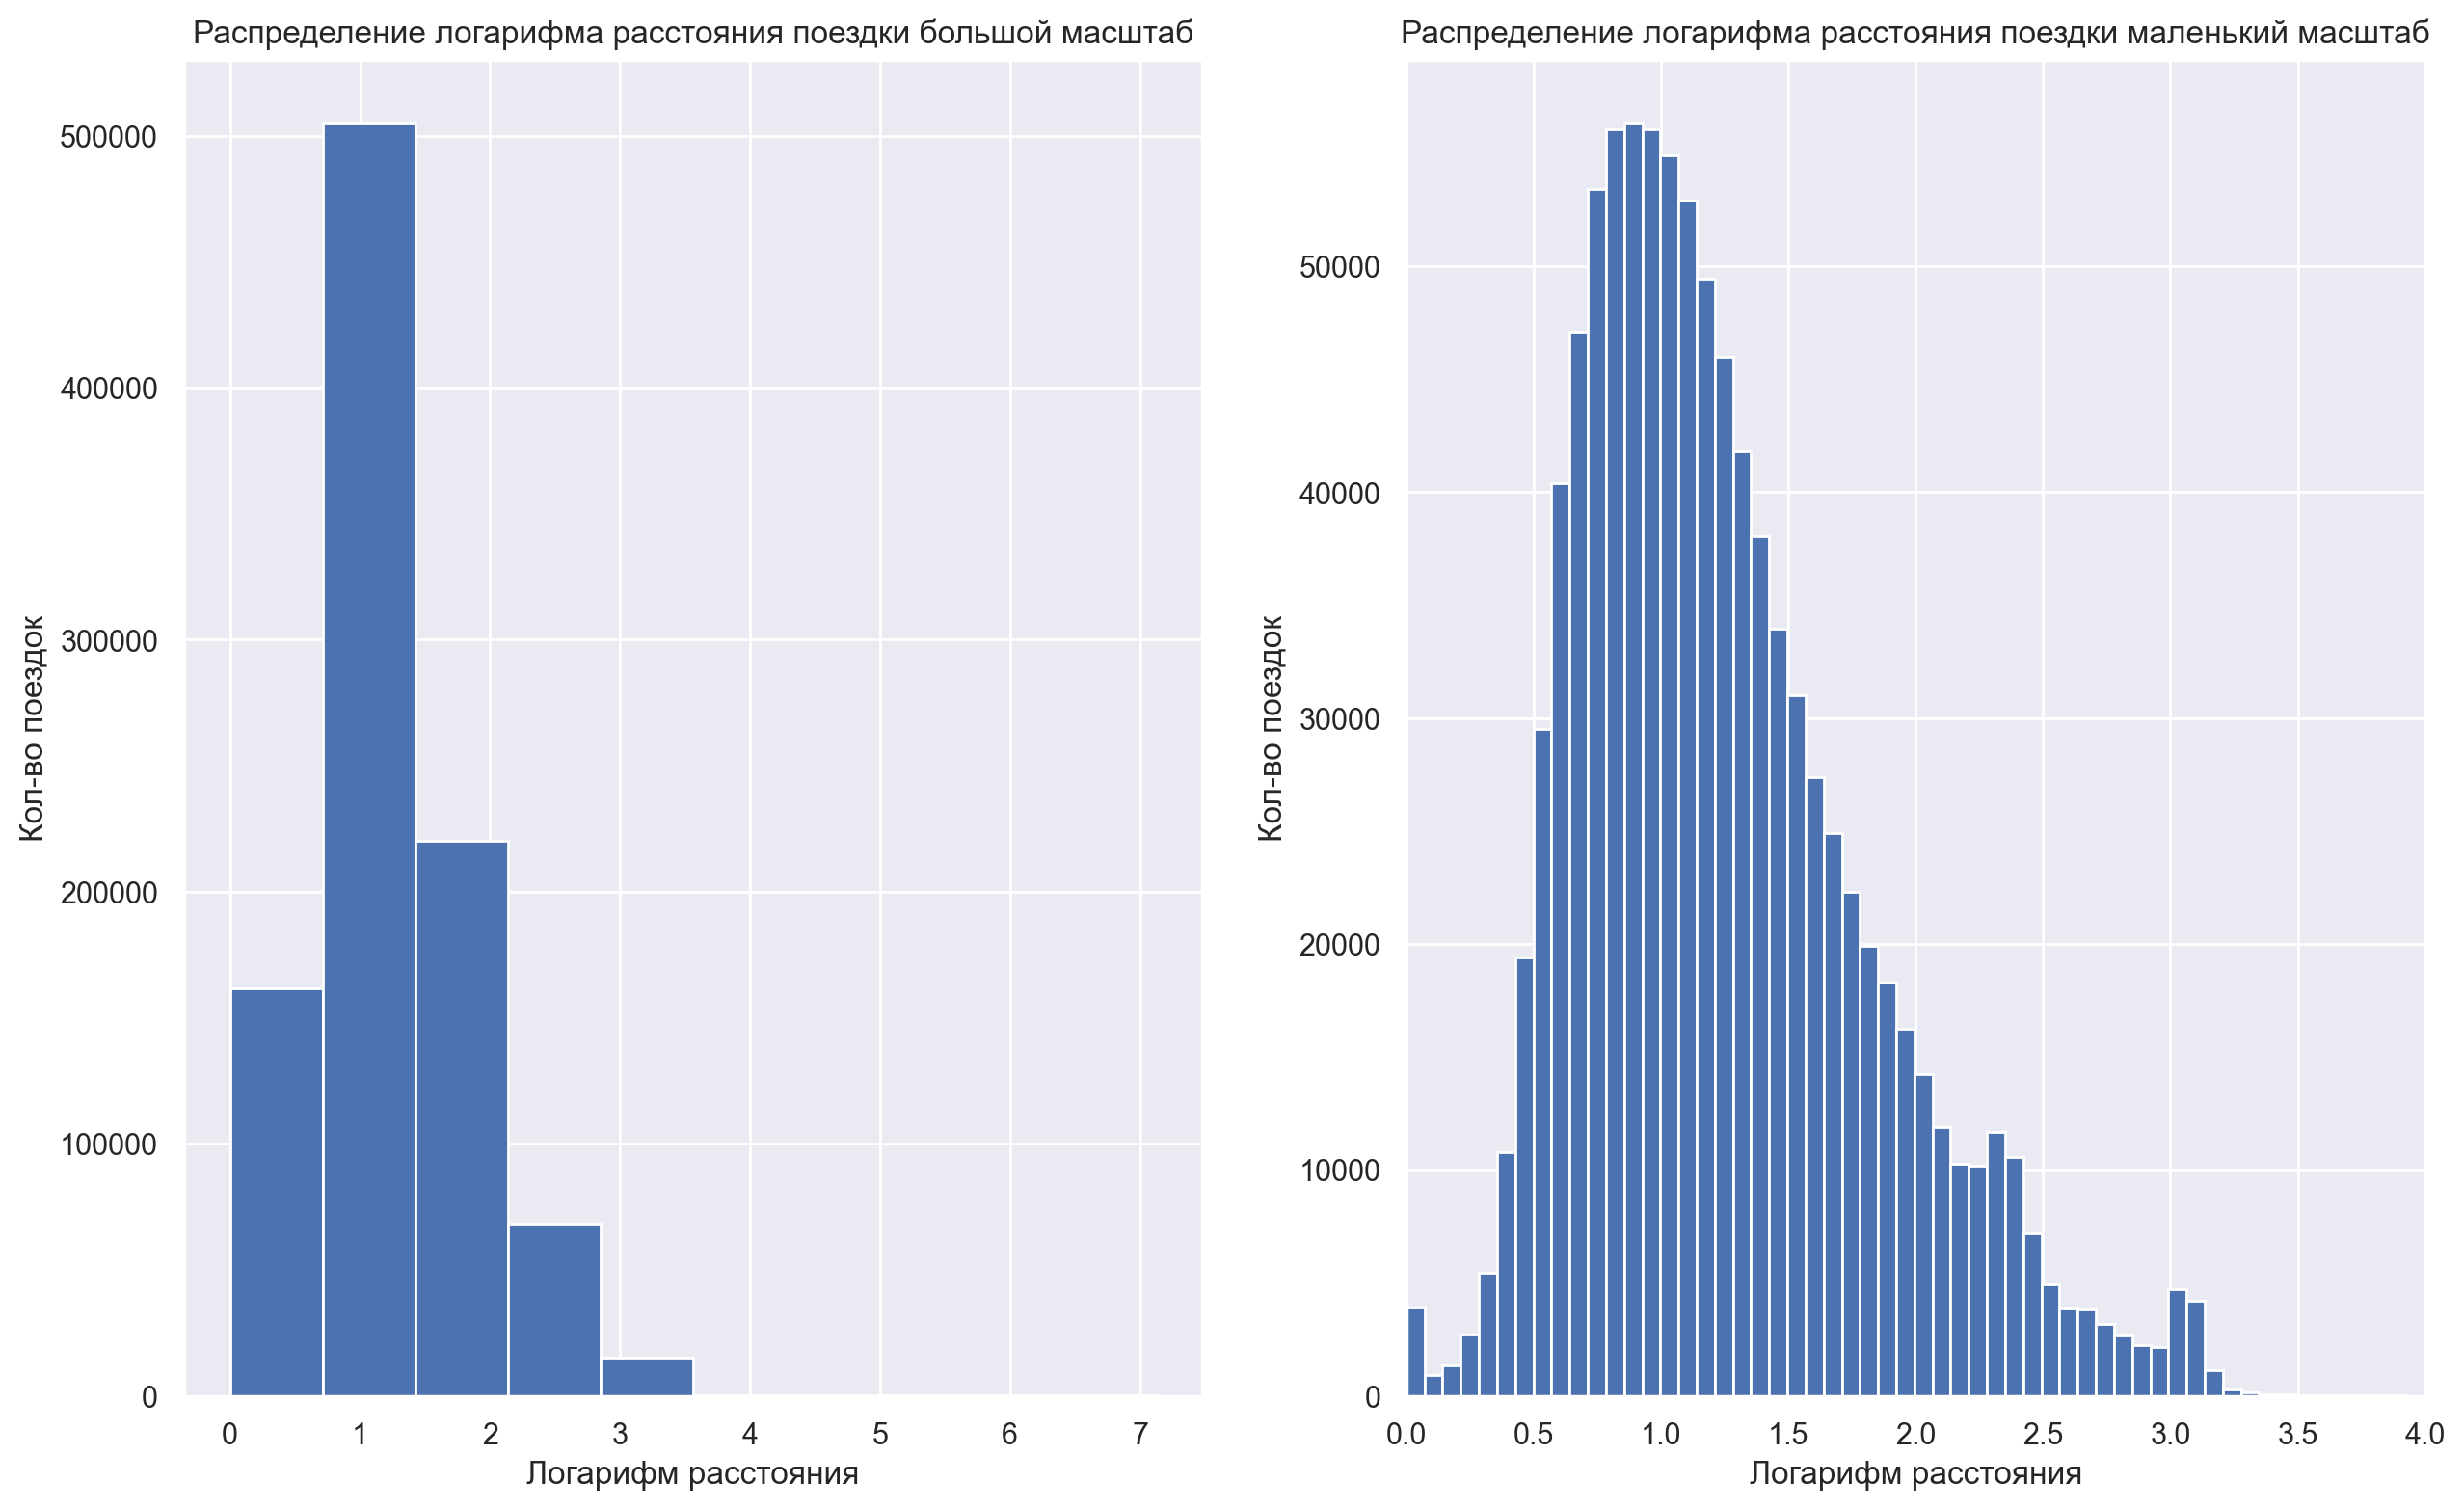

In [79]:
fig, ax = plt.subplots(1, 2)

plt.subplot(1,2,1)
plt.hist(X_train['log_haversine'])
plt.title('Распределение логарифма расстояния поездки большой масштаб')
plt.xlabel('Логарифм расстояния')
plt.ylabel('Кол-во поездок')

plt.subplot(1,2,2)
plt.hist(X_train['log_haversine'], bins=100)
plt.xlim(0, 4)
plt.title('Распределение логарифма расстояния поездки маленький масштаб')
plt.xlabel('Логарифм расстояния')
plt.ylabel('Кол-во поездок')

plt.show()

Выбросы есть около 3 и примерно в 0. Логично, что расстояние 0 - это плохое расстояние. Поступлю также, как и выше - уберу значения ниже и выше определенных квантилей

In [80]:
lower = X_train.quantile(q=.025, axis=0).log_haversine
upper = X_train.quantile(q=.975, axis=0).log_haversine

X_train = X_train.loc[(X_train['log_haversine'].between(lower, upper))]

/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/3696714825.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  lower = X_train.quantile(q=.025, axis=0).log_haversine
/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/3696714825.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  upper = X_train.quantile(q=.975, axis=0).log_haversine


Добавим регрессионые остатки

In [81]:
X_train['y_pred_train'] = ridge.predict(X_train[cols])
X_train['residuals'] = (X_train['y_pred_train'] - X_train['log_trip_duration'].mean())**2

/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/643451377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['y_pred_train'] = ridge.predict(X_train[cols])
/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/643451377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['residuals'] = (X_train['y_pred_train'] - X_train['log_trip_duration'].mean())**2


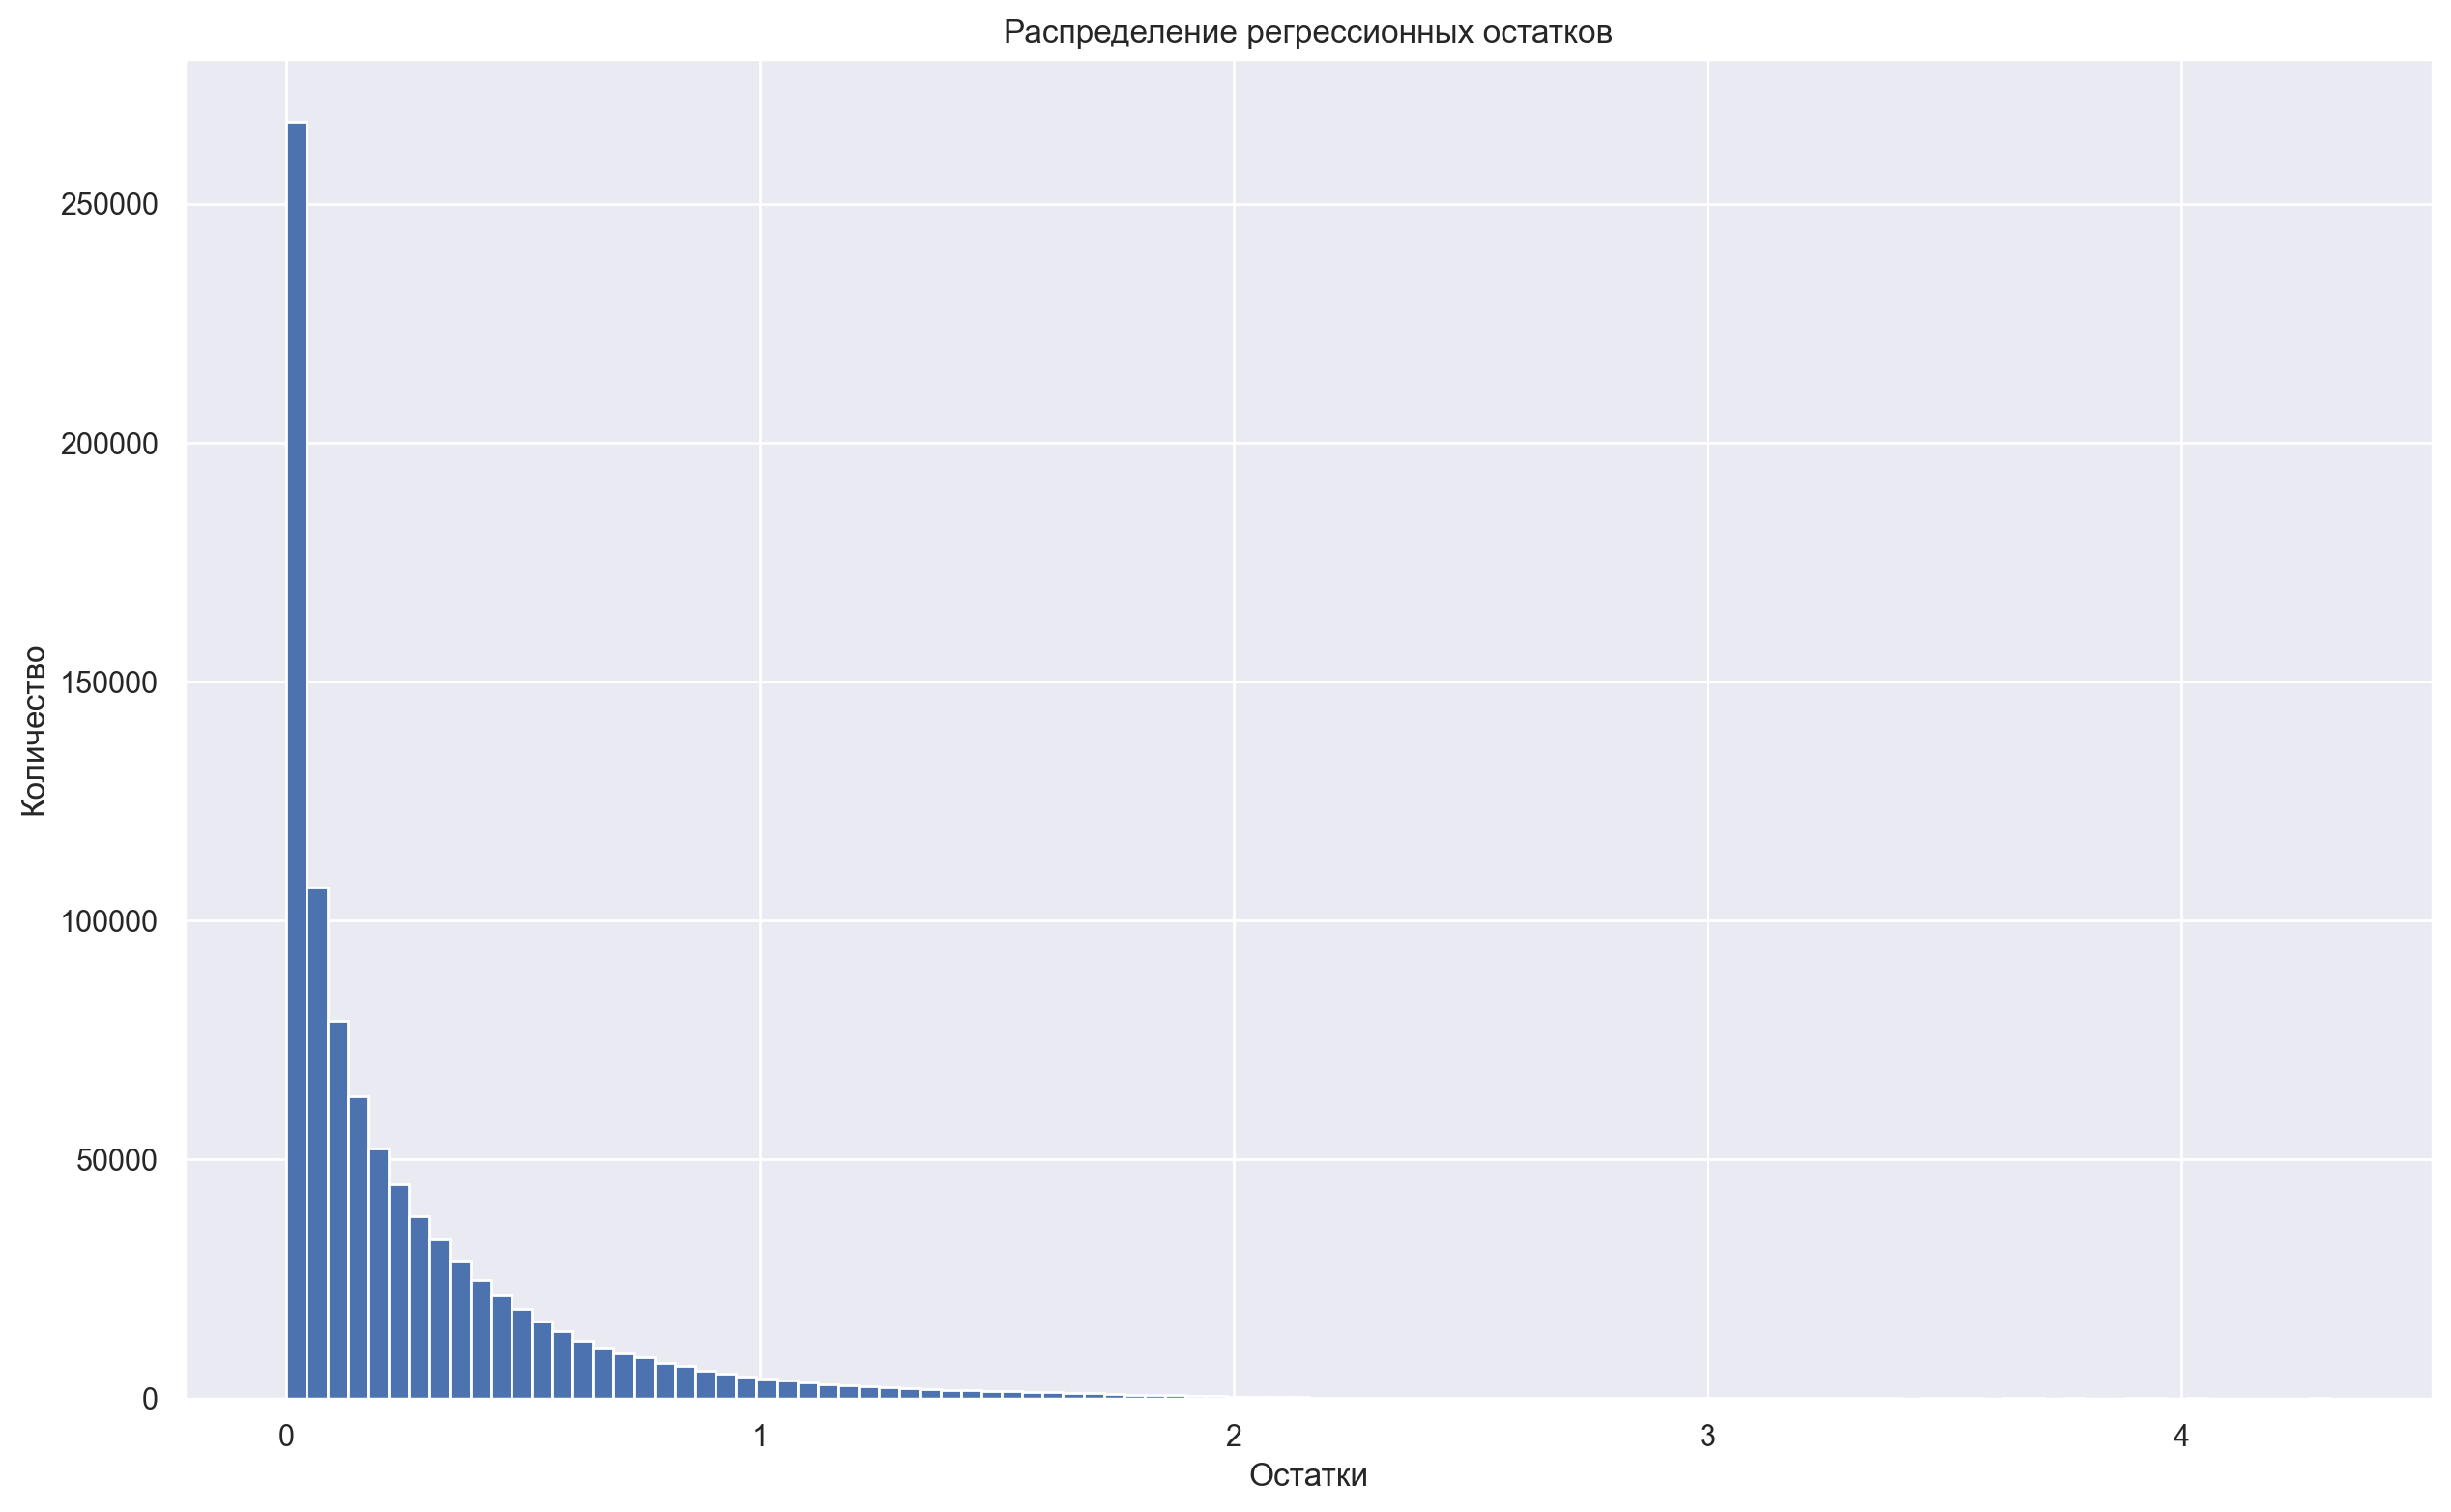

In [82]:
plt.hist(X_train['residuals'], bins=100)

plt.title('Распределение регрессионных остатков')
plt.xlabel('Остатки')
plt.ylabel('Количество')

plt.show()

Я не вижу здесь сильных выбросов, но все же отброшу 2.5% сверху для точности

In [83]:
upper = X_train.quantile(q=.975, axis=0).residuals

X_train = X_train.loc[(X_train['residuals'] <= upper)]

/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/1870720400.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  upper = X_train.quantile(q=.975, axis=0).residuals


Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

**Ответ:** Мне кажется каждый столбец под каждую аномалию - это излишек. Тк у нас в данных всего 2 таких периода и этот признак получается очень разреженным. Также аэропорты - под них выделяется 4 столбца, но количество поездок, которые начинались или заканчивались в аэропорту, совсем небольшое относительно общего кол-ва поездок. Поэтому эти категории я объединю

In [84]:
X_train['is_anomaly'] = 0
X_train.loc[(X_train['is_anomaly1'] == 1) | (X_train['is_anomaly2'] == 1), 'is_anomaly'] = 1

X_train['is_airport'] = 0
X_train.loc[(X_train['newark_start'] == 1) | (X_train['newark_end'] == 1) | (X_train['jfk_start'] == 1) | 
           (X_train['jfk_end'] == 1), 'is_airport'] = 1

/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/1629028458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['is_anomaly'] = 0
/var/folders/rg/_4q96gvs2b55r2rpp991v4w00000gq/T/ipykernel_51025/1629028458.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['is_airport'] = 0


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Ответ:** До этого момента было неочевидно, что в тестовой выборке тоже надо добавлять признаки. Получается надо было бы по два раза каждый раз добавлять признаки в трэйн и тест. Поэтому до этого момента я этого не делал. До этого и в задании не требовалось проверить качество модели, а требовалось лишь обучить). Теперь все же придется продублировать код для теста. Возможно было бы лучше указать, что следует добавлять все признаки в исходный датафрейм, а потом его один раз разделить и протетсить модели на качество

In [85]:
#Добавляю все нужные признаки в тест
#операции с датой
X_test['pickup_week'] = X_test['pickup_datetime'].dt.day_name()
X_test['pickup_month'] = X_test['pickup_datetime'].dt.month_name()
X_test['pickup_hour'] = X_test['pickup_datetime'].dt.hour
X_test['is_anomaly'] = 0
X_test.loc[df['pickup_datetime'].dt.dayofyear.isin ([23,24, 151]), 'is_anomaly'] = 1
X_test['pickup_day'] = X_test['pickup_datetime'].dt.dayofyear
#ohe и стандартизация 
X_test = one_hot_encoding(X_test, ['pickup_week', 'pickup_month'])
X_test = scaler(X_test, ['pickup_hour', 'pickup_day'])
#расстояние
X_test['haversine'] = haversine_array(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, 
                                  X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)
X_test['log_haversine'] = np.log1p(X_test['haversine'])
#загруженность дорог
X_test['traffic_road'] = 0
X_test.loc[( (X_test['pickup_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (X_test['pickup_hour'].isin(list(range(8,20))))) 
       | ((X_test['pickup_week'] == 'Saturday') & (X_test['pickup_hour'].isin(list(range(13,21))))), 'traffic_road'] = 1
X_test['free_road'] = 1
X_test.loc[( (X_train['pickup_week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) & (X_test['pickup_hour'].isin(list(range(8,20))))) 
       | ((X_test['pickup_week'] == 'Saturday') & (X_test['pickup_hour'].isin(list(range(13,21))))), 'traffic_road'] = 0

#Newark airport
X_test['newark_start'] = 0
X_test.loc[(X_test['pickup_latitude'].between(40.71, 40.74)) & (X_test['pickup_longitude'].between(-74.2, -74.1)), 'newark_start'] = 1
X_test['newark_end'] = 0
X_test.loc[(X_test['dropoff_latitude'].between(40.71, 40.74)) & (X_test['dropoff_longitude'].between(-74.2, -74.1)), 'newark_end'] = 1
#JFK airport
X_test['jfk_start'] = 0
X_test.loc[(X_test['pickup_latitude'].between(40.5, 40.7)) & (X_test['pickup_longitude'].between(-73.8, -73.7)), 'jfk_start'] = 1
X_test['jfk_end'] = 0
X_test.loc[(X_test['dropoff_latitude'].between(40.5, 40.7)) & (X_test['dropoff_longitude'].between(-73.8, -73.7)), 'jfk_end'] = 1
X_test['is_airport'] = 0
X_test.loc[(X_test['newark_start'] == 1) | (X_test['newark_end'] == 1) | (X_test['jfk_start'] == 1) | 
           (X_test['jfk_end'] == 1), 'is_airport'] = 1
#трансформер
X_test = transformer.transform(X_test)
#ohe и стандартизация
X_test = scaler(X_test, ['log_haversine'])
X_test = one_hot_encoding(X_test, ['pickup_cell'])
X_test = rename_columns(X_test, 'pickup_cell_')
X_test = one_hot_encoding(X_test, ['dropoff_cell'])
X_test = rename_columns(X_test, 'dropoff_cell_')
#вендор и стор флаг
X_test.loc[(X_test['vendor_id']==1), 'vendor_id'] = 0
X_test.loc[(X_test['vendor_id']==2), 'vendor_id'] = 1
X_test.loc[(X_test['store_and_fwd_flag']=='N'), 'store_and_fwd_flag'] = 0
X_test.loc[(X_test['store_and_fwd_flag']=='Y'), 'store_and_fwd_flag'] = 1
#ohe и стандартизация
X_test = one_hot_encoding(X_test, ['vendor_id'])
X_test = rename_columns(X_test, 'vendor_id_')
X_test = one_hot_encoding(X_test, ['passenger_count'])
X_test = rename_columns(X_test, 'passenger_count_id_')
X_test = one_hot_encoding(X_test, ['store_and_fwd_flag'])
X_test = rename_columns(X_test, 'store_and_fwd_flag_')

In [110]:
cols = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'April', 'February', 'January', 
        'June', 'March','May', 'pickup_hour_scaled', 'pickup_day_scaled', 'is_anomaly', 
        'log_haversine_scaled', 'traffic_road', 'free_road', 'is_airport', 
       'pickup_cell_-1',
       'pickup_cell_1', 'pickup_cell_2', 'pickup_cell_3', 'pickup_cell_4',
       'pickup_cell_5', 'pickup_cell_6', 'pickup_cell_7', 'pickup_cell_8',
       'pickup_cell_9', 'pickup_cell_10', 'pickup_cell_11', 'pickup_cell_12',
       'dropoff_cell_-1', 'dropoff_cell_1', 'dropoff_cell_2', 'dropoff_cell_3',
       'dropoff_cell_4', 'dropoff_cell_5', 'dropoff_cell_6', 'dropoff_cell_7',
       'dropoff_cell_8', 'dropoff_cell_9', 'dropoff_cell_10', 'vendor_id_0', 'vendor_id_1',
       'passenger_count_id_1', 'passenger_count_id_2', 'passenger_count_id_3',
       'passenger_count_id_4', 'passenger_count_id_5', 'passenger_count_id_6',
       'store_and_fwd_flag_0', 'store_and_fwd_flag_1'] 

ridge = Ridge()
ridge.fit(X_train[cols], X_train['log_trip_duration'])

Ridge()

In [119]:
y_pred = ridge.predict(X_test[cols])
print("MSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred))
print("R^2 = %.4f" %ridge.score(X_test[cols], X_test['log_trip_duration']))

MSE = 0.2520
R^2 = 0.6012


Да это просто ВАУ! Сильно лучше константного предсказания, оно было около 0.63 (MSE)

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [104]:
print('Количество признаков до кодирования = ' + str(len(df.columns)))
print('Количество признаков после кодирования = ' + str(len(X_train.columns) - 10 - len(df.columns)))

Количество признаков до кодирования = 10
Количество признаков после кодирования = 70


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [136]:
from sklearn.linear_model import Lasso
clf = Lasso()
clf.fit(X_train[cols], X_train['log_trip_duration'])

Lasso()

In [137]:
y_pred = clf.predict(X_test[cols])
print("MSE in Lasso = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred))

MSE in Lasso = 0.6325


Мда..  
Кажется, я все сделал верно, но предсказание как для константы. И y_pred везде константный

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [128]:
X_train, X_validation = train_test_split(X_train, test_size=0.2, random_state=42)

In [138]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher_ridge = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher_ridge.fit(X_validation[cols], X_validation['log_trip_duration'])

best_alpha_ridge = searcher_ridge.best_params_["alpha"]
print("Best alpha for Ridge = %.4f" % best_alpha_ridge)

searcher_lasso = GridSearchCV(Lasso(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher_lasso.fit(X_validation[cols], X_validation['log_trip_duration'])

best_alpha_lasso = searcher_lasso.best_params_["alpha"]
print("Best alpha for Lasso = %.4f" % best_alpha_lasso)

Best alpha for Ridge = 4.2813
Best alpha for Lasso = 0.0100


In [143]:
ridge = Ridge(alpha=4.2813)
ridge.fit(X_train[cols], X_train['log_trip_duration'])
y_pred = ridge.predict(X_test[cols])
print("MSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred))
print("R^2 = %.4f" %ridge.score(X_test[cols], X_test['log_trip_duration']))

MSE = 0.2521
R^2 = 0.6012


In [145]:
clf = linear_model.Lasso(alpha=0.0100)
clf.fit(X_train[cols], X_train['log_trip_duration'])
y_pred = clf.predict(X_test[cols])
print("MSE in Lasso = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred))
print("R^2 = %.4f" %ridge.score(X_test[cols], X_test['log_trip_duration']))

MSE in Lasso = 0.2693
R^2 = 0.6012


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

Text(0, 0.5, 'CV score')

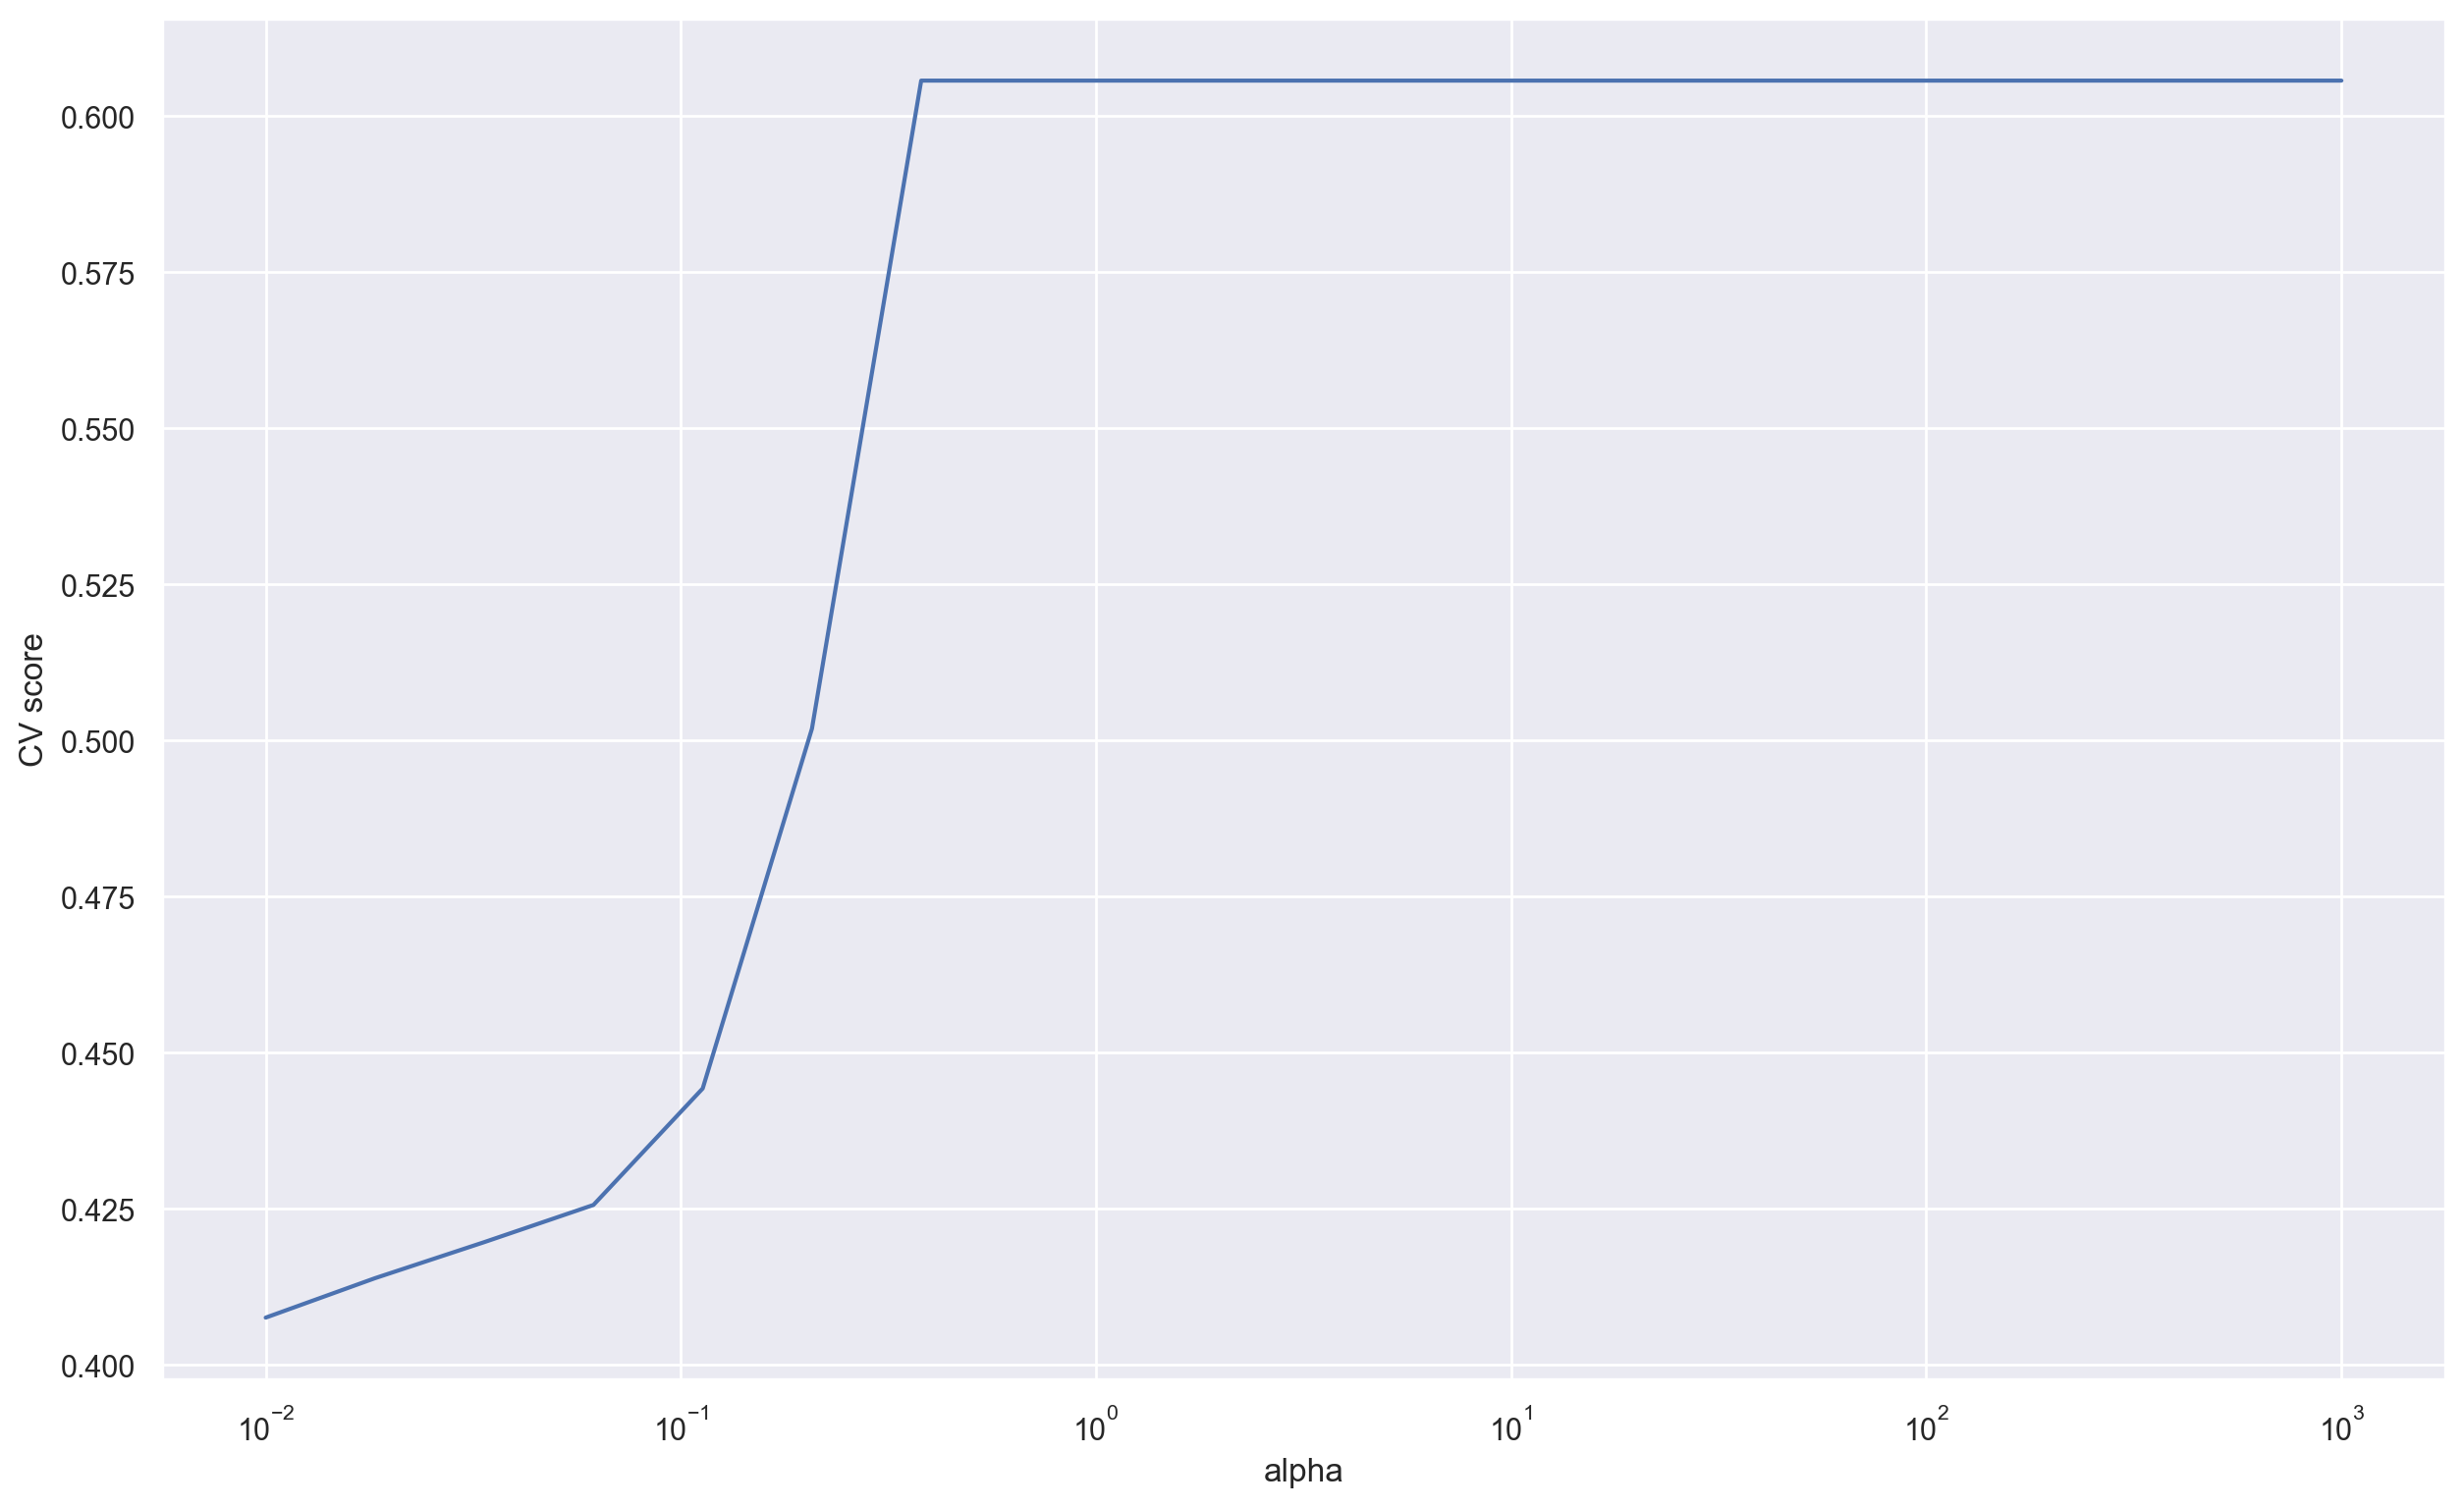

In [146]:
plt.plot(alphas, -searcher_lasso.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.